# bc-MC consumption-savings problem

## Hyperparameters 1

- bc: 0 (0 or 1)
- optim: ADAM (ADAM or SGD)
- analysis: 1 (1 or 2)

## The model

We consider the following consumption-saving problem: 

\begin{equation*}
\begin{split}
\max_{\{c_t\}_{t=0}^{\infty}} E\Big[ \sum_{t=0}^{\infty} \beta^t u(c_t) \exp(\delta_t)\Big]
\end{split}
\end{equation*}
subject to the same constraints:
$$
\begin{gather*}
\text{s.t. }w_{t+1}=\left( w_{t}-c_{t}\right) \overline{r}\exp (r_{t+1})+\exp
(y_{t+1}), \\
c_{t} \leq w_{t} + b
\end{gather*}
$$

Total income $y_t$ is assumed to be stochastic, with $y_t = \exp(\sum_{i=1}^{l} p_{i,t})$. The model has $2+l$ exogenous variables, which we assume to follow AR(1) processes:

\begin{equation}
\begin{split}
p_{i,t+1} & = \rho_{i,p} p_{i,t} + \sigma_{i,p} \varepsilon^{p}_{i,t+1}, \quad \forall i \in {1,2,...,l}\\
r_{t+1} & = \rho_r r_t + \sigma_r \varepsilon^{r}_{t+1} \\
\delta_{t+1} & = \rho_{\delta} \delta_t + \sigma_{\delta} \varepsilon^{\delta}_{t+1}
\end{split}
\end{equation}


* The state is $3+l$-dimensional vector $s = \big(w, r, \delta, p_{1}, ..., p_{l}\big)$.

* The shock is a $2+l$-dimensional vector $\varepsilon= \big(\varepsilon^{r}, \varepsilon^{\delta}\, \varepsilon^{p}_{1}, ..., \varepsilon^{p}_{l} \big)$

The variable $c_{t}$ is consumption; $w_{t}$ is the beginning-of-period
cash-on-hand; $\beta \in \left[ 0,1\right)$ is a subjective discount
factor;  $\overline{r}\in \left( 0,\frac{1}{\beta }\right)$ is a (gross)
constant interest rate; and initial condition $\left( z,w\right)$ is given.
There is an occasionally binding inequality constraint: consumption $c_{t}$
**CAN** exceed cash-on-hand $w_{t}$, because of borrowing. 


where $\epsilon^i_t \sim \mathcal{N}\left( 0,1\right)$. We assume the Cobb-Douglas utility function $u\left( {c_{t}}\right) =\frac{1}{1-\gamma }\left( c_{t}^{1-\gamma }-1\right)$.

## Euler equation of the model

Expectation is with respect to 4 shocks: $\varepsilon = (q, p, r, \delta)$


$$
\begin{gather*}
\max\Big( \beta \overline{r}E_{\epsilon }\left[ \frac{u^{\prime }\left(
c^{\prime }\right) }{u^{\prime }(c)}\exp \left(   \delta ^{\prime }-\delta
+r^{\prime }\right)  \right], \frac{u'(w + b)}{u'(c)} \Big) - 1 = 0
\end{gather*}
$$

Unit less measure of accuracy:

$$
\begin{gather*}
1 - \frac{1}{c} (u^{\prime})^{-1} \Big[\max \Big( \beta \overline{r}E_{\epsilon }\left[ u^{\prime }\left(
c^{\prime }\right) \exp \left( \delta ^{\prime }-\delta
+r^{\prime }\right), u^{\prime}(w + b) \Big) \right] = 0
\end{gather*}
$$

## ANN formulation

The solution to this dynamic programming problems is characterized by the following Kuhn-Tucker conditions:

\begin{equation}\label{eq:KT_BC}
\begin{split}
A \geq 0, H \geq 0, AH = 0 \\
A \equiv w - c\\
H \equiv u'(c) - \beta \bar{r} E_{\varepsilon} \Big[u'(c')\exp(\delta' + \delta - r')\Big]
\end{split}
\end{equation}

The loss function for the ANN is:

\begin{equation}
\begin{split}
    \mathcal{L}(\theta) & =  \mu_1 E_{s}\Big[  \Big(  E_{\varepsilon}\Big[\beta \bar{r} \frac{u'(c(s'|\theta))}{u(c(s|\theta))}\exp(\delta' + \delta - r') - h(s|\theta) \Big] \Big)^2 \Big] \\
    & + \mu_2 \Big( E_{s} \Big[ \Psi\Big(1 - \frac{c(s|\theta)}{w}, 1 - h(s|\theta)\Big)^2 \Big] \Big)
    \end{split}
\end{equation}


We use the Fischer-Burmeister (FB) function, defined by $\Psi(a, h) \equiv a + h - \sqrt{a^2 + h^2}$. The FB function is such that when it is equal to 0, the Kuhn-Tucker conditions are satisfied: $\Psi (a, h) = 0 \Leftrightarrow a \geq 0, h \geq 0, ah = 0 $ (see for instance Chen et al, 2000). 

Using the bc-MC estimator:

\begin{equation}\label{eq:loss_function_bc_1}
\begin{split}
    \mathcal{L}^U_{M,N}(\theta) & =  \mu_1 \frac{2}{MN(N-1)} \sum_{m=1}^{M} \sum_{1 \leq i < j}^{N}  f(s_m,\epsilon^i_m|\theta) f(s_m,\epsilon^j_m|\theta) \\
    & + \mu_2 \frac{1}{M} \sum_{m=1}^{M}   \Psi\Big(1 - \frac{c(s_m|\theta)}{w_m}, 1 - h(s_m|\theta)\Big)^2
\end{split}
\end{equation}

with $f(s,\epsilon|\theta) \equiv \beta \bar{r} \frac{u'(c(s'|\theta))}{u(c(s|\theta))}\exp(\delta' + \delta - r') - h(s|\theta) $

## Structure of this notebook

WIP

# 0. Dependencies 

You can use 'pip' to install dependencies.

In [1]:
on_Colab = False
# Install deps on Colab
if on_Colab == True:
    !pip install quantecon interpolation chaospy torchcontrib

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
import scipy.stats
import chaospy  ## for quadrature
from itertools import product
import os

import tensorflow as tf
import time
import os
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass
from scipy.stats import norm
import Tasmanian
import torch
from torch import nn
from torch.utils.data import DataLoader
# To create copies of NN
import copy
import matplotlib.ticker as mtick
# To use sparse kronecker product
from scipy import sparse
from torchcontrib.optim import SWA
from torch.nn.utils import clip_grad_norm_
import itertools
# Interpolations
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

# Regressions
import statsmodels.formula.api as smf
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import quantecon as qe
from interpolation import interp
from quantecon.optimize import brentq
from numba import njit, float64
from numba.experimental import jitclass
#import copy # Not used so far

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

from timeit import default_timer as timer

import platform,socket,re,uuid,json,psutil,logging, cpuinfo, shutil

2024-01-09 14:40:56.762098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-09 14:40:56.762120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
cpuinfo.get_cpu_info()

{'python_version': '3.8.10.final.0 (64 bit)',
 'cpuinfo_version': [9, 0, 0],
 'cpuinfo_version_string': '9.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 12,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz',
 'hz_advertised_friendly': '2.6000 GHz',
 'hz_actual_friendly': '4.0050 GHz',
 'hz_advertised': [2600000000, 0],
 'hz_actual': [4005024000, 0],
 'stepping': 10,
 'model': 158,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'acpi',
  'adx',
  'aes',
  'aperfmperf',
  'apic',
  'arat',
  'arch_capabilities',
  'arch_perfmon',
  'art',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'bts',
  'clflush',
  'clflushopt',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cpuid_fault',
  'cx16',
  'cx8',
  'de',
  'ds_cpl',
  'dtes64',
  'dtherm',
  'dts',
  'epb',
  'ept',
  'ept_ad',
  'erms',
  'est',
  'f16c',
  'flexpriority',
  'flush_l1d',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'hle',
  'ht',
  'hwp',
  'hwp_act_wi

In [4]:
# Display version of python currently used
!python3 --version

Python 3.8.10


In [5]:
# Display which version of packages I am using
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==1.0.0
aiodns==3.0.0
aiohttp==3.8.3
aiosignal==1.2.0
alabaster==0.7.8
altair==5.0.0
appdirs==1.4.4
apturl==0.5.2
argon2-cffi==21.1.0
arviz==0.15.1
astunparse==1.6.3
async-generator==1.10
async-timeout==4.0.1
attrs==21.2.0
autograd==1.6.2
Babel==2.6.0
backcall==0.2.0
backports.zoneinfo==0.2.1
bcrypt==3.1.7
beautifulsoup4==4.12.2
bleach==4.1.0
blinker==1.4
bokeh==2.4.2
bottle==0.12.19
branca==0.4.2
Brlapi==0.7.0
Brotli==1.0.9
bs4==0.0.1
cached-property==1.5.1
cachetools==4.2.4
cattrs==1.9.0
cchardet==2.1.7
ccsm==0.9.14.1
certifi==2019.11.28
cffi==1.15.0
chaospy==4.3.8
chardet==3.0.4
charset-normalizer==2.0.7
chrome-gnome-shell==0.0.0
Click==7.0
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==3.0.0
cmake==3.21.4
cmasher==1.6.3
colorama==0.4.3
colorspacious==1.1.2
command-not-found==0.3
compizconfig-python==0.9.14.1
conan==1.42.1
contourpy==1.0.7
corner==2.2.1
cryptography==2.8
cupshelpers==1.0
cycler==0.11.0
DateTime==4.3
dblatex===0.3.11py3
DBnomics==1.2.3
dbus-python==1.2.16
debu

In [6]:
# Set default figsize
plot_scale = 1.25
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)
# Controlling fontsizes
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE =  SMALL_SIZE + 4
plt.rcParams['legend.fontsize'] = MEDIUM_SIZE
dpi_chosen=600 #control the quality of .png
linewidth_chosen = 2

# Option when reading and saving output csv.file
read_from_csv = True #read from disk
save_to_csv = True #save to disk
run_analysis_1 = True #Increase M, keeping N constant (can be very long)
run_analysis_2 = True #Change (M,N) while keeping T constant (can be very long)

In [7]:
seed_number = 1234
random.seed(seed_number) # For replicability reasons
print(random.random()) 

0.9664535356921388


In [8]:
current_wd = os.getcwd() 
output_extension = "bc_1"
output_folder = current_wd  + "/output/"
# Create folder if does not exist:
if not os.path.exists(output_folder):
    # If it doesn't exist, create it
    os.makedirs(output_folder)
    
# Create folder to save models
output_folder_models = output_folder + '/models/'
if not os.path.exists(output_folder_models):
    # If it doesn't exist, create it
    os.makedirs(output_folder_models)
    
if on_Colab == True:
    # Mount gdrive
    from google.colab import drive
    drive.mount('/gdrive')

    # Small test
    with open('/gdrive/My Drive/foo.txt', 'w') as f:
        f.write('Hello Google Drive!')
        !cat '/gdrive/My Drive/foo.txt'

    # Create directory
    path = f"/gdrive/My Drive/{output_extension}"
    # Create folder if does not exist:
    if not os.path.exists(path):
    # If it doesn't exist, create it
        os.mkdir(path)
    # Autosave every 60 seconds
    %autosave 60
    
# Import functions from notebook
if on_Colab == False:
    %run functions-bc-MC-consumption-savings.ipynb
else:
    # Where functions are stored
    %run "/gdrive/My Drive/Colab Notebooks/functions-bc-MC-consumption-savings.ipynb"

Using cpu device


In [9]:
# Test
distrib = chaospy.J(chaospy.Normal(0, 1))
nodes, weights = dist(1, distrib, rule = "gaussian", sp=True)
nodes.shape

(1, 2)

In [10]:
# Store parameters
class MyParams():
    """
    N: number of draws for innovation vector
    M: number of draws for the state vector
    lr: learning rate
    pre_train_model: whether or not pre-train the model before starting the full training loop (not used)
    nb_epochs: number of gradient descent steps during training
    bc: borrowing constraint 
    order_gauss: order for the Gaussian quadrature to use when solving with time iteration
    σ_shocks: parameter determining the variance of shocks
    use_Sobol: whether or not use Sobol sampling for the state stapce
    dim_p: number of different pi
    grid_depth: depth of the sparse grid
    nb_refinements: nb refinement for the adaptive sparse grid
    surplus_threshold: surplus threshold to use for the adaptive sparse grid
    name_params: name of params object initialized
    nb_points_w: nb grid points for w grid
    nb_points_other: nb grid points other dimensions
    w1: weight first element loss function
    w2: weight second element loss function
    debug: if True, print info on params when building it
    """
    def __init__(self, N, M, lr, pre_train_model, nb_epochs, 
                 bc, order_gauss, σ_shocks, use_Sobol, 
                 optimizer, dim_p,
                 grid_depth, nb_refinements, surplus_threshold,
                 name_params,
                 nb_points_w=10, nb_points_other=3, 
                 w1 = 0.5, w2 = 0.5,
                 debug=False):
        # savings-consumption with binding constraint
        # Model parameters
        self.β = 0.9 
        self.γ = 2.0
        self.one_min_γ = 1 - self.γ
        self.σ_shocks = σ_shocks #default 0.01
        self.σ_r = self.σ_shocks #0.01
        self.ρ_r = 0.9 #0.2
        self.σ_δ = self.σ_shocks
        self.ρ_δ = 0.9 #0.2
        self.σ_p = self.σ_shocks
        self.ρ_p = 0.9 
        self.rbar = 1.04
        # Level of borrowing constraint
        if isinstance(bc, (int, float)):
            self.bc = bc
            self.bc_torch = torch.tensor([self.bc])
        else:
            raise TypeError("bc_chosen must be a real number (int or float).")       
        # Standard deviations for ergodic distributions of exogenous state variables
        self.σ_e_r = self.σ_r/(1-self.ρ_r**2)**0.5
        self.σ_e_δ = self.σ_δ/(1-self.ρ_δ**2)**0.5
        self.σ_e_p = self.σ_p/(1-self.ρ_p**2)**0.5
        # grids
        self.dim_p = dim_p #(p1, p2, ..., pl)
        self.dim_state = 3 + dim_p #(w ,r, delta, p1, p2, ..., pl)
        self.dim_shock = 2 + dim_p #(e_r, e_delta, e_p1, e_p2, ..., e_pl)
        self.n_points_grid = nb_points_other #nb points for (r, δ, p1, ..., pl)
        self.n_points_w = nb_points_w #10 #nb points for w
        self.r_min = -2*self.σ_e_r 
        self.r_max = 2*self.σ_e_r 
        self.δ_min = -2*self.σ_e_δ
        self.δ_max = 2*self.σ_e_δ
        self.p_min = -2*self.σ_e_p
        self.p_max = 2*self.σ_e_p 
        # bounds for endogenous state variable (cash-in-hand)
        self.wmin = 0.1
        self.wmax = 4.0
        self.w_grid = np.linspace(self.wmin, self.wmax, self.n_points_w)
        self.r_grid = np.linspace(self.r_min, self.r_max, self.n_points_grid)
        self.δ_grid = np.linspace(self.δ_min, self.δ_max, self.n_points_grid)
        self.p_grid = np.linspace(self.p_min, self.p_max, self.n_points_grid)
        # generate a tensor product grid
        # order: w, r, delta, p1, p2, ..., pn
        strr = "self.w_grid, self.r_grid, self.δ_grid"
        # add p1, ..., pl
        for i in range(0, dim_p): 
            strr = strr + ',' + "self.p_grid"
        if debug==True:
            print("Tensor product grid build with: {}".format(strr)) #debug
        self.wrδ_ps_grid = eval('list(itertools.product({}))'.format(strr))
        # Generate a grid for indices along each dimension
        self.indices_w = range(self.n_points_w)
        self.indices_r = range(self.n_points_grid)
        self.indices_δ = range(self.n_points_grid)
        self.indices_p = range(self.n_points_grid)
        # order: w, r, delta, p1, p2, ..., pn
        strr = "self.indices_w, self.indices_r, self.indices_δ"
        # add p1, ..., pl
        for i in range(0, dim_p): 
            strr = strr + ',' + "self.indices_p"
        self.wrδ_ps_indices = eval('list(itertools.product({}))'.format(strr))
        # Functions
        self.u = lambda c: (1/self.one_min_γ)*(c**(self.one_min_γ) - 1)
        self.u_prime =  lambda c: c**(-self.γ)
        self.u_prime_inv =  lambda c: c**(-(1/self.γ))
        # Standard shocks
        σ_e = 0.5 #
        μ_e = 0.0 #location parameter shocks
        # Values passed as inputs
        self.N = N #number of draws inside expectation
        self.M = M #number of draws outside expecation
        self.MN = int(M*N)
        # To keep constant the number of function evaluations
        self.T = int((M*N)/2) #number of draws all in on expectation
        # To compare Loss functions
        #self.T = int((M*N)) #number of draws all in on expectation
        self.x_distribution = "Uniform" #"Normal" #Uniform or Normal
        self.σ_e = σ_e
        self.μ_e = μ_e
        self.e_distribution = "Lognormal" #"Normal"
        self.x_low = self.wmin
        self.x_high = self.wmax
        # Vectorized Monte Carlo requires the creation of some objects
        # To repeat vectors
        repeat_vector = torch.ones(N) #to repeat the same value n times using a matrix multiplication
        # To calculate the expectation wrt future shocks using a matrix multiplication
        A = sparse.eye(M) 
        B = sparse.csr_matrix(np.ones(N)/N)
        # Sparse kronecker product. Then convert to pytorch sparse
        # W used using the sum((sum)^2) formula
        W = sparse_mx_to_torch_sparse_tensor(sparse.kron(A, B))
        self.repeat_vector = repeat_vector
        self.W = W  
        # W used using the 2/N(N-1) sum() formula
        self.W_expanded = create_W_expanded_matrix(self.M, self.N)
        # Learning parameters
        self.lr = lr
        self.momentum = 0.9 #momentum for SGD with momentum
        self.lr_pre_train = 1e-3 #learning rate during pre-training
        self.optimizer = optimizer #"Adam" #default: #Adam or SGD or SWA
        self.freq_gamma = 0.95 #0.85
        self.use_scheduler = False #default: True
        self.pre_train_model = pre_train_model #default: True
        self.nb_epochs = nb_epochs
        self.nb_epochs_pre_train = int(self.nb_epochs/1)
        self.freq_scheduler = 1000 #int(self.nb_epochs/10)
        # Sobol sampling
        self.soboleng = torch.quasirandom.SobolEngine(dimension=1) #sobol draws for income
        self.use_Sobol = use_Sobol #Sobol for dimension M
        self.use_Sobol_T = use_Sobol #Sobol for all-in-one
        # DEBUG PARAMS
        self.error_correction=True #error correction for the model
        self.selective_error_correction=False #error correction for the model, only if give positive values
        self.abs_value=False
        self.perfect_forecast = False
        self.fake_bias=0.0
        # GAUSSIAN QUADRATURE
        # value e_r, e_δ, e_p1, e_p2, ..., e_pl
        strr = "chaospy.Normal(0, self.σ_r), chaospy.Normal(0, self.σ_δ)"
        # add p1, ..., pl
        for i in range(0, dim_p): 
            strr = strr + ',' + "chaospy.Normal(0, self.σ_p)"
        if debug==True:
            print("Quadrature grid build for: {}".format(strr)) #debug
        self.distrib = eval('chaospy.J({})'.format(strr))
        #self.distrib = chaospy.J(chaospy.Normal(0, self.σ_r), chaospy.Normal(0, self.σ_δ), chaospy.Normal(0, self.σ_p))
        self.order_gauss = order_gauss
        nodes, weights = dist(self.order_gauss, self.distrib, rule = "gaussian", sp=True)
        self.nodes = nodes
        self.weights = weights
        self.weights_torch = torch.tensor(weights)
        self.nodes_torch = torch.tensor(np.transpose(self.nodes)) #column=dim. Row=observation
        # Save the number of points for the guassian quadrature:
        self.N_gaussian = len(self.weights_torch)
        # Implied number of points for the current space (T=MN/2 <-> M = 2T/N)
        self.M_gaussian = int((2*self.T)/self.N_gaussian)
        self.MN_gaussian = self.N_gaussian*self.M_gaussian
        # Repeat nodes to match the number of function evaluations for the expectation
        self.nodes_torch_repeated = self.nodes_torch.repeat(self.M_gaussian, 1)
        # CREATE A W MATRIX FOR GAUSSIAN QUADRATURE:
        B_gaussian = sparse.csr_matrix(self.weights_torch)
        # Sparse kronecker product. Then convert to pytorch sparse
        A_gaussian = sparse.eye(self.M_gaussian) 
        self.W_gaussian = sparse_mx_to_torch_sparse_tensor(sparse.kron(A_gaussian, B_gaussian))
        # SCALE OF THE OBJECTIVE FUNCTION
        self.nb_points_test = 1000
        self.xvec_test_torch = torch.linspace(self.x_low, self.x_high, self.nb_points_test).unsqueeze(1) #add a dimension
        self.xvec_test = self.xvec_test_torch.numpy()
        self.swa_start = 1000
        self.swa_freq= 10
        # To measure accuracy during training
        self.M_accuracy = 5000
        self.N_accuracy = 100
        self.MN_accuracy = int(self.M_accuracy*self.N_accuracy)
        self.repeat_vector_accuracy = torch.ones(self.N_accuracy)
        # Sparse version        
        A = sparse.eye(self.M_accuracy)
        B = sparse.csr_matrix(np.ones(self.N_accuracy)/self.N_accuracy)
        # Sparse kronecker product. Then convert to pytorch sparse
        self.W_accuracy = sparse_mx_to_torch_sparse_tensor(sparse.kron(A, B))
        # randomly drawing current states
        self.r_accuracy = torch.normal(mean=0, std=self.σ_e_r, size=(self.M_accuracy,)) 
        self.δ_accuracy = torch.normal(mean=0, std=self.σ_e_δ, size=(self.M_accuracy,)) 
        # dimension (M, dim_p)
        self.p_accuracy = torch.normal(mean=0, std=self.σ_e_p, size=(self.M_accuracy, dim_p)) 
        #w = (params.wmin - params.wmax) * torch.rand(n) + params.wmax #uniform
        w = (self.wmin - self.wmax) * self.soboleng.draw(self.M_accuracy) + self.wmax #uniform
        self.w_accuracy = w.squeeze(1)
        # n_Monte_Carlo for each value today
        self.e_r_accuracy = torch.normal(mean=0, std=self.σ_r, size=(self.MN_accuracy,)) 
        self.e_δ_accuracy = torch.normal(mean=0, std=self.σ_δ, size=(self.MN_accuracy,)) 
        self.e_p_accuracy = torch.normal(mean=0, std=self.σ_p, size=(self.MN_accuracy, dim_p)) 
        #
        self.r_repeated_accuracy = torch.kron(self.r_accuracy, self.repeat_vector_accuracy)
        self.δ_repeated_accuracy = torch.kron(self.δ_accuracy, self.repeat_vector_accuracy)
        self.w_repeated_accuracy = torch.kron(self.w_accuracy, self.repeat_vector_accuracy)
        # dimension (MN, dim_p))
        self.p_repeated_accuracy = self.p_accuracy.repeat_interleave(self.N_accuracy, dim=0) #repeat N times
        # transitions of the exogenous processes
        #r = torch.normal(mean=0, std=σ_e_r, size=(n,)) 
        #torch.kron(r, repeat_vector).shape
        self.rnext_accuracy = self.r_repeated_accuracy*self.ρ_r + self.e_r_accuracy
        self.δnext_accuracy = self.δ_repeated_accuracy*self.ρ_δ + self.e_δ_accuracy
        self.pnext_accuracy = self.p_repeated_accuracy*self.ρ_p + self.e_p_accuracy
        # For the next period, the sum of p1, p2, ... , pl matter
        self.pnext_sum_accuracy = torch.sum(self.pnext_accuracy, axis=1) #sum over rows
        # To store the solution of time iteration
        # Order of the loop: w, r, delta, p1, p2, ..., pn
        strr = "self.n_points_w, self.n_points_grid, self.n_points_grid"
        # add p1, ..., pl
        for i in range(0, dim_p): 
            strr = strr + ',' + "self.n_points_grid"
        if debug==True:
            print("Grid to store TI values: {}".format(strr)) #debug
        self.c_grid_TI = eval('np.zeros(({}))'.format(strr))
        # Order of the loop: w, r, delta, p1, p2, ..., pn
        strr = f"{name_params}.n_points_w, {name_params}.n_points_grid, {name_params}.n_points_grid"
        # add p1, ..., pl
        for i in range(0, dim_p): 
            strr = strr + ',' + f"{name_params}.n_points_grid"
        self.str_nb_points = strr
        # Order of the loop: w, r, delta, p1, p2, ..., pn
        strr = f"{name_params}.w_grid, {name_params}.r_grid, {name_params}.δ_grid"
        # add p1, ..., pl
        for i in range(0, dim_p): 
            strr = strr + ',' + f"{name_params}.p_grid"
        strr = strr + "," + "σ, x"
        self.str_c_grid_TI = strr
        if debug==True:
            print("Grid for c_grid_TI: {}".format(self.str_c_grid_TI)) #debug
        exec('self.c_function_TI = lambda x: interp({})'.format(strr))
        # For evaluations with a function
        strr = f"{name_params}.w_grid, {name_params}.r_grid, {name_params}.δ_grid"
        # add p1, ..., pl
        for i in range(0, dim_p): 
            strr = strr + ',' + f"{name_params}.p_grid"
        strr = strr + "," + "σ_local, x"
        self.str_c_grid_TI_local = strr
        def identity_function(x):
            return x
        self.c_function_TI = identity_function #Initialization TI solution, interpolated
        self.ss = np.ones(self.dim_state) #steady-state value
        # Parameters for the adaptive sparse grid
        self.grid_depth = grid_depth # Initial depth of the sparse grid
        self.nb_refinements = nb_refinements # Nb of refinement steps for the sparse grid
        self.surplus_threshold = surplus_threshold #
        self.grid_dim = 3 + self.dim_p # Dimension input: (w, r, delta, vector ps)
        self.grid_out = 1 # Dimension output
        self.grid_order = 1 #1 # 1=linear, 2=quadratic, 3=cubic
        self.grid_rule = "localp" # Type of base functions
        # Need to set the domain
        ## 2 columns: min, max
        ## rows: corresponding to a variable
        ## Order: w, r, delta, p1, p2, ..., pn
        self.domain_transform = np.zeros((self.grid_dim, 2))
        self.domain_transform[0,:] = np.array([self.wmin, self.wmax])
        self.domain_transform[1,:] = np.array([self.r_min, self.r_max])
        self.domain_transform[2,:] = np.array([self.δ_min, self.δ_max])
        # max and min for the ps:
        self.domain_transform[3:,:] = np.array([self.p_min, self.p_max])
        # Store grid that is updating during time iteration
        self.grid_old = Tasmanian.makeLocalPolynomialGrid(self.grid_dim, self.grid_out, self.grid_depth, self.grid_order, self.grid_rule)
        self.grid_old.setDomainTransform(self.domain_transform)
        self.grid_old_points = self.grid_old.getPoints() # Points of the grid
        # Let's store another grid to test for convergence of the time iteration algo
        self.grid_depth_test = 2
        self.grid_test = Tasmanian.makeLocalPolynomialGrid(self.grid_dim, self.grid_out, self.grid_depth_test, self.grid_order, self.grid_rule)
        self.grid_test.setDomainTransform(self.domain_transform)
        self.grid_test_points = self.grid_old.getPoints()
        # To store sparse solution
        self.c_grid_TI_sparse = np.zeros((self.grid_old_points.shape[0],1))
        self.c_function_TI_sparse = identity_function # Initialization TI solution, using sparse grid
        # weights in the loss function
        self.w1 = w1
        self.w2 = w2
        # Check bad combination
        if (self.optimizer == "SWA") & (self.use_scheduler == True):
            raise('opt SWA and use_schedule = True')

In [11]:
M_chosen = 100 #25 #100 #200 # 50 #outer expectation 
N_chosen = 2 #8 #2 #4 # Inner expectation
lr_chosen = 1e-3 #0.5e-2
pre_train_model_chosen = False
nb_epochs_chosen = 10000 #10000
order_gauss = 1 #2 #Default. order_gauss = 2
bc_chosen = 1.0 #0.0 #0.0 #1.0
σ_shocks_chosen = 0.01
use_Sobol_chosen = False
optimizer_chosen = "Adam"
dim_p_chosen =  2 #Default is 2 (p and q, as in section 4.2)
# Parameters for the sparse grid
grid_depth_chosen = 3
nb_refinements_chosen = 2
surplus_threshold_chosen = 1e-4
name_params = "params_TI"
w1_chosen = 0.5
w2_chosen = 0.5

# REMARK:
# for the dense grid, to change the number of points on w-grid, change self.n_points_w = 10 
# to change the number of points for the other dimensions, change self.n_points_grid = 3
params_TI = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen, 
                  nb_epochs_chosen, bc_chosen, order_gauss,
                  σ_shocks_chosen, use_Sobol_chosen, optimizer_chosen, 
                  dim_p_chosen, grid_depth_chosen, nb_refinements_chosen, surplus_threshold_chosen, 
                  name_params, nb_points_w=10, nb_points_other=3,
                  w1 = w1_chosen, w2 = w2_chosen)

show_params(params_TI)

learning rate: 0.001
nb epochs: 10000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 1.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5


/tmp/ipykernel_19244/2656475211.py:8: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


---
---

# I. Time iteration solution

## I.A Time iteration solution on dense grid

Iterate over the Euler equation of the model:

$$
\begin{gather*}
u^{\prime }(c) = \beta \overline{r}E_{\epsilon }\left[ u^{\prime }\left(
c^{\prime }\right) \exp \left(   \delta ^{\prime }-\delta
+r^{\prime }\right)  \right] 
\end{gather*}
$$

$$ c(w_t, y_t, p_t, r_t, \delta_t) $$

In [12]:
# Initial guess for time iteration
# initialize empty array
exec("σ = np.zeros(({}))".format(params_TI.str_nb_points))
print("Shape array: {}".format(σ.shape))

# Loop over values and indices
# Order:  w, r, delta, p1, p2, ..., pn
for (counter, (indices, vals)) in enumerate(zip(params_TI.wrδ_ps_indices, params_TI.wrδ_ps_grid)):
    w_value = vals[0]
    σ[indices] = 0.9*w_value
    
# Interpolate
σ_func =  eval('lambda x: interp({})'.format(params_TI.str_c_grid_TI))
σ_func(np.array(vals) + 1) 

Shape array: (10, 3, 3, 3, 3)


3.6

In [13]:
%%time
tol=0.0001
max_iter=100
verbose=True
print_skip = 1
i = 0
error = tol + 1

while i < max_iter:
    σ_new = K_quadrature(σ, σ_func, params_TI)
    error = np.max(np.abs(σ - σ_new))
    i += 1
    if verbose and i % print_skip == 0:
        print(f"Error at iteration {i} is {error}.")
    σ = σ_new
    
    #Create function by interpolation
    σ_func_TI = eval('lambda x: interp({})'.format(params_TI.str_c_grid_TI))
        
    if (error < tol) or (i == max_iter):
        if (error < tol):
            print("Convergence reached after {} iterations".format(i))
        if (i == max_iter):
            print("Convergence NOT reached after {} iterations".format(i))
        params_TI.c_grid_TI = copy.deepcopy(σ)
        params_TI.c_function_TI = copy.deepcopy(σ_func_TI)
        break

Error at iteration 1 is 1.20761575551894.
Error at iteration 2 is 0.4198695660078615.
Error at iteration 3 is 0.20986490611545738.
Error at iteration 4 is 0.12285918278347219.
Error at iteration 5 is 0.07993755718530537.
Error at iteration 6 is 0.05513434787327531.
Error at iteration 7 is 0.0510802165621278.
Error at iteration 8 is 0.05088266222948179.
Error at iteration 9 is 0.05085368584486205.
Error at iteration 10 is 0.04029805935004649.
Error at iteration 11 is 0.03588398297030437.
Error at iteration 12 is 0.03222601403061387.
Error at iteration 13 is 0.0308035218243623.
Error at iteration 14 is 0.02679324724676979.
Error at iteration 15 is 0.022090991006097127.
Error at iteration 16 is 0.018301735905883687.
Error at iteration 17 is 0.014566809459609642.
Error at iteration 18 is 0.011970636857719263.
Error at iteration 19 is 0.010158193162509432.
Error at iteration 20 is 0.008053920946926807.
Error at iteration 21 is 0.007043701757210252.
Error at iteration 22 is 0.005874459528517

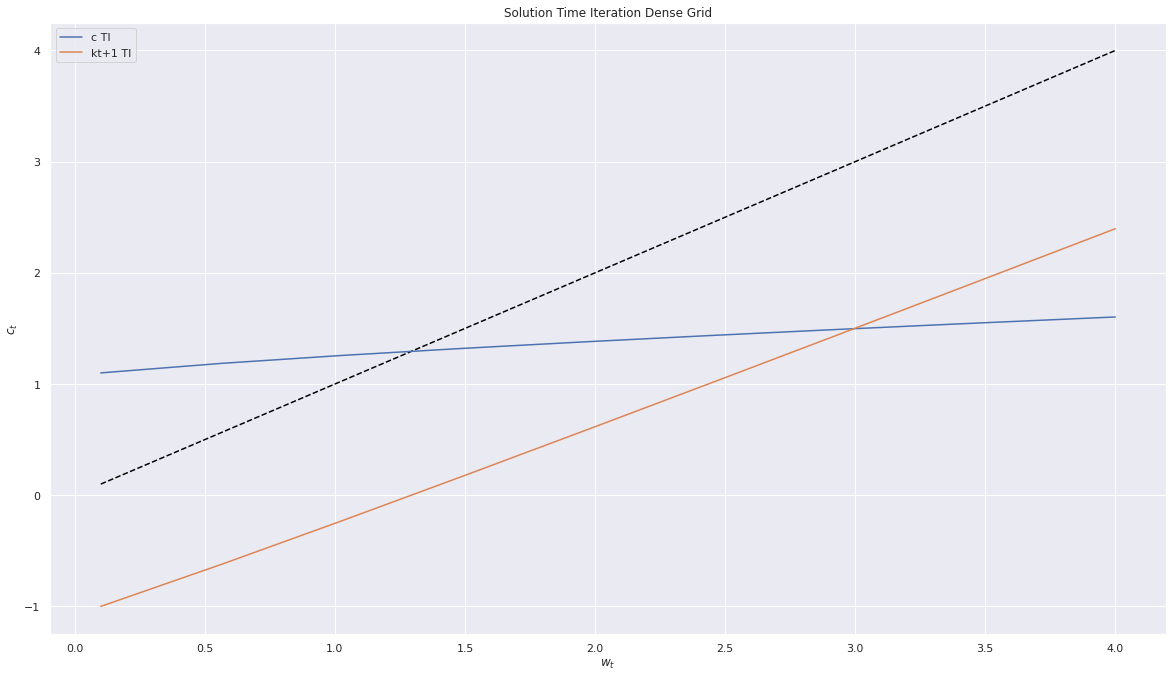

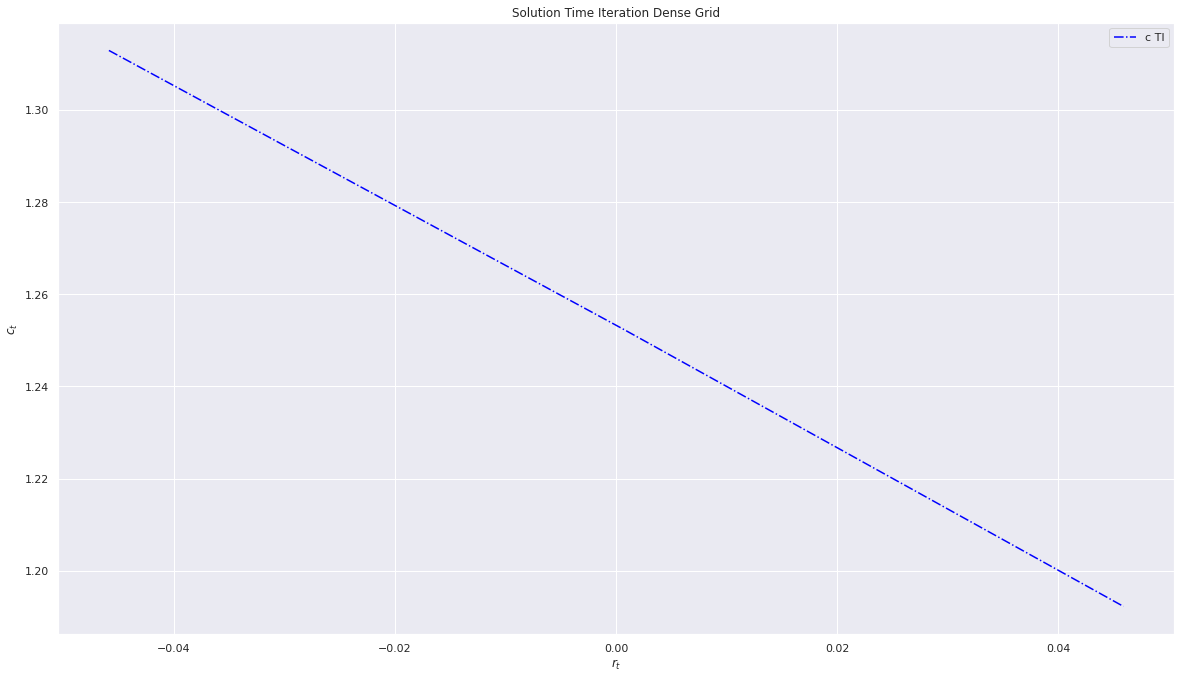

In [14]:
# Plot the result
len_wec = params_TI.nb_points_test

with torch.no_grad():
    rvec = 0.0*np.ones(len_wec) #np.zeros(len_wec)
    δvec = 0.0*np.ones(len_wec) #np.zeros(len_wec)
    wvec = params_TI.xvec_test

    wrδ_next = np.column_stack((wvec, rvec, δvec)) #w, r, delta
    state_next = np.hstack((wrδ_next, np.zeros((len_wec, dim_p_chosen))))
    
    cvec_TI = params_TI.c_function_TI(state_next) #σ_func(state_next)
    # Save for latter use
    cvec_TI_bc_0 = cvec_TI.copy()
    k_next_TI = wvec.squeeze(1) - cvec_TI
    k_next_TI_bc_0 = k_next_TI.copy()
    wgrid_TI_dense_bc_0  = params_TI.w_grid.copy()

plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, cvec_TI, label='c TI')
plt.plot(wvec, k_next_TI, label='kt+1 TI')
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.title("Solution Time Iteration Dense Grid")
plt.legend()
plt.show()

# Plot the result
len_wec = params_TI.nb_points_test

with torch.no_grad():
    rvec = np.linspace(params_TI.r_min, params_TI.r_max, len_wec)
    δvec = np.zeros(len_wec)
    wvec = np.ones(len_wec)

    wrδ_next = np.column_stack((wvec, rvec, δvec)) #w, r, delta
    state_next = np.hstack((wrδ_next, np.zeros((len_wec, dim_p_chosen)))) 
    cvec_TI = params_TI.c_function_TI(state_next) #σ_func(state_next)
    k_next_TI = wvec - cvec_TI

#plt.plot(rvec, rvec, linestyle='--', color='black')
plt.plot(rvec, cvec_TI, label='c TI', color="blue", linestyle="dashdot")
#plt.plot(rvec, k_next_TI, label='kt+1 TI', color="green", linestyle="dashdot")
plt.xlabel("$r_t$")
plt.ylabel("$c_t$")
plt.title("Solution Time Iteration Dense Grid")
plt.legend()

### Accuracy Time Iteration solution

Uses Monte Carlo Integration to approximate the expectation with respect to next period's shocks.

Euler TI Dense Grid
Mean: 0.004720613169277792
Median: 0.002672655820555425
Min: 9.292109034664264e-06
Max: 0.060591519099572166
std dev.: 0.007163284121081869

Euler Bis TI Dense Grid
Mean: 0.0023797681959484736
Median: 0.0013364134052161192
Min: 4.646022138898864e-06
Max: 0.03174592363181428
std dev.: 0.0036724892056503246


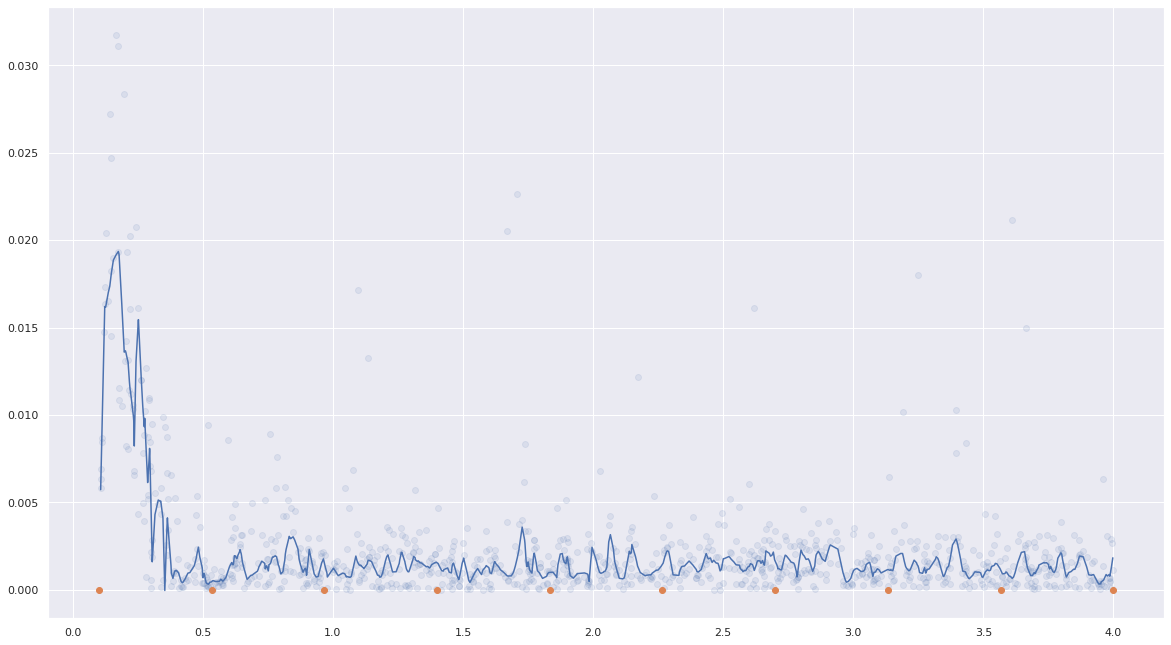

In [15]:
# Evaluate accuracy 
euler, euler_bis, c, c_RHS, w = evaluate_accuracy_TI_MC(1000, 1000, params_TI)

print("Euler TI Dense Grid")
print("Mean: {}".format(np.mean(np.abs(euler))))
print("Median: {}".format(np.median(np.abs(euler))))
print("Min: {}".format(np.min(np.abs(euler))))
print("Max: {}".format(np.max(np.abs(euler))))
print("std dev.: {}".format(np.std(np.abs(euler))))

# Should take the mean of the absolute value
print("\nEuler Bis TI Dense Grid")
print("Mean: {}".format(np.mean(np.abs(euler_bis))))
print("Median: {}".format(np.median(np.abs(euler_bis))))
print("Min: {}".format(np.min(np.abs(euler_bis))))
print("Max: {}".format(np.max(np.abs(euler_bis))))
print("std dev.: {}".format(np.std(np.abs(euler_bis))))

# Smoothed conditional mean
smoothed = lowess(euler_bis, w, frac=1./100)
plt.scatter(w, euler_bis, alpha=0.1)
plt.scatter(params_TI.w_grid, np.zeros(params_TI.n_points_w), label="grid points")
plt.plot(smoothed[:,0], smoothed[:,1])

Euler TI Dense Grid
Mean: 0.004598168397307113
Median: 0.002498147834632758
Min: 2.5480339467254254e-06
Max: 0.07185951848452321
std dev.: 0.007679827955477252

Euler Bis TI Dense Grid
Mean: 0.0023186090767303097
Median: 0.0012514190827515037
Min: 1.274014538754642e-06
Max: 0.0379899351970554
std dev.: 0.003938906939662155


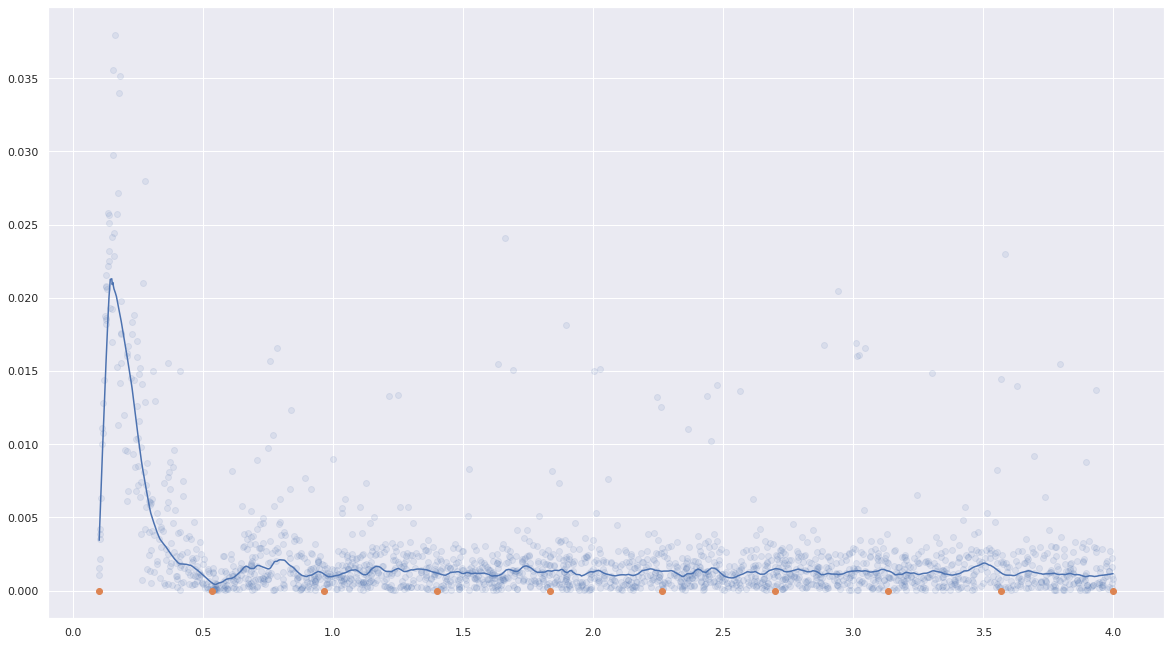

In [16]:
# Evaluate accuracy 
euler, euler_bis, c, c_RHS, w = evaluate_accuracy_TI_Gaussian(2000, params_TI)

print("Euler TI Dense Grid")
print("Mean: {}".format(np.mean(np.abs(euler))))
print("Median: {}".format(np.median(np.abs(euler))))
print("Min: {}".format(np.min(np.abs(euler))))
print("Max: {}".format(np.max(np.abs(euler))))
print("std dev.: {}".format(np.std(np.abs(euler))))

# Should take the mean of the absolute value
print("\nEuler Bis TI Dense Grid")
print("Mean: {}".format(np.mean(np.abs(euler_bis))))
print("Median: {}".format(np.median(np.abs(euler_bis))))
print("Min: {}".format(np.min(np.abs(euler_bis))))
print("Max: {}".format(np.max(np.abs(euler_bis))))
print("std dev.: {}".format(np.std(np.abs(euler_bis))))

# Smoothed conditional mean
smoothed = lowess(euler_bis, w, frac=1./50)
plt.scatter(w, euler_bis, alpha=0.1)
plt.scatter(params_TI.w_grid, np.zeros(params_TI.n_points_w), label="grid points")
plt.plot(smoothed[:,0], smoothed[:,1])

---
---

# bc-MC operator with ANNs


Use the formula:

$$ \frac{1}{M} \frac{2}{(N)(N-1)} \sum_{m=1}^{M} \sum_{1\leq i < j}^{n} f(s_m, \epsilon_{m}^{(i)})f(s_m, \epsilon_{m}^{(j)})  $$

implemented as:

$$ \frac{1}{M} \frac{2}{(N)(N-1)} f' \Big(I_N \otimes U\Big). f $$

With:

- U an upper triangular matrix filled with 1, and zeroes on the diagonal
- $I_{N,N}$ the identity matrix $M \times M$
- f a $MN\times 1$ vector:

$$ \Big(f(s_1, \varepsilon^{1}_{1}), f(s_1, \varepsilon^{2}_{1}),  ..., f(s_2, \varepsilon^{1}_{2}), ... , f(s_m, \varepsilon^{N}_{m})\Big)$$


learning rate: 0.001
nb epochs: 10000
W.shape: torch.Size([2, 4])
W_expanded.shape: torch.Size([4, 4])
M: 2
N: 2
MN: 4
T: 2
T: False
Budget constraint: 1.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act_f): ReLU()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
[2]
[2.]
[4.]
Elapsed time: 0.7150369490009325 sec.
Elapsed time: 0.06427386799987289 sec.
Speedup: 11.124847021846367 X
Elapsed time: 0.12372024900105316 sec.
Speedup: 5.779465809148555 X
N* brute force: 2


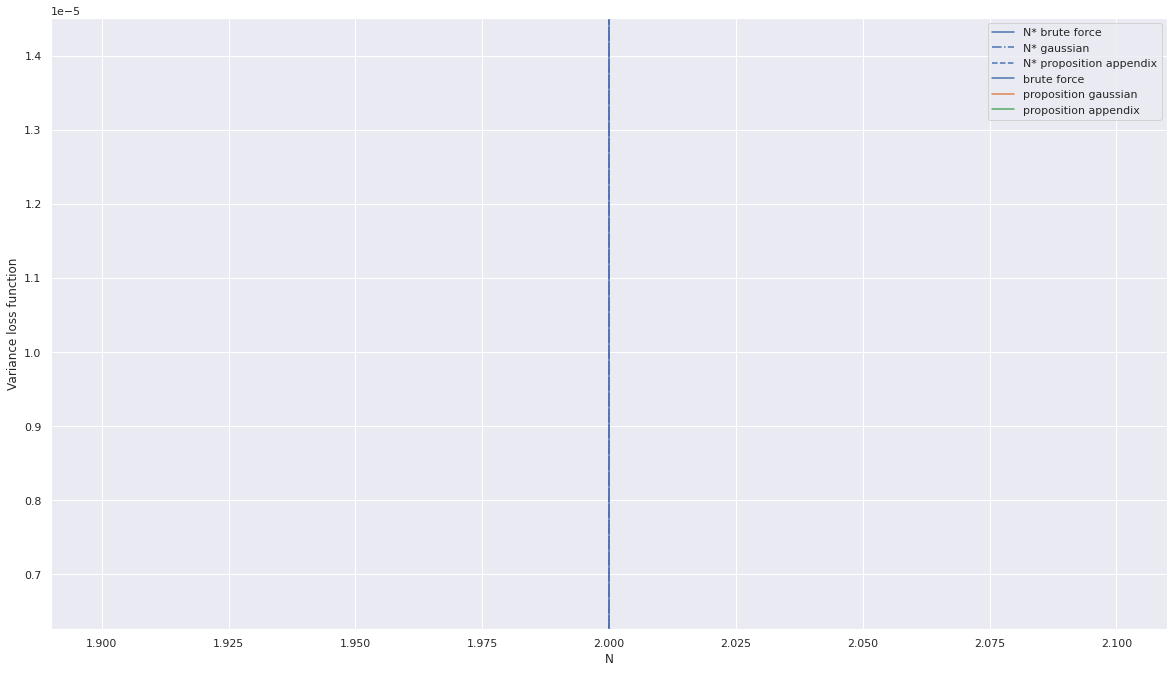

In [17]:
M_chosen = 2 #100 #100 #100 #25 #100 #200 # 50 #outer expectation 
N_chosen = 2 #8 #2 #4 # Inner expectation
lr_chosen = 1e-3 #1e-3 #0.5e-2
pre_train_model_chosen = False
nb_epochs_chosen = 10000 #10000
σ_shocks_chosen = 0.01
use_Sobol_chosen = False
optimizer_chosen = "Adam"
dim_p_chosen =  2 #Default is 2 (p and q, as in section 4.2)
# Parameters for the sparse grid
grid_depth_chosen = 3
nb_refinements_chosen = 2
surplus_threshold_chosen = 1e-4
name_params = "params_TI"
w1_chosen = 0.5
w2_chosen = 0.5

# REMARK:
# for the dense grid, to change the number of points on w-grid, change self.n_points_w = 10 
# to change the number of points for the other dimensions, change self.n_points_grid = 3
params = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen, 
                  nb_epochs_chosen, bc_chosen, order_gauss,
                  σ_shocks_chosen, use_Sobol_chosen, optimizer_chosen, 
                  dim_p_chosen, grid_depth_chosen, nb_refinements_chosen, surplus_threshold_chosen, 
                  name_params, nb_points_w=10, nb_points_other=3,
                  w1 = w1_chosen, w2 = w2_chosen)

show_params(params)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    """
    Output share of cash-on-hand consumed, and lagrange multiplier
    """
    def __init__(self, params):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.dim_state = params.dim_state
        self.nb_nodes = 32 #32 default
        self.act_f = nn.ReLU() #nn.ReLU()  #nn.ReLU() #nn.LeakyReLU() #nn.Tanh() #
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.dim_state, self.nb_nodes),
            self.act_f,
            nn.Linear(self.nb_nodes, self.nb_nodes),
            self.act_f,
            nn.Linear(self.nb_nodes, 2)
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y

model_MC = NeuralNetwork(params).to(device)
print(model_MC)

# Grid M and grid N
T = (params.M*params.N)/2
# Non-evenly spaced grid
grid_N = np.array([N for N in range(2, params.T+2, 2)])
grid_M = 2*T/grid_N

is_int = grid_M % 1 == 0
grid_N = grid_N[is_int]
grid_M = grid_M[is_int]

print(grid_N)
print(grid_M)
print(grid_N*grid_M)

# Pre-calculate list of params
# Used when optimally chosing N during training
list_params = []
for (ind, (N_chosen, M_chosen)) in enumerate(zip(grid_N, grid_M)):
    # Change M and N
    params_local = MyParams(int(N_chosen), int(M_chosen), params.lr, params.pre_train_model,
              params.nb_epochs, params.bc, params.order_gauss,
              params.σ_shocks, params.use_Sobol, params.optimizer, 
              params.dim_p, params.grid_depth, 
              params.nb_refinements, params.surplus_threshold, 
              "params", params.n_points_w, params.n_points_grid,
              params.w1, params.w2)
    list_params.append(params_local)

# Brute force
nb_draws_loss = 1000
start = timer()
var_loss_bf = calculate_variance_loss_model_grid(model_MC, params, nb_draws_loss, grid_N, grid_M)
end = timer()
elapsed_time_bf = end - start
print(f"Elapsed time: {elapsed_time_bf} sec.")

# Formulas
nb_draws = 100000
nb_draws_M = 10
nb_draws_N = int(nb_draws/nb_draws_M )

## Gaussian
start = timer()
var_loss_formula_gaussian, var_f, cov_f = calculate_variance_gaussian(params, model_MC, nb_draws, grid_M, grid_N)
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

## Appendix
start = timer()
var_loss_formula = calculate_variance_loss_fast(params, model_MC, nb_draws, grid_M, grid_N).detach()
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

arg_min_g = np.argmin(var_loss_bf)
arg_min_gaussian = np.argmin(var_loss_formula_gaussian)
arg_min_formula = np.argmin(var_loss_formula)

plt.axvline(x = grid_N[arg_min_g], label = "N* brute force", linestyle="-")
plt.axvline(x = grid_N[arg_min_gaussian], label = "N* gaussian", linestyle="-.")
plt.axvline(x = grid_N[arg_min_formula], label = "N* proposition appendix", linestyle="--")
plt.plot(grid_N, var_loss_bf, label="brute force")
plt.plot(grid_N, var_loss_formula_gaussian, label="proposition gaussian")
plt.plot(grid_N, var_loss_formula, label="proposition appendix")
plt.xlabel("N")
plt.ylabel("Variance loss function")
plt.legend()

print(f"N* brute force: {grid_N[arg_min_g]}")


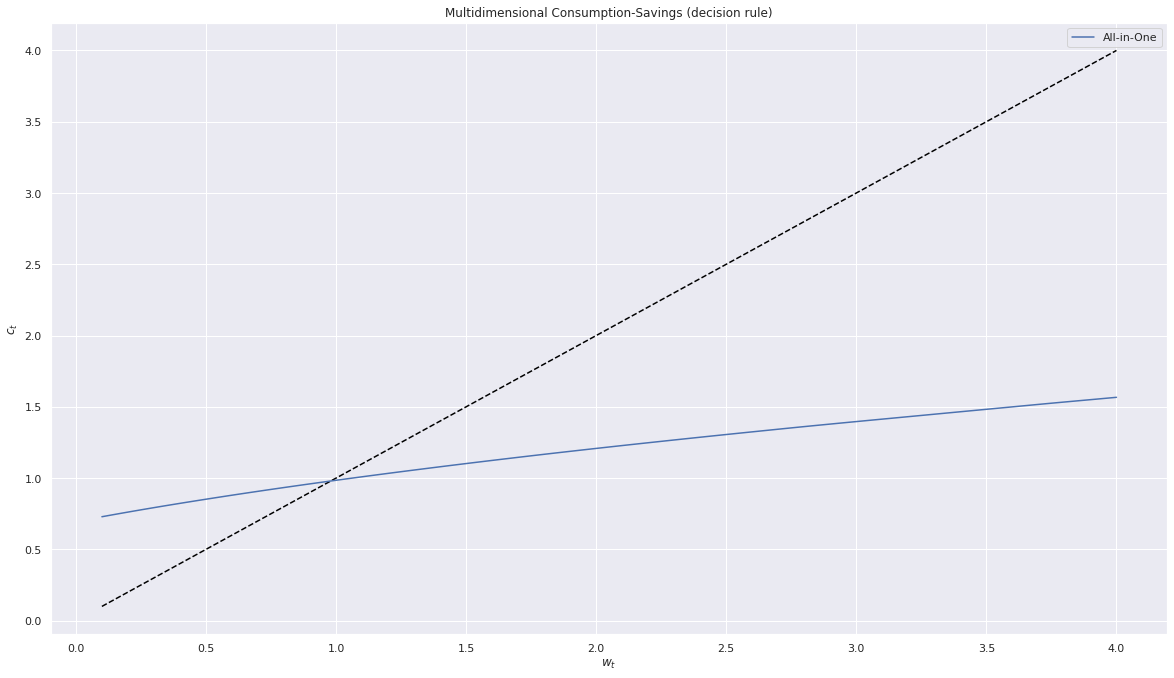

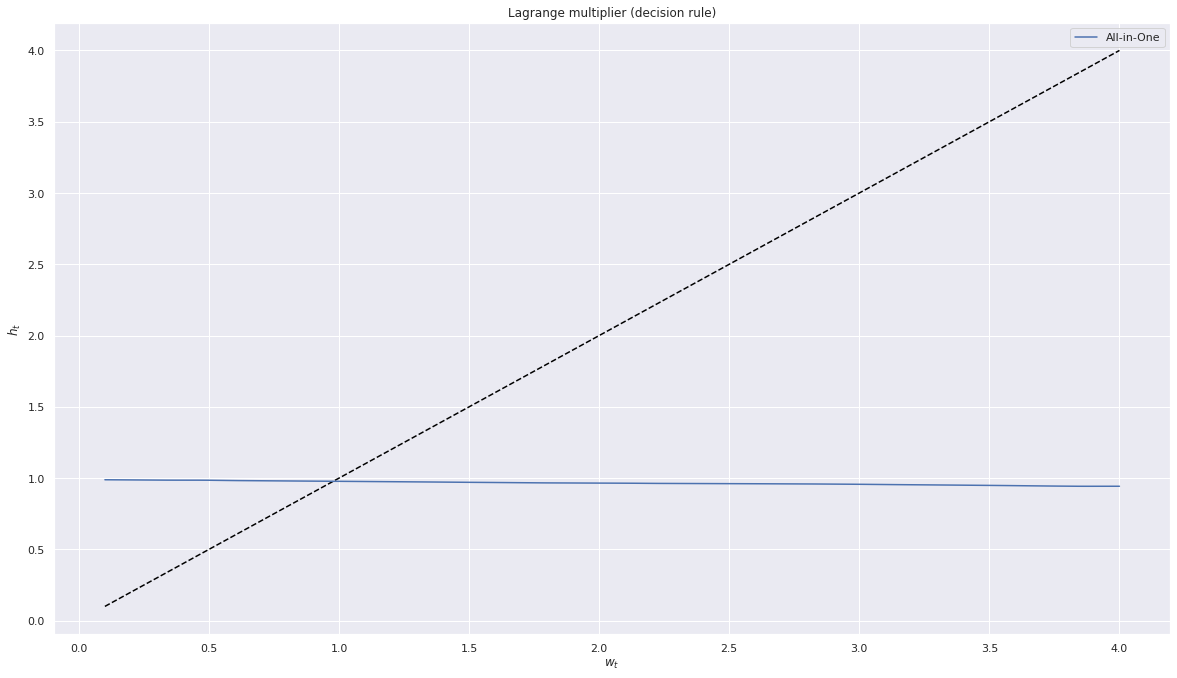

In [18]:
# Plot initial guess
model_MC.eval()

# Define the grid
nb_points = 100
with torch.no_grad():
    wvec_eval = torch.linspace(params.wmin, params.wmax, nb_points)
    rvec_eval = 0*torch.ones(nb_points) #torch.linspace(grid.σ_e_r_min, grid.σ_e_r_max, nb_points) #torch.zeros(nb_points)
    δvec_eval = 0*torch.ones(nb_points) #torch.zeros(nb_points)
    ps_vec_eval = 0*torch.ones(nb_points, params.dim_p) #torch.zeros(nb_points)

    # To store vaules
    ζvec = torch.zeros(nb_points)
    hvec = torch.zeros(nb_points)
    cvec = torch.zeros(nb_points)

    # state
    # order: w, r, delta, p1, ..., pl
    cvec, hvec = model_normalized(model_MC, wvec_eval, rvec_eval, δvec_eval, ps_vec_eval, params)

plt.title("Multidimensional Consumption-Savings (decision rule)")
plt.plot(wvec_eval, wvec_eval, linestyle='--', color='black')
plt.plot(wvec_eval.detach().numpy(), cvec.detach().numpy(), label="All-in-One")
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.legend()
plt.show()

plt.title("Lagrange multiplier (decision rule)")
plt.plot(wvec_eval, wvec_eval, linestyle='--', color='black')
plt.plot(wvec_eval.detach().numpy(), hvec.detach().numpy(), label="All-in-One")
plt.xlabel("$w_t$")
plt.ylabel("$h_t$")
plt.legend()
plt.show()

In [19]:
# Test loss function
with torch.no_grad():
    v = Ξ_torch_MC(model_MC, params)
print(v)

tensor(0.0041)


In [20]:
nb_draws = 10000 #nb draws when calculating variance of loss
seed=123
np.random.seed(seed)
torch.manual_seed(seed)

model_MC.train()

# Optimizer
optimizer = create_optimizer(model_MC, params.optimizer, params.lr, params.momentum)
# Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)

loss_epochs_MC = torch.zeros(params.nb_epochs)
list_Euler_median = [] #store median abs value percentage error
list_Euler_mean = [] #mean
list_Euler_max = [] #max
list_Euler_std = [] #std
list_Euler_i = [] #store index i
list_Euler_loss = [] #store loss
calculate_variance_loss = True # Calculate variance of loss or not
list_var_loss = [] #store variance of the loss
list_optimal_N = [] #store the optimal N
list_optimal_N_current = [] #store the current optimal N used.
optimal_N = params.N #set initial choice for N
index_best_N = np.where(grid_N == optimal_N)[0][0]
freq_var =  100 #frequency with which the variance of the loss is calculated
freq_loss = 50 #frequency with which the loss is calculated
ratio_freq_loss_freq_var = int(freq_var/freq_loss)
use_N_star = True #Vary N during training
use_exact_accuracy_metrics = True # If False, use square loss to get the EEE
min_euler_bis = float('inf')
best_model = copy.deepcopy(model_MC)

for i in tqdm(range(0, params.nb_epochs)):
    # Clear gradient
    optimizer.zero_grad()
    # params associated with the current best N:
    params_local = list_params[index_best_N]
    # Calculate loss
    loss = Ξ_torch_MC(model_MC, params_local)
    loss_epochs_MC[[i]] = float(loss.item())

    # Backpropagation
    loss.backward()
    # Avoid explosive gradients
    clip_grad_norm_(model_MC.parameters(), max_norm=1.0, error_if_nonfinite=False)
    # Gradient descent step
    optimizer.step()
    
    if i % freq_loss == 0: #Monitor accuracy
        model_MC.eval()
        list_optimal_N_current.append(optimal_N) #N used
        # Evaluate Euler error
        if use_exact_accuracy_metrics == True:
            with torch.no_grad():
                euler, euler_bis, c, c_RHS, w = evaluate_accuracy_pytorch_MC_frozen(model_MC, params_local)
            list_Euler_median.append(np.median(euler_bis))
            list_Euler_mean.append(np.mean(euler_bis))
            list_Euler_max.append(np.max(euler_bis))
            list_Euler_std.append(np.std(euler_bis))
        # Square root of loss function
        else:
            EEE = float(loss.item())**0.5
            list_Euler_mean.append(EEE)
        list_Euler_i.append(i) #Index
        list_Euler_loss.append(float(loss.item())) #loss
        model_MC.train()
        # Check if current model is better
        mean_euler_bis = np.mean(euler_bis)
        if mean_euler_bis < min_euler_bis:
            min_euler_bis = mean_euler_bis
            best_model = copy.deepcopy(model_MC)
    # Calculation of variance of the loss and optimal choice for N
    if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
        var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_MC, nb_draws, grid_M, grid_N)
        if use_N_star == False:
            index_best_N_dummy = np.argmin(var_loss_formula)
            optimal_N_dummy = grid_N[index_best_N_dummy] #Do not modify optimal_N
            list_optimal_N.append(optimal_N_dummy)
            list_var_loss.append(var_loss_formula[index_best_N])
        # When N* algo is used, update the value of N during training
        else:
            # Gaussian formula
            index_best_N = np.argmin(var_loss_formula)
            # Var/Cov
            #N_star_theory = 1 + np.abs(var_f/cov_f)
            #index_best_N = np.argmin(np.abs(N_star_theory - grid_N)) #project on grid
            optimal_N = grid_N[index_best_N]
            list_optimal_N.append(optimal_N)
            list_var_loss.append(var_loss_formula[index_best_N])
    if i % 1000 == 0:
        loss, current = float(loss.item()), i
        print(f"loss: {loss:>7f}, N used: {list_optimal_N_current[-1]}, N*: {list_optimal_N[-1]}, mean euler error {list_Euler_mean[-1]:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
    if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
        scheduler.step()
        print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

if params.optimizer == "SWA":
    optimizer.swap_swa_sgd()


  1%|▏                                      | 51/10000 [00:00<00:47, 210.67it/s]

loss: 0.000901, N used: 2, N*: 2, mean euler error 0.028858, [    0/10000]


 10%|███▊                                 | 1047/10000 [00:04<00:33, 267.61it/s]

loss: -0.000001, N used: 2, N*: 2, mean euler error 0.009431, [ 1000/10000]


 21%|███████▌                             | 2059/10000 [00:08<00:31, 252.70it/s]

loss: 0.001219, N used: 2, N*: 2, mean euler error 0.005801, [ 2000/10000]


 31%|███████████▎                         | 3060/10000 [00:11<00:27, 249.94it/s]

loss: 0.000296, N used: 2, N*: 2, mean euler error 0.005147, [ 3000/10000]


 40%|██████████████▉                      | 4046/10000 [00:15<00:19, 299.86it/s]

loss: 0.000207, N used: 2, N*: 2, mean euler error 0.005169, [ 4000/10000]


 50%|██████████████████▋                  | 5048/10000 [00:19<00:17, 282.70it/s]

loss: 0.000963, N used: 2, N*: 2, mean euler error 0.004750, [ 5000/10000]


 61%|██████████████████████▍              | 6051/10000 [00:23<00:16, 244.52it/s]

loss: -0.000157, N used: 2, N*: 2, mean euler error 0.004523, [ 6000/10000]


 71%|██████████████████████████           | 7051/10000 [00:27<00:11, 246.56it/s]

loss: 0.000583, N used: 2, N*: 2, mean euler error 0.004630, [ 7000/10000]


 80%|█████████████████████████████▋       | 8032/10000 [00:31<00:07, 265.82it/s]

loss: 0.000410, N used: 2, N*: 2, mean euler error 0.004232, [ 8000/10000]


 91%|█████████████████████████████████▍   | 9051/10000 [00:35<00:03, 246.25it/s]

loss: 0.000289, N used: 2, N*: 2, mean euler error 0.004000, [ 9000/10000]


100%|████████████████████████████████████| 10000/10000 [00:38<00:00, 256.92it/s]


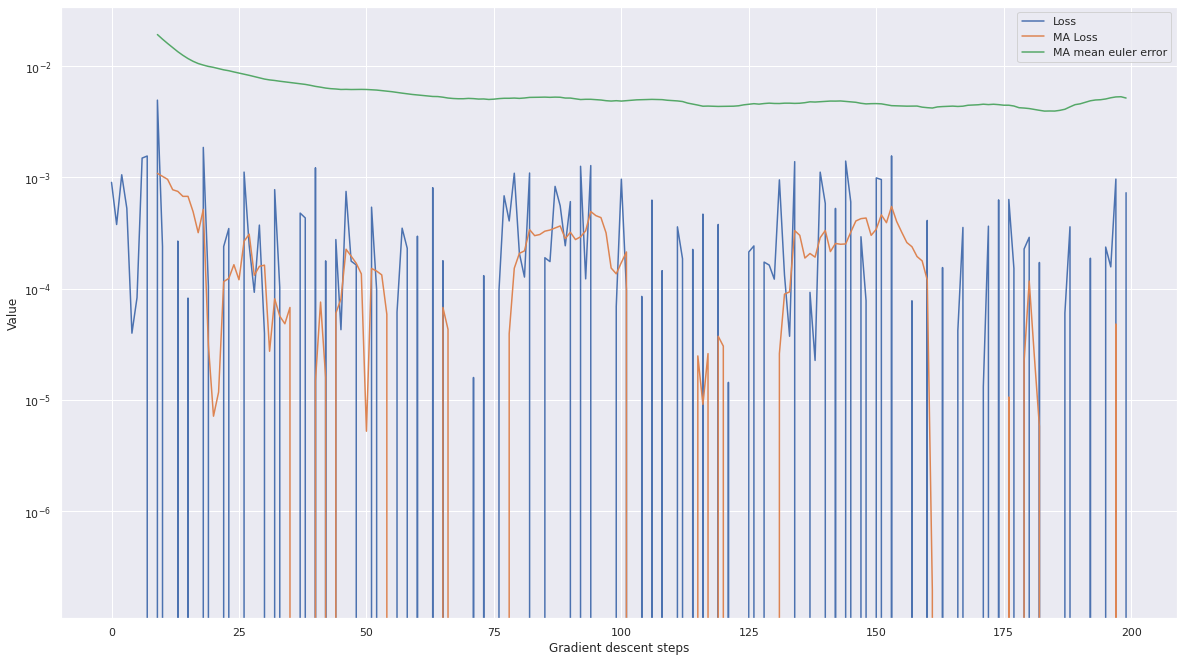

In [21]:
rate = 10
plt.plot(list_Euler_loss, label="Loss")
plt.plot(pd.Series(list_Euler_loss).rolling(rate).mean(), label="MA Loss")
plt.plot(pd.Series(list_Euler_mean).rolling(rate).mean(), label="MA mean euler error")
plt.xlabel("Gradient descent steps")
plt.ylabel("Value")
plt.yscale('log')
plt.legend()

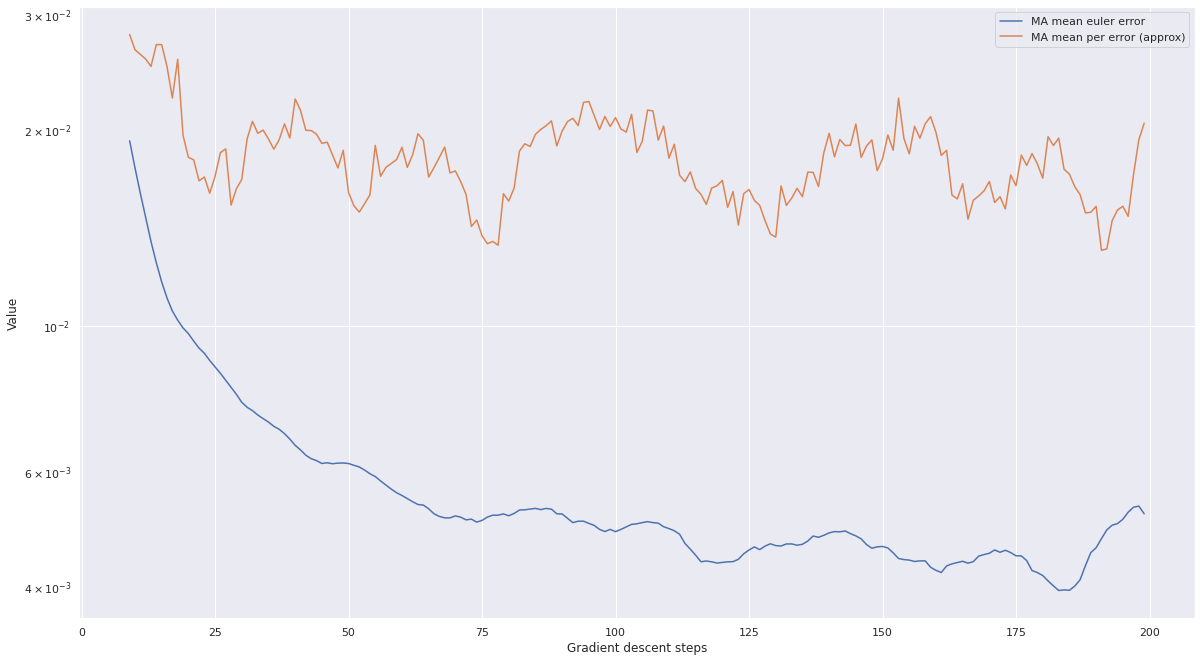

In [22]:
# Checking that the square root of the loss is a good approx of the Expected euler equation error
plt.plot(pd.Series(list_Euler_mean).rolling(rate).mean(), label="MA mean euler error")
plt.plot(pd.Series(np.sqrt(np.abs(list_Euler_loss))).rolling(rate).mean(), label="MA mean per error (approx)")
plt.xlabel("Gradient descent steps")
plt.ylabel("Value")
plt.yscale('log')
plt.legend()

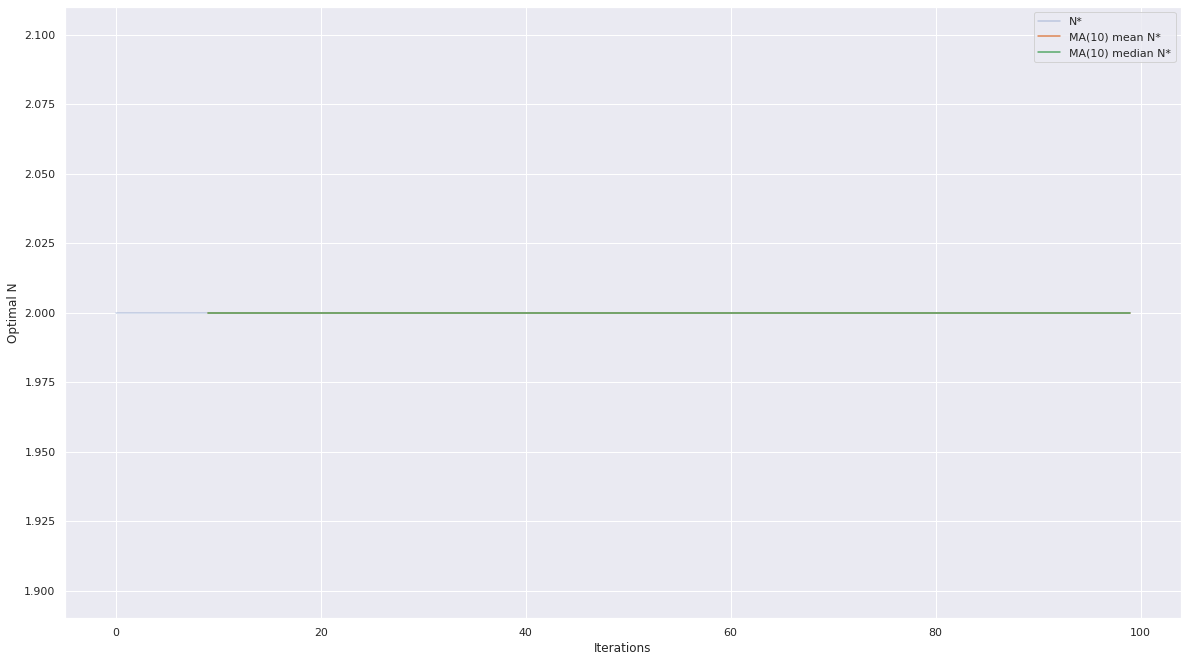

In [23]:
rate_rolling = 10
max_N = len(list_optimal_N)
plt.plot(pd.Series(list_optimal_N[:max_N]), label="N*", alpha=0.3)
plt.plot(pd.Series(list_optimal_N[:max_N]).rolling(rate_rolling).mean(), label=f"MA({rate_rolling}) mean N*")
plt.plot(pd.Series(list_optimal_N[:max_N]).rolling(rate_rolling).median(), label=f"MA({rate_rolling}) median N*")
plt.xlabel("Iterations")
plt.ylabel("Optimal N")
plt.legend()

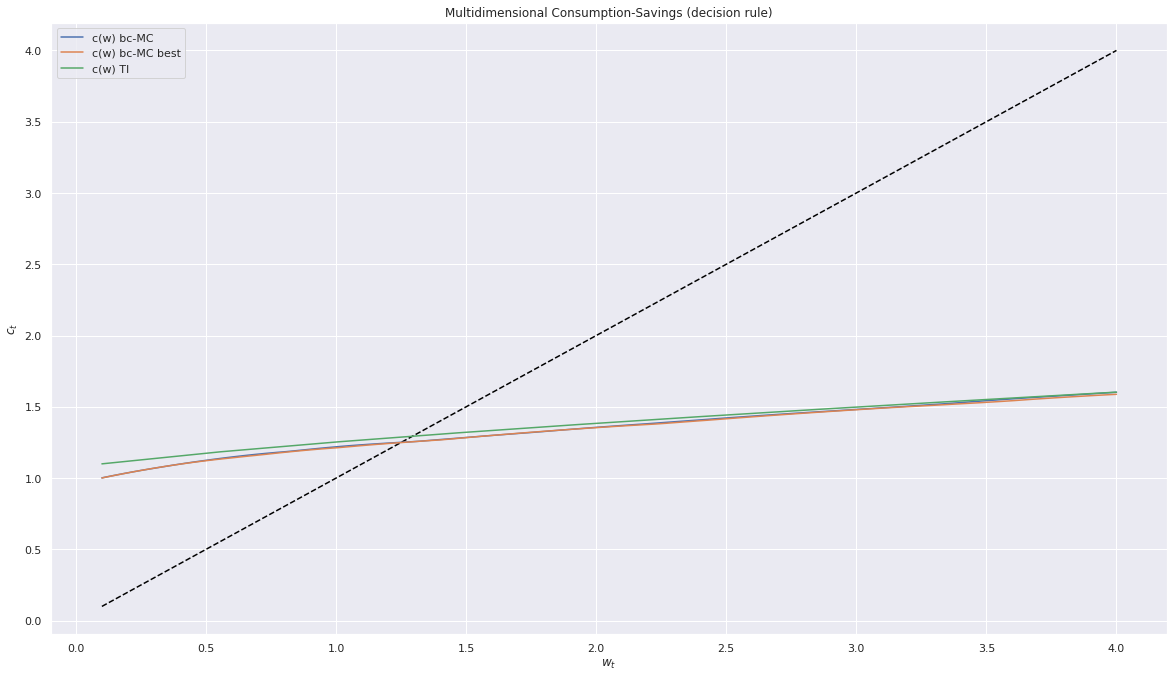

In [24]:
# Test approximation
model_MC.eval()

# Define the grid
nb_points = 100
with torch.no_grad():
    wvec_eval = torch.linspace(params.wmin, params.wmax, nb_points)
    rvec_eval = 0*torch.ones(nb_points) #torch.linspace(grid.σ_e_r_min, grid.σ_e_r_max, nb_points) #torch.zeros(nb_points)
    ps_vec_eval = 0*torch.ones(nb_points, params.dim_p) #torch.zeros(nb_points)
    δvec_eval = 0*torch.ones(nb_points) #torch.zeros(nb_points)

    # To store vaules
    ζvec = torch.zeros(nb_points)
    hvec = torch.zeros(nb_points)
    cvec = torch.zeros(nb_points)

    # state
    # order: w, r, delta, p1, ..., pl
    cvec_MC, hvec_MC = model_normalized(model_MC, wvec_eval, rvec_eval, δvec_eval, ps_vec_eval, params)
    # best model
    cvec_MC_best, hvec_MC_best = model_normalized(best_model, wvec_eval, rvec_eval, δvec_eval, ps_vec_eval, params)
    
    # Save for latter use
    cvec_MC_bc_0, hvec_MC_bc_0 = cvec_MC.detach().numpy(), hvec_MC.detach().numpy()
    cvec_MC_best_bc_0, hvec_MC_best_bc_0 = cvec_MC_best.detach().numpy(), hvec_MC_best.detach().numpy()

plt.title("Multidimensional Consumption-Savings (decision rule)")
plt.plot(wvec_eval, wvec_eval, linestyle='--', color='black')
plt.plot(wvec_eval.detach().numpy(), cvec_MC.detach().numpy(), label="c(w) bc-MC")
plt.plot(wvec_eval.detach().numpy(), cvec_MC_best.detach().numpy(), label="c(w) bc-MC best")
plt.plot(params_TI.xvec_test, cvec_TI_bc_0, label='c(w) TI')
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.legend()

### Accuracy

Euler MC
Mean: 0.007927484810352325
Median: 0.00645214319229126
Min: 2.2649765014648438e-06
Max: 0.06285375356674194
std dev.: 0.007337300572544336
Euler Bis MC
Mean: 0.003975817002356052
Median: 0.003222256898880005
Min: 1.0728836059570312e-06
Max: 0.032990455627441406
std dev.: 0.0037458038423210382


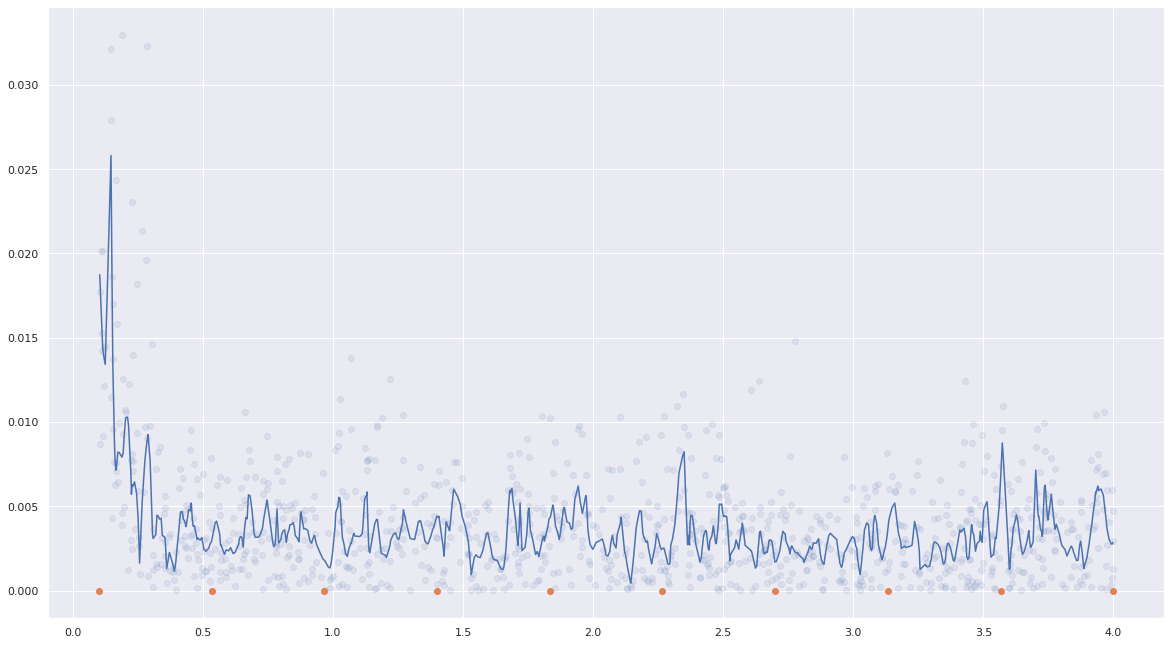

In [25]:
model_MC.eval()

# Evaluate accuracy 
euler, euler_bis, c, c_RHS, w = evaluate_accuracy_pytorch_MC(model_MC, 1000, 1000, params)

print("Euler MC")
print("Mean: {}".format(np.mean(np.abs(euler))))
print("Median: {}".format(np.median(np.abs(euler))))
print("Min: {}".format(np.min(np.abs(euler))))
print("Max: {}".format(np.max(np.abs(euler))))
print("std dev.: {}".format(np.std(np.abs(euler))))

# Should take the mean of the absolute value
print("Euler Bis MC")
print("Mean: {}".format(np.mean(np.abs(euler_bis))))
print("Median: {}".format(np.median(np.abs(euler_bis))))
print("Min: {}".format(np.min(np.abs(euler_bis))))
print("Max: {}".format(np.max(np.abs(euler_bis))))
print("std dev.: {}".format(np.std(np.abs(euler_bis))))

# Smoothed conditional mean
smoothed = lowess(euler_bis, w, frac=1./100)
plt.scatter(w, euler_bis, alpha=0.1)
plt.scatter(params_TI.w_grid, np.zeros(len(params_TI.w_grid)), label="grid points")
plt.plot(smoothed[:,0], smoothed[:,1])

Euler MC
Mean: 0.007701312657445669
Median: 0.006122291088104248
Min: 2.980232238769531e-07
Max: 0.07345813512802124
std dev.: 0.0070353406481444836
Euler Bis MC
Mean: 0.0038552600890398026
Median: 0.0030549466609954834
Min: 1.1920928955078125e-07
Max: 0.03888511657714844
std dev.: 0.00358188315294683


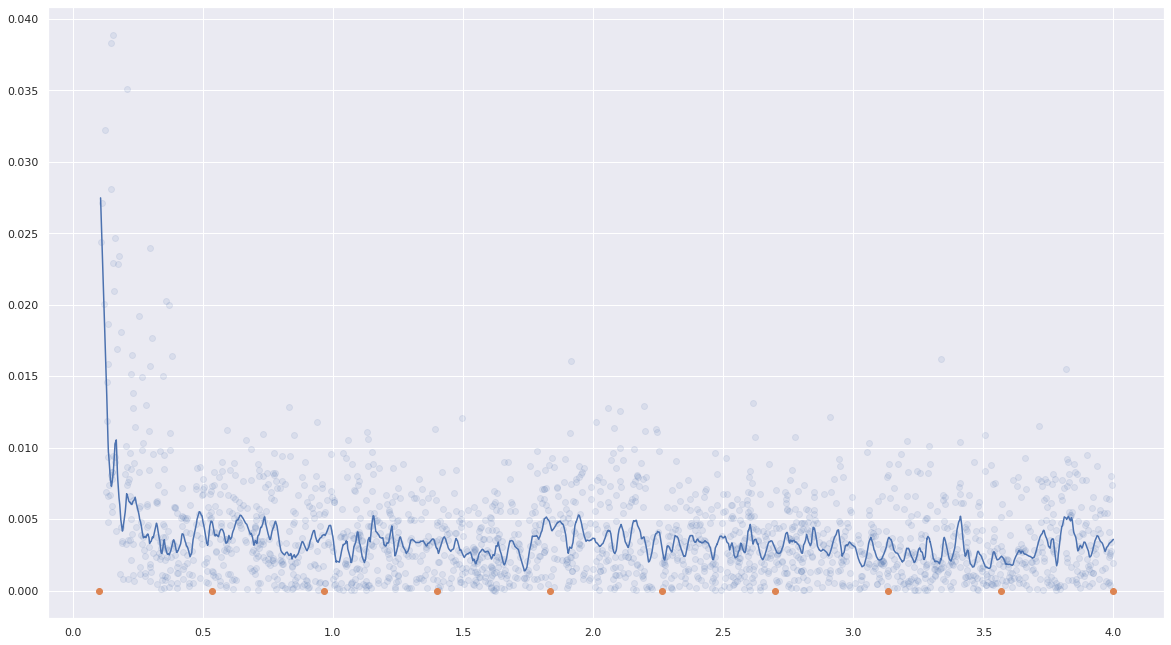

In [26]:
model_MC.eval()

# Evaluate accuracy 
euler, euler_bis, c, c_RHS, w = evaluate_accuracy_pytorch_Gaussian(model_MC, 2000, params)

print("Euler MC")
print("Mean: {}".format(np.mean(np.abs(euler))))
print("Median: {}".format(np.median(np.abs(euler))))
print("Min: {}".format(np.min(np.abs(euler))))
print("Max: {}".format(np.max(np.abs(euler))))
print("std dev.: {}".format(np.std(np.abs(euler))))

# Should take the mean of the absolute value
print("Euler Bis MC")
print("Mean: {}".format(np.mean(np.abs(euler_bis))))
print("Median: {}".format(np.median(np.abs(euler_bis))))
print("Min: {}".format(np.min(np.abs(euler_bis))))
print("Max: {}".format(np.max(np.abs(euler_bis))))
print("std dev.: {}".format(np.std(np.abs(euler_bis))))

# Smoothed conditional mean
smoothed = lowess(euler_bis, w, frac=1./100)
plt.scatter(w, euler_bis, alpha=0.1)
plt.scatter(params_TI.w_grid, np.zeros(len(params_TI.w_grid)), label="grid points")
plt.plot(smoothed[:,0], smoothed[:,1])

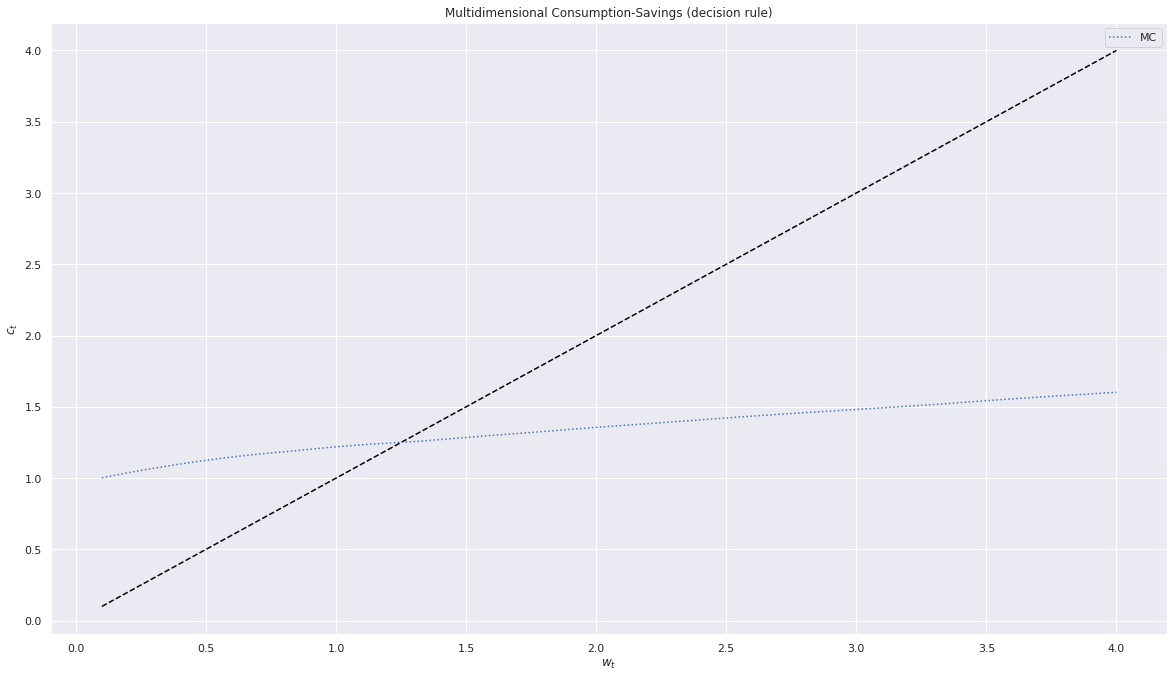

In [27]:
# Test approximation
model_MC.eval()

# Define the grid
nb_points = 100
with torch.no_grad():
    wvec_eval = torch.linspace(params.wmin, params.wmax, nb_points)
    #wvec_eval = torch.linspace(0.8, 1.2, nb_points)
    rvec_eval = 0*torch.ones(nb_points) #torch.linspace(grid.σ_e_r_min, grid.σ_e_r_max, nb_points) #torch.zeros(nb_points)
    δvec_eval = 0*torch.ones(nb_points) #torch.zeros(nb_points)

    ps_vec_eval = 0*torch.ones(nb_points, params.dim_p) #torch.zeros(nb_points)

    # To store vaules
    ζvec = torch.zeros(nb_points)
    hvec = torch.zeros(nb_points)
    cvec = torch.zeros(nb_points)

    # state
    # order: w, r, delta, p1, ..., pl
    cvec_MC, hvec_MC = model_normalized(model_MC, wvec_eval, rvec_eval, δvec_eval, ps_vec_eval, params)
    
plt.title("Multidimensional Consumption-Savings (decision rule)")
plt.plot(wvec_eval, wvec_eval, linestyle='--', color='black')
plt.plot(wvec_eval.detach().numpy(), cvec_MC.detach().numpy(), label="MC", linestyle='dotted')
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.legend()

Elapsed time: 0.748013467000419 sec.
Elapsed time: 0.051598766000097385 sec.
Speedup: 14.496731704766104 X
Elapsed time: 0.09522691300298902 sec.
Speedup: 7.85506369377888 X
N* brute force: 2


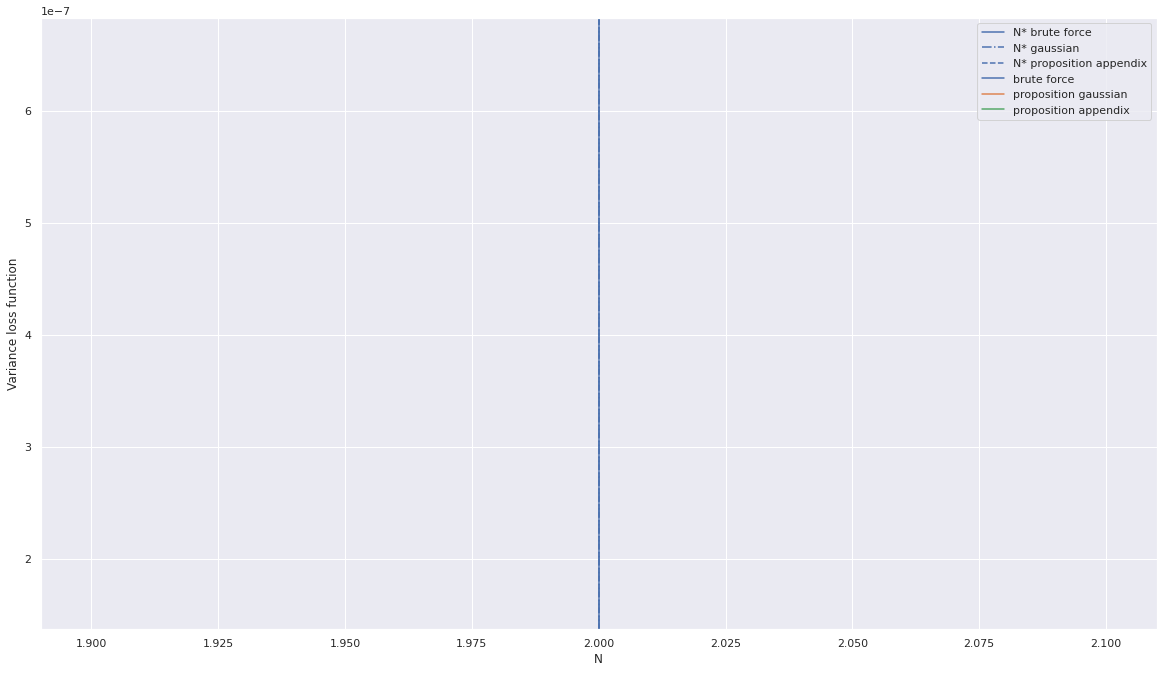

In [28]:
# Brute force
nb_draws_loss = 1000
start = timer()
var_loss_bf = calculate_variance_loss_model_grid(model_MC, params, nb_draws_loss, grid_N, grid_M)
end = timer()
elapsed_time_bf = end - start
print(f"Elapsed time: {elapsed_time_bf} sec.")

# Formulas
nb_draws = 100000
nb_draws_M = 10
nb_draws_N = int(nb_draws/nb_draws_M )

## Gaussian
start = timer()
var_loss_formula_gaussian, var_f, cov_f = calculate_variance_gaussian(params, model_MC, nb_draws, grid_M, grid_N)
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

## Appendix
start = timer()
var_loss_formula = calculate_variance_loss_fast(params, model_MC, nb_draws, grid_M, grid_N).detach()
end = timer()
elapsed_time_f4 = end - start
print(f"Elapsed time: {elapsed_time_f4} sec.")
print(f"Speedup: {elapsed_time_bf/elapsed_time_f4} X")

arg_min_g = np.argmin(var_loss_bf)
arg_min_gaussian = np.argmin(var_loss_formula_gaussian)
arg_min_formula = np.argmin(var_loss_formula)

plt.axvline(x = grid_N[arg_min_g], label = "N* brute force", linestyle="-")
plt.axvline(x = grid_N[arg_min_gaussian], label = "N* gaussian", linestyle="-.")
plt.axvline(x = grid_N[arg_min_formula], label = "N* proposition appendix", linestyle="--")
plt.plot(grid_N, var_loss_bf, label="brute force")
plt.plot(grid_N, var_loss_formula_gaussian, label="proposition gaussian")
plt.plot(grid_N, var_loss_formula, label="proposition appendix")
plt.xlabel("N")
plt.ylabel("Variance loss function")
plt.legend()

print(f"N* brute force: {grid_N[arg_min_g]}")


### Plot bc-MC and dense grid

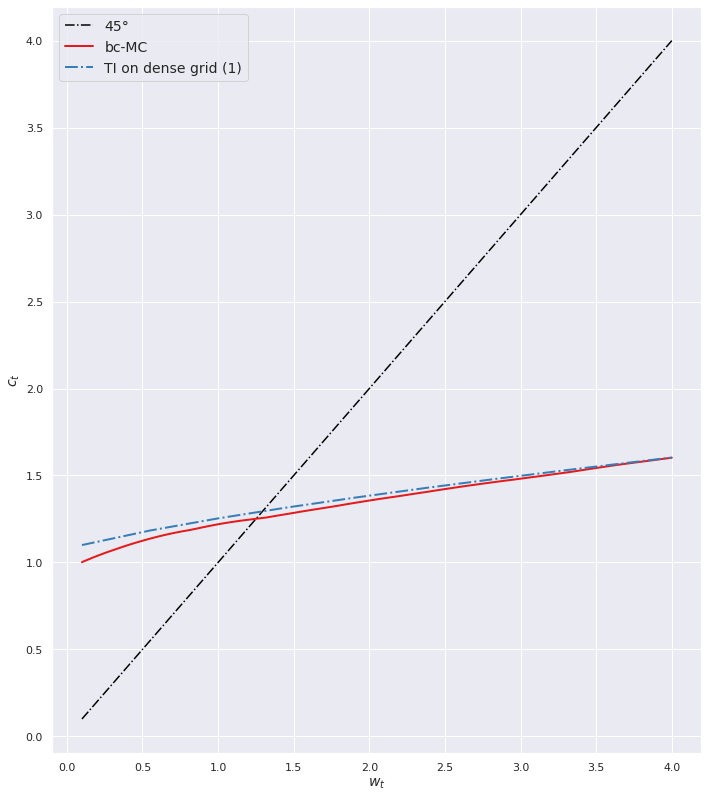

In [29]:
colors = sns.color_palette("Set1", 3)

fig, (ax1) = plt.subplots(1, figsize = (0.5*plot_scale*16, plot_scale*9))

color_bc_1 = "green"
color_bc_0 = "blue"
plt.rcParams['legend.fontsize'] = MEDIUM_SIZE

ax1.plot(wvec_eval, wvec_eval, linestyle='-.', color='black', label="45°")
ax1.plot(wvec_eval.detach().numpy(), cvec_MC_bc_0, label="bc-MC", color=colors[0], linewidth=linewidth_chosen)
ax1.plot(params_TI.xvec_test, cvec_TI_bc_0, label="TI on dense grid (1)", color=colors[1], linestyle="-.", linewidth=linewidth_chosen)
ax1.set_xlabel("$w_t$",size=MEDIUM_SIZE)
ax1.set_ylabel("$c_t$",size=MEDIUM_SIZE)
ax1.legend()

fig.tight_layout()
plt.show()

---

# Hyperparameters

##  Test hyperparameters with a single loop

### A. Vary M, no optimal N*

In [30]:
# Options
# Nb repetition, holding hyperparams constant
nb_reps = 2 #10 #10 #50 #50 #4 #10 #50 #20 #Number of times I run independent SGD, holding constant the initial parameters of the NN.
nb_epochs_chosen = 5000 #10000 #5000 #10000 #nb SGD itetations #5000
nb_draws = 10000 #nb draws when calculating variance of loss

Starting analysis 1. Keeping N = 2.
T: [1, 10, 100, 1000]
M: [1, 10, 100, 1000]
N: [2, 2, 2, 2]
N_star: [False, False, False, False]
[   1.   10.  100. 1000.]
0.9664535356921388
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([1, 2])
W_expanded.shape: torch.Size([2, 2])
M: 1
N: 2
MN: 2
T: 1
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[2]
[1.]
[2.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.010317, mean euler error 0.101574, [    0/ 5000]
N: 2 loss: 0.224490, mean euler error 0.473803, [ 1000/ 5000]
N: 2 loss: 0.020314, mean euler error 0.142527, [ 2000/ 5000]
N: 2 loss: 0.000041, mean euler error 0.006440, [ 3000/ 5000]
N: 2 loss: 0.008630, mean euler error 0.092895, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:12<00:12, 12.79s/it]

N: 2 loss: 0.019476, mean euler error 0.139556, [    0/ 5000]
N: 2 loss: 0.001111, mean euler error 0.033327, [ 1000/ 5000]
N: 2 loss: 0.011637, mean euler error 0.107875, [ 2000/ 5000]
N: 2 loss: 0.001325, mean euler error 0.036395, [ 3000/ 5000]
N: 2 loss: 0.005632, mean euler error 0.075045, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:26<00:00, 13.21s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.010317          0.101574          2  0.106893  0.003626
1           0    10  0.187821          0.433383          2  0.106893  0.043633
2           0    20  0.039858          0.199644          2  0.000513  0.064703
3           0    30  0.054355          0.233142          2  0.000513  0.092445
4           0    40  0.003390          0.058221          2  0.000431  0.112676
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([10, 20])
W_expanded.shape: torch.Size([20, 20])
M: 10
N: 2
MN: 20
T: 10
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[ 2  4 10]
[10.  5.  2.]
[20. 20. 20.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.092012, mean euler error 0.303335, [    0/ 5000]
N: 2 loss: 0.002141, mean euler error 0.046275, [ 1000/ 5000]
N: 2 loss: 0.001097, mean euler error 0.033114, [ 2000/ 5000]
N: 2 loss: 0.002681, mean euler error 0.051778, [ 3000/ 5000]
N: 2 loss: 0.000743, mean euler error 0.027251, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:13<00:13, 13.67s/it]

N: 2 loss: 0.089085, mean euler error 0.298472, [    0/ 5000]
N: 2 loss: 0.001875, mean euler error 0.043300, [ 1000/ 5000]
N: 2 loss: 0.018788, mean euler error 0.137068, [ 2000/ 5000]
N: 2 loss: 0.001526, mean euler error 0.039064, [ 3000/ 5000]
N: 2 loss: 0.003174, mean euler error 0.056340, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:26<00:00, 13.23s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092012          0.303335          2  0.000241  0.003501
1           0    10  0.033526          0.183101          2  0.000241  0.036261
2           0    20  0.029533          0.171852          2  0.000047  0.061306
3           0    30  0.011368          0.106623          2  0.000047  0.094745
4           0    40  0.010264          0.101309          2  0.000009  0.119546
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000212, mean euler error 0.014552, [ 1000/ 5000]
N: 2 loss: 0.000190, mean euler error 0.013777, [ 2000/ 5000]
N: 2 loss: 0.000206, mean euler error 0.014365, [ 3000/ 5000]
N: 2 loss: 0.000219, mean euler error 0.014814, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:16<00:16, 16.16s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000188, mean euler error 0.013697, [ 1000/ 5000]
N: 2 loss: 0.000159, mean euler error 0.012595, [ 2000/ 5000]
N: 2 loss: 0.000365, mean euler error 0.019100, [ 3000/ 5000]
N: 2 loss: 0.000456, mean euler error 0.021362, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:32<00:00, 16.19s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.065064          0.255077          2  4.682264e-05   
1           0    10  0.036261          0.190422          2  4.682264e-05   
2           0    20  0.018598          0.136374          2  9.474188e-07   
3           0    30  0.010414          0.102050          2  9.474188e-07   
4           0    40  0.007153          0.084577          2  2.276535e-07   

       time  
0  0.013911  
1  0.053498  
2  0.081391  
3  0.115627  
4  0.142815  
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([1000, 2000])
W_expanded.shape: torch.Size([2000, 2000])
M: 1000
N: 2
MN: 2000
T: 1000
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[   2    4    8   10   16   20   40   50   80  100  200  250  400  500
 1000]
[1000.  500.  250.  200.  125.  100.   

  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.066388, mean euler error 0.257658, [    0/ 5000]
N: 2 loss: 0.000107, mean euler error 0.010362, [ 1000/ 5000]
N: 2 loss: 0.000298, mean euler error 0.017274, [ 2000/ 5000]
N: 2 loss: 0.000073, mean euler error 0.008520, [ 3000/ 5000]
N: 2 loss: 0.000104, mean euler error 0.010215, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.69s/it]

N: 2 loss: 0.119205, mean euler error 0.345260, [    0/ 5000]
N: 2 loss: 0.000108, mean euler error 0.010414, [ 1000/ 5000]
N: 2 loss: 0.000101, mean euler error 0.010070, [ 2000/ 5000]
N: 2 loss: 0.000072, mean euler error 0.008488, [ 3000/ 5000]
N: 2 loss: 0.000111, mean euler error 0.010534, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.20s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.066388          0.257658          2  5.130841e-06   
1           0    10  0.028171          0.167842          2  5.130841e-06   
2           0    20  0.017534          0.132415          2  1.990917e-07   
3           0    30  0.010083          0.100416          2  1.990917e-07   
4           0    40  0.007498          0.086588          2  1.287639e-08   

       time  
0  0.015289  
1  0.060099  
2  0.097734  
3  0.141249  
4  0.178968  
    bc optim    lr  N     M     T  N_star
0  0.0  Adam  0.05  2     1     1   False
1  0.0  Adam  0.05  2    10    10   False
2  0.0  Adam  0.05  2   100   100   False
3  0.0  Adam  0.05  2  1000  1000   False


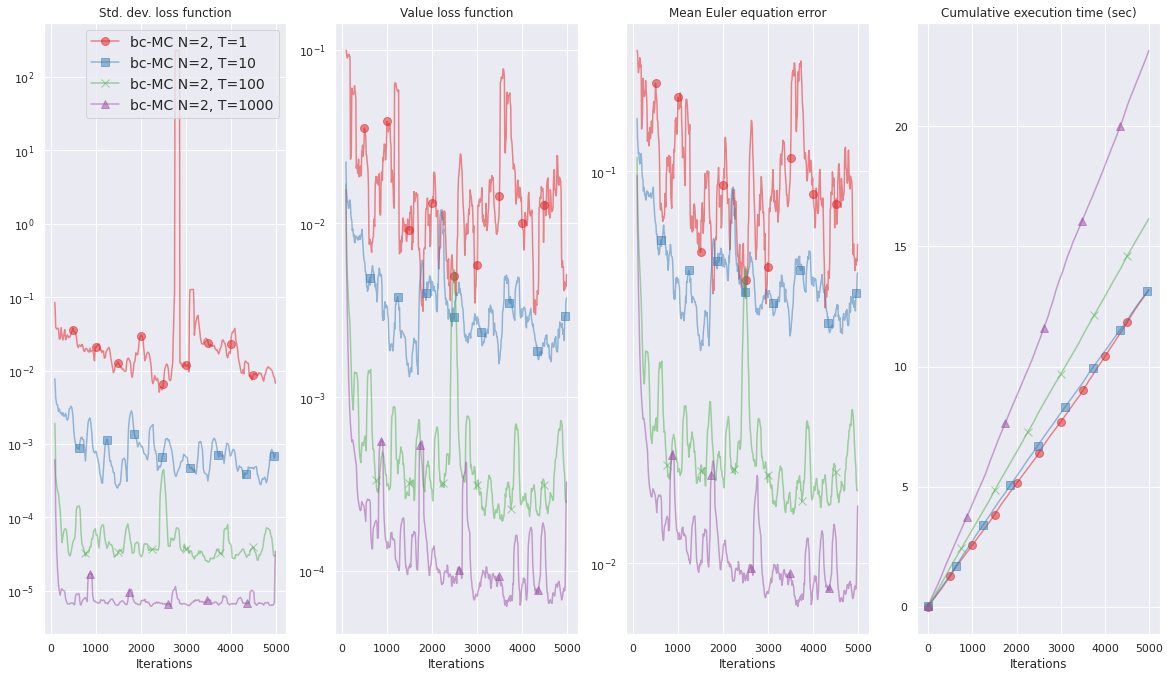

learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([1, 2])
W_expanded.shape: torch.Size([2, 2])
M: 1
N: 2
MN: 2
T: 1
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[2]
[1.]
[2.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.010317, mean euler error 0.101574, [    0/ 5000]
N: 2 loss: 0.074904, mean euler error 0.273687, [ 1000/ 5000]
N: 2 loss: 0.002417, mean euler error 0.049162, [ 2000/ 5000]
N: 2 loss: 0.003610, mean euler error 0.060079, [ 3000/ 5000]
N: 2 loss: -0.000094, mean euler error 0.000000+0.009686j, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:12<00:12, 12.53s/it]

N: 2 loss: 0.019476, mean euler error 0.139556, [    0/ 5000]
N: 2 loss: 0.000255, mean euler error 0.015964, [ 1000/ 5000]
N: 2 loss: 0.004768, mean euler error 0.069051, [ 2000/ 5000]
N: 2 loss: 0.001078, mean euler error 0.032831, [ 3000/ 5000]
N: 2 loss: -0.000506, mean euler error 0.000000+0.022503j, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:27<00:00, 13.62s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.010317          0.101574          2  0.007531  0.003736
1           0    10  0.090301          0.300502          2  0.007531  0.038241
2           0    20  0.053778          0.231902          2  0.003663  0.061480
3           0    30  0.019021          0.137916          2  0.003663  0.092422
4           0    40  0.002634          0.051323          2  0.000463  0.113911
learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([10, 20])
W_expanded.shape: torch.Size([20, 20])
M: 10
N: 2
MN: 20
T: 10
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[ 2  4 10]
[10.  5.  2.]
[20. 20. 20.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.092012, mean euler error 0.303335, [    0/ 5000]
N: 2 loss: 0.000355, mean euler error 0.018845, [ 1000/ 5000]
N: 2 loss: 0.000391, mean euler error 0.019780, [ 2000/ 5000]
N: 2 loss: 0.002038, mean euler error 0.045147, [ 3000/ 5000]
N: 2 loss: 0.000311, mean euler error 0.017636, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:15<00:15, 15.73s/it]

N: 2 loss: 0.089085, mean euler error 0.298472, [    0/ 5000]
N: 2 loss: 0.002464, mean euler error 0.049643, [ 1000/ 5000]
N: 2 loss: 0.000453, mean euler error 0.021277, [ 2000/ 5000]
N: 2 loss: 0.000209, mean euler error 0.014474, [ 3000/ 5000]
N: 2 loss: 0.000057, mean euler error 0.007568, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:29<00:00, 14.69s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092012          0.303335          2  0.000569  0.004076
1           0    10  0.016476          0.128358          2  0.000569  0.047001
2           0    20  0.019671          0.140255          2  0.000035  0.072305
3           0    30  0.009141          0.095609          2  0.000035  0.102443
4           0    40  0.012272          0.110779          2  0.000011  0.125881
learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000242, mean euler error 0.015559, [ 1000/ 5000]
N: 2 loss: 0.000181, mean euler error 0.013459, [ 2000/ 5000]
N: 2 loss: 0.000160, mean euler error 0.012634, [ 3000/ 5000]
N: 2 loss: 0.000707, mean euler error 0.026591, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.01s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000098, mean euler error 0.009915, [ 1000/ 5000]
N: 2 loss: 0.000162, mean euler error 0.012724, [ 2000/ 5000]
N: 2 loss: 0.000316, mean euler error 0.017780, [ 3000/ 5000]
N: 2 loss: 0.000341, mean euler error 0.018469, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.56s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.065064          0.255077          2  4.302299e-05   
1           0    10  0.024260          0.155756          2  4.302299e-05   
2           0    20  0.018878          0.137398          2  1.009462e-06   
3           0    30  0.011454          0.107024          2  1.009462e-06   
4           0    40  0.008719          0.093373          2  3.742586e-07   

       time  
0  0.013747  
1  0.052353  
2  0.085237  
3  0.124672  
4  0.159207  
learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([1000, 2000])
W_expanded.shape: torch.Size([2000, 2000])
M: 1000
N: 2
MN: 2000
T: 1000
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[   2    4    8   10   16   20   40   50   80  100  200  250  400  500
 1000]
[1000.  500.  250.  200.  125.  100.   

  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.066388, mean euler error 0.257658, [    0/ 5000]
N: 2 loss: 0.000104, mean euler error 0.010198, [ 1000/ 5000]
N: 2 loss: 0.000048, mean euler error 0.006958, [ 2000/ 5000]
N: 2 loss: 0.000088, mean euler error 0.009364, [ 3000/ 5000]
N: 2 loss: 0.000051, mean euler error 0.007161, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.55s/it]

N: 2 loss: 0.119205, mean euler error 0.345260, [    0/ 5000]
N: 2 loss: 0.000098, mean euler error 0.009911, [ 1000/ 5000]
N: 2 loss: 0.000091, mean euler error 0.009553, [ 2000/ 5000]
N: 2 loss: 0.000070, mean euler error 0.008376, [ 3000/ 5000]
N: 2 loss: 0.000062, mean euler error 0.007898, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.21s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.066388          0.257658          2  4.423217e-06   
1           0    10  0.021144          0.145409          2  4.423217e-06   
2           0    20  0.015651          0.125103          2  1.504450e-07   
3           0    30  0.010561          0.102768          2  1.504450e-07   
4           0    40  0.007346          0.085711          2  2.104755e-08   

       time  
0  0.013208  
1  0.056679  
2  0.093423  
3  0.137626  
4  0.185004  
    bc optim    lr  N     M     T  N_star
4  0.0  Adam  0.01  2     1     1   False
5  0.0  Adam  0.01  2    10    10   False
6  0.0  Adam  0.01  2   100   100   False
7  0.0  Adam  0.01  2  1000  1000   False


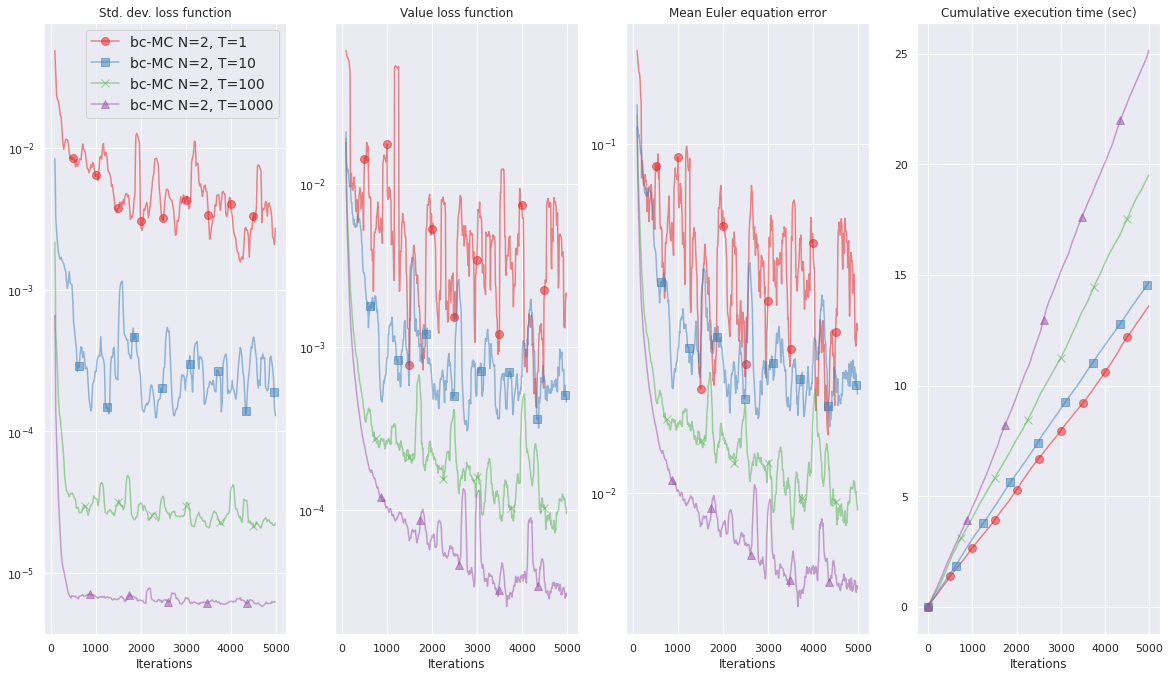

learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([1, 2])
W_expanded.shape: torch.Size([2, 2])
M: 1
N: 2
MN: 2
T: 1
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[2]
[1.]
[2.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.010317, mean euler error 0.101574, [    0/ 5000]
N: 2 loss: 0.151513, mean euler error 0.389247, [ 1000/ 5000]
N: 2 loss: 0.018207, mean euler error 0.134933, [ 2000/ 5000]
N: 2 loss: 0.001167, mean euler error 0.034164, [ 3000/ 5000]
N: 2 loss: -0.000078, mean euler error 0.000000+0.008839j, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:15<00:15, 15.85s/it]

N: 2 loss: 0.019476, mean euler error 0.139556, [    0/ 5000]
N: 2 loss: 0.000991, mean euler error 0.031473, [ 1000/ 5000]
N: 2 loss: 0.011935, mean euler error 0.109248, [ 2000/ 5000]
N: 2 loss: 0.001839, mean euler error 0.042887, [ 3000/ 5000]
N: 2 loss: 0.000202, mean euler error 0.014205, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:30<00:00, 15.20s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.010317          0.101574          2  0.007595  0.003891
1           0    10  0.075323          0.274450          2  0.007595  0.033780
2           0    20  0.147703          0.384322          2  0.005802  0.054503
3           0    30  0.012512          0.111859          2  0.005802  0.082455
4           0    40  0.001910          0.043703          2  0.004862  0.105683
learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([10, 20])
W_expanded.shape: torch.Size([20, 20])
M: 10
N: 2
MN: 20
T: 10
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[ 2  4 10]
[10.  5.  2.]
[20. 20. 20.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.092012, mean euler error 0.303335, [    0/ 5000]
N: 2 loss: 0.004780, mean euler error 0.069141, [ 1000/ 5000]
N: 2 loss: 0.001194, mean euler error 0.034552, [ 2000/ 5000]
N: 2 loss: 0.000474, mean euler error 0.021770, [ 3000/ 5000]
N: 2 loss: 0.000229, mean euler error 0.015144, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:14<00:14, 14.24s/it]

N: 2 loss: 0.089085, mean euler error 0.298472, [    0/ 5000]
N: 2 loss: 0.033109, mean euler error 0.181959, [ 1000/ 5000]
N: 2 loss: 0.001368, mean euler error 0.036991, [ 2000/ 5000]
N: 2 loss: 0.000080, mean euler error 0.008927, [ 3000/ 5000]
N: 2 loss: -0.000092, mean euler error 0.000000+0.009604j, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:27<00:00, 13.99s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092012          0.303335          2  0.000751  0.003190
1           0    10  0.067215          0.259258          2  0.000751  0.047392
2           0    20  0.093436          0.305673          2  0.000383  0.072965
3           0    30  0.011145          0.105569          2  0.000383  0.104642
4           0    40  0.043767          0.209205          2  0.000211  0.126090
learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000598, mean euler error 0.024459, [ 1000/ 5000]
N: 2 loss: 0.000239, mean euler error 0.015450, [ 2000/ 5000]
N: 2 loss: 0.000284, mean euler error 0.016852, [ 3000/ 5000]
N: 2 loss: 0.000305, mean euler error 0.017452, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.24s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000480, mean euler error 0.021906, [ 1000/ 5000]
N: 2 loss: 0.000244, mean euler error 0.015633, [ 2000/ 5000]
N: 2 loss: 0.000191, mean euler error 0.013811, [ 3000/ 5000]
N: 2 loss: 0.000187, mean euler error 0.013685, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:38<00:00, 19.10s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.065064          0.255077          2  0.000069  0.005175
1           0    10  0.103023          0.320972          2  0.000069  0.042838
2           0    20  0.078150          0.279554          2  0.000026  0.070489
3           0    30  0.029615          0.172089          2  0.000026  0.104266
4           0    40  0.027195          0.164908          2  0.000013  0.132062
learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([1000, 2000])
W_expanded.shape: torch.Size([2000, 2000])
M: 1000
N: 2
MN: 2000
T: 1000
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[   2    4    8   10   16   20   40   50   80  100  200  250  400  500
 1000]
[1000.  500.  250.  200.  125.  100.   50.   40.   25.   20.   10.    8.
    5.    4.    2.]
[2000. 2000.

  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.066388, mean euler error 0.257658, [    0/ 5000]
N: 2 loss: 0.000277, mean euler error 0.016653, [ 1000/ 5000]
N: 2 loss: 0.000170, mean euler error 0.013049, [ 2000/ 5000]
N: 2 loss: 0.000104, mean euler error 0.010218, [ 3000/ 5000]
N: 2 loss: 0.000087, mean euler error 0.009311, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.24s/it]

N: 2 loss: 0.119205, mean euler error 0.345260, [    0/ 5000]
N: 2 loss: 0.000399, mean euler error 0.019979, [ 1000/ 5000]
N: 2 loss: 0.000231, mean euler error 0.015188, [ 2000/ 5000]
N: 2 loss: 0.000122, mean euler error 0.011039, [ 3000/ 5000]
N: 2 loss: 0.000104, mean euler error 0.010184, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.98s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.066388          0.257658          2  7.177284e-06   
1           0    10  0.050713          0.225196          2  7.177284e-06   
2           0    20  0.045613          0.213572          2  2.667225e-06   
3           0    30  0.033759          0.183737          2  2.667225e-06   
4           0    40  0.027583          0.166081          2  9.105366e-07   

       time  
0  0.012844  
1  0.057453  
2  0.096202  
3  0.141409  
4  0.180412  
     bc optim     lr  N     M     T  N_star
8   0.0  Adam  0.001  2     1     1   False
9   0.0  Adam  0.001  2    10    10   False
10  0.0  Adam  0.001  2   100   100   False
11  0.0  Adam  0.001  2  1000  1000   False


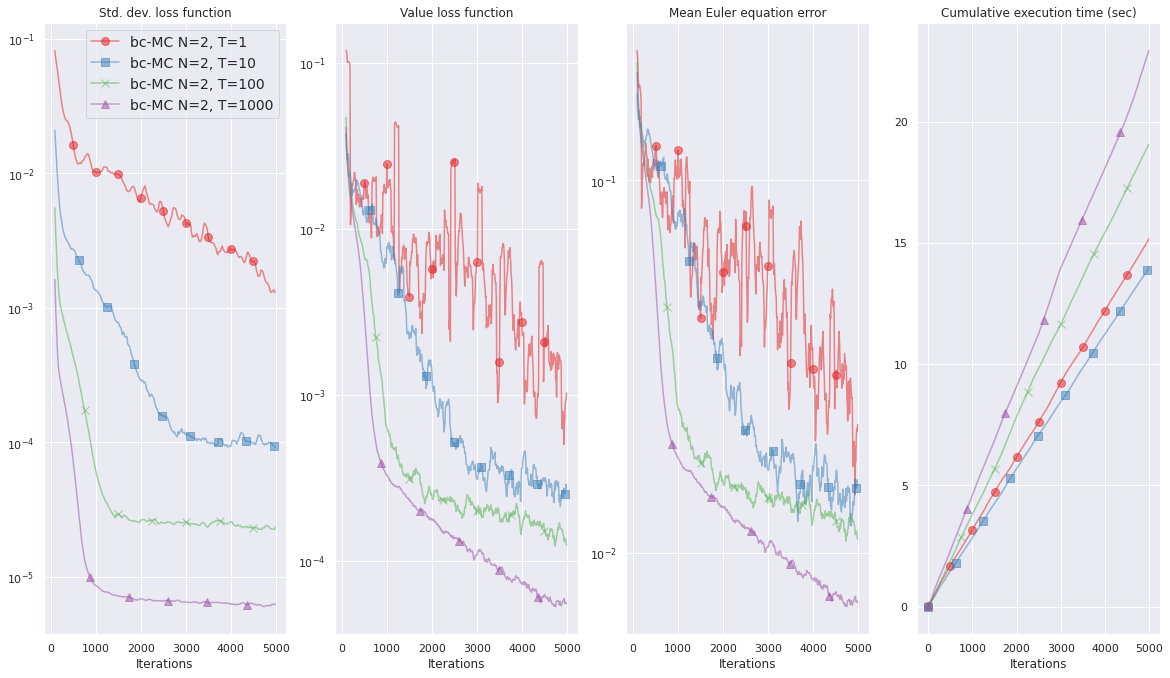

learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([1, 2])
W_expanded.shape: torch.Size([2, 2])
M: 1
N: 2
MN: 2
T: 1
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[2]
[1.]
[2.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.010317, mean euler error 0.101574, [    0/ 5000]
N: 2 loss: 0.176541, mean euler error 0.420168, [ 1000/ 5000]
N: 2 loss: 0.021967, mean euler error 0.148212, [ 2000/ 5000]
N: 2 loss: 0.000241, mean euler error 0.015517, [ 3000/ 5000]
N: 2 loss: 0.003492, mean euler error 0.059097, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:15<00:15, 15.54s/it]

N: 2 loss: 0.019476, mean euler error 0.139556, [    0/ 5000]
N: 2 loss: 0.002156, mean euler error 0.046435, [ 1000/ 5000]
N: 2 loss: 0.021166, mean euler error 0.145485, [ 2000/ 5000]
N: 2 loss: 0.009763, mean euler error 0.098809, [ 3000/ 5000]
N: 2 loss: 0.000634, mean euler error 0.025177, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:32<00:00, 16.28s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.010317          0.101574          2  0.007659  0.003904
1           0    10  0.069653          0.263919          2  0.007659  0.042175
2           0    20  0.143334          0.378595          2  0.006432  0.068934
3           0    30  0.012366          0.111202          2  0.006432  0.103234
4           0    40  0.005870          0.076617          2  0.005906  0.126967
learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([10, 20])
W_expanded.shape: torch.Size([20, 20])
M: 10
N: 2
MN: 20
T: 10
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[ 2  4 10]
[10.  5.  2.]
[20. 20. 20.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.092012, mean euler error 0.303335, [    0/ 5000]
N: 2 loss: 0.011184, mean euler error 0.105755, [ 1000/ 5000]
N: 2 loss: 0.006201, mean euler error 0.078748, [ 2000/ 5000]
N: 2 loss: 0.001787, mean euler error 0.042270, [ 3000/ 5000]
N: 2 loss: 0.000589, mean euler error 0.024261, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:16<00:16, 16.09s/it]

N: 2 loss: 0.089085, mean euler error 0.298472, [    0/ 5000]
N: 2 loss: 0.034001, mean euler error 0.184394, [ 1000/ 5000]
N: 2 loss: 0.010708, mean euler error 0.103481, [ 2000/ 5000]
N: 2 loss: 0.000801, mean euler error 0.028298, [ 3000/ 5000]
N: 2 loss: 0.000194, mean euler error 0.013946, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:31<00:00, 15.55s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092012          0.303335          2  0.000762  0.004168
1           0    10  0.075169          0.274169          2  0.000762  0.058636
2           0    20  0.102579          0.320280          2  0.000510  0.103300
3           0    30  0.013265          0.115176          2  0.000510  0.141938
4           0    40  0.055179          0.234903          2  0.000371  0.165060
learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.005158, mean euler error 0.071817, [ 1000/ 5000]
N: 2 loss: 0.000366, mean euler error 0.019122, [ 2000/ 5000]
N: 2 loss: 0.000337, mean euler error 0.018358, [ 3000/ 5000]
N: 2 loss: 0.000456, mean euler error 0.021344, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.61s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.004243, mean euler error 0.065138, [ 1000/ 5000]
N: 2 loss: 0.000368, mean euler error 0.019176, [ 2000/ 5000]
N: 2 loss: 0.000306, mean euler error 0.017503, [ 3000/ 5000]
N: 2 loss: 0.000206, mean euler error 0.014351, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:37<00:00, 18.55s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.065064          0.255077          2  0.000071  0.013672
1           0    10  0.113263          0.336546          2  0.000071  0.054346
2           0    20  0.096635          0.310862          2  0.000044  0.084867
3           0    30  0.039816          0.199540          2  0.000044  0.123926
4           0    40  0.039634          0.199084          2  0.000032  0.154811
learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([1000, 2000])
W_expanded.shape: torch.Size([2000, 2000])
M: 1000
N: 2
MN: 2000
T: 1000
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[   2    4    8   10   16   20   40   50   80  100  200  250  400  500
 1000]
[1000.  500.  250.  200.  125.  100.   50.   40.   25.   20.   10.    8.
    5.    4.    2.]
[2000. 2000

  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.066388, mean euler error 0.257658, [    0/ 5000]
N: 2 loss: 0.001043, mean euler error 0.032301, [ 1000/ 5000]
N: 2 loss: 0.000253, mean euler error 0.015893, [ 2000/ 5000]
N: 2 loss: 0.000182, mean euler error 0.013497, [ 3000/ 5000]
N: 2 loss: 0.000156, mean euler error 0.012471, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.92s/it]

N: 2 loss: 0.119205, mean euler error 0.345260, [    0/ 5000]
N: 2 loss: 0.001793, mean euler error 0.042342, [ 1000/ 5000]
N: 2 loss: 0.000373, mean euler error 0.019324, [ 2000/ 5000]
N: 2 loss: 0.000231, mean euler error 0.015185, [ 3000/ 5000]
N: 2 loss: 0.000211, mean euler error 0.014536, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.38s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.066388          0.257658          2  0.000007  0.008265
1           0    10  0.057764          0.240341          2  0.000007  0.062708
2           0    20  0.057373          0.239526          2  0.000005  0.104616
3           0    30  0.047931          0.218931          2  0.000005  0.158660
4           0    40  0.042318          0.205713          2  0.000003  0.202964
     bc optim      lr  N     M     T  N_star
12  0.0  Adam  0.0005  2     1     1   False
13  0.0  Adam  0.0005  2    10    10   False
14  0.0  Adam  0.0005  2   100   100   False
15  0.0  Adam  0.0005  2  1000  1000   False


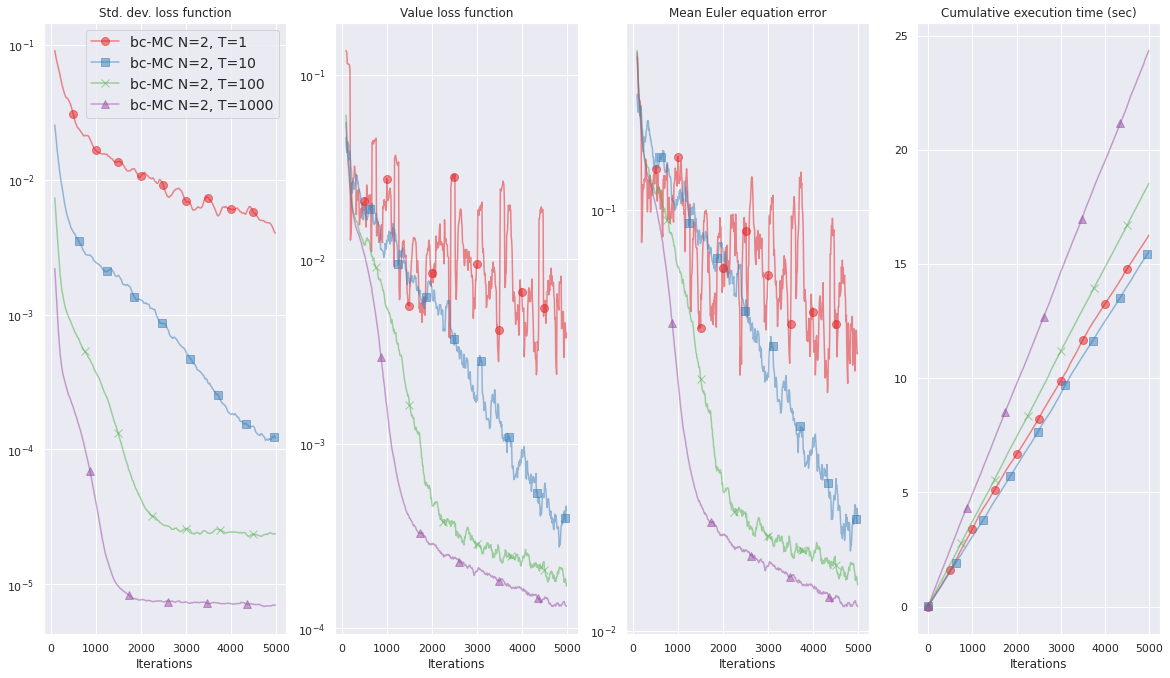

In [31]:
extension_csv_file = "changing_M"

if run_analysis_1 == True: #start the analysis (can be very long)
    print("Starting analysis 1. Keeping N = 2.")

    # Plotting options
    #Plotting option
    tol_float = 10e-40 #sys.float_info.epsilon
    mult=0.5
    alpha_bands=0.05
    display_CI = False #False

    rate = 10
    colors = sns.color_palette("Set1", 5)
    markers = ["o", "s", "x", "^", "D"]
    markersize= 8
    ref_freq = 50
    alpha_chosen=0.5
    list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
    prefix = "" #"" #"P50_" # ""

    #lr_loop = [0.1, 0.01, 0.001] #learning rate
    lr_loop = [0.05, 0.01, 0.001, 0.0005] #[0.05, 0.01, 0.005] #learning rate
    optimizer_loop = ["Adam"] #["SGD", "Adam"]# ["SGD", "Adam"] #solvers

    bc_loop = [0.0] #different types of borrowing constraints
    T_loop = [1, 10, 100, 1000]
    divs = [1, 1, 1, 1]
    N_star_loop = [False, False, False, False]

    M_loop = [int(T/(div)) for (div, T) in zip(divs, T_loop)]
    N_loop = [int(2*T/M) for (M,T) in zip(M_loop, T_loop)] #T=MN/2

    print(f"T: {T_loop}")
    print(f"M: {M_loop}")
    print(f"N: {N_loop}")
    print(f"N_star: {N_star_loop}")
    # Safety check
    print(np.array(M_loop)*np.array(N_loop)/2)

    random.seed(seed_number) # For replicability reasons
    print(random.random()) 
    torch.manual_seed(seed_number)

    model_bcMC = NeuralNetwork(params).to(device)
    model_bcMC_untrained = copy.deepcopy(model_bcMC)

    # store hyperparams used
    list_bc_used = []
    list_optimizer_used = []
    list_lr_used = []
    list_N_used = []
    list_M_used = []
    list_T_used = []
    list_N_star_used = []

    list_dfs_hyperparams = [] #to store results in a dataframe

    # Loop over sigma
    for (bc_chosen) in bc_loop:
        for optimizer_chosen in optimizer_loop: # Loop over solvers
            for lr_chosen in lr_loop:  # Loop over learning rate 
                for (N_chosen, M_chosen, use_N_star) in zip(N_loop, M_loop, N_star_loop):  #Loop over (M, N) for some choices of T

                    # create a reference params object
                    params = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen, 
                                      nb_epochs_chosen, bc_chosen, order_gauss,
                                      σ_shocks_chosen, use_Sobol_chosen, optimizer_chosen, 
                                      dim_p_chosen, grid_depth_chosen, 
                                      nb_refinements_chosen, surplus_threshold_chosen, 
                                      "params_TI", nb_points_w=3, nb_points_other=3,
                                      w1 = w1_chosen, w2 = w2_chosen)

                    show_params(params)

                    # append list
                    list_bc_used.append(params.bc)
                    list_optimizer_used.append(params.optimizer)
                    list_lr_used.append(params.lr)
                    list_N_used.append(params.N)
                    list_M_used.append(params.M)
                    list_T_used.append(params.T)
                    list_N_star_used.append(use_N_star)

                    # Create grids
                    grid_N = np.array([N for N in range(2, params.T+2, 2)])
                    grid_M = 2*params.T/grid_N

                    is_int = grid_M % 1 == 0
                    grid_N = grid_N[is_int]
                    grid_M = grid_M[is_int]

                    print(grid_N)
                    print(grid_M)
                    print(grid_N*grid_M)

                    # Pre-calculate params associated with grid choices
                    list_params = []
                    for (ind, (N_chosen, M_chosen)) in enumerate(zip(grid_N, grid_M)):
                        # Change M and N
                        params_local = MyParams(int(N_chosen), int(M_chosen), params.lr, params.pre_train_model,
                                  params.nb_epochs, params.bc, params.order_gauss,
                                  params.σ_shocks, params.use_Sobol, params.optimizer, 
                                  params.dim_p, params.grid_depth, 
                                  params.nb_refinements, params.surplus_threshold, 
                                  "params_TI", params.n_points_w, params.n_points_grid,
                                  params.w1, params.w2)
                        list_params.append(params_local)

                    list_list_Euler_mean = [] #Mean Euler error 
                    list_list_Euler_i = [] #store index i
                    list_list_Euler_loss = [] #store value function
                    list_list_optimal_N = [] #optimal N
                    list_list_var_loss = [] #store variance of loss
                    list_list_time = [] #store time
                    

                    for rep in tqdm(range(0, nb_reps)): # Loop over different iterations of solver
                        random.seed(int(rep)) #same series of shocks for same rep
                        torch.manual_seed(int(rep)) #same series of shocks for same rep
                        # Initialize a new NN
                        model_MC = NeuralNetwork(params).to(device)
                        #model_MC = copy.deepcopy(model_bcMC) #create a copy of NN
                        model_MC.train()
                        # Optimizer
                        optimizer = create_optimizer(model_MC, params.optimizer, params.lr, params.momentum)
                        # Scheduler
                        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
                        loss_epochs_MC = torch.zeros(params.nb_epochs)
                        list_Euler_mean = [] #mean
                        list_Euler_i = [] #store index i
                        list_Euler_loss = [] #store loss
                        list_time = [] #store elapsed time (sec)
                        calculate_variance_loss = True # Calculate variance of loss or not
                        list_var_loss = [] #store variance of the loss
                        list_optimal_N = [] #store the optimal N
                        list_optimal_N_current = [] #store the current optimal N used.
                        optimal_N = params.N #set initial choice for N
                        index_best_N = np.where(grid_N == optimal_N)[0][0]
                        freq_var =  20 #frequency with which the variance of the loss is calculated
                        freq_loss = 10 #frequency with which the loss is calculated
                        ratio_freq_loss_freq_var = int(freq_var/freq_loss)
                        use_exact_accuracy_metrics = False # If False, use square loss to get the EEE
                    
                        start = timer()
                        for i in range(0, params.nb_epochs):
                            # Clear gradient
                            optimizer.zero_grad()
                            # params associated with the current best N:
                            params_local = list_params[index_best_N]
                            # Calculate loss
                            loss = Ξ_torch_MC(model_MC, params_local)
                            loss_epochs_MC[[i]] = float(loss.item())

                            # Backpropagation
                            loss.backward()
                            # Avoid explosive gradients
                            clip_grad_norm_(model_MC.parameters(), max_norm=1.0, error_if_nonfinite=False)
                            # Gradient descent step
                            optimizer.step()

                            if i % freq_loss == 0: #Monitor accuracy
                                model_MC.eval()
                                list_optimal_N_current.append(optimal_N) #N used
                                # Evaluate Euler error
                                if use_exact_accuracy_metrics == True:
                                    with torch.no_grad():
                                        euler, euler_bis, c, c_RHS, w = evaluate_accuracy_pytorch_MC_frozen(model_MC, params_local)
                                    list_Euler_mean.append(np.mean(euler_bis))
                                # Square root of loss function
                                else:
                                    EEE = float(loss.item())**0.5
                                    list_Euler_mean.append(EEE)
                                list_Euler_i.append(i) #Index
                                list_Euler_loss.append(float(loss.item())) #loss
                                model_MC.train()
            
                                # Calculate time
                                now = timer()
                                elapsed_time = now - start
                                list_time.append(elapsed_time)
                            
                            # Calculation of variance of the loss and optimal choice for N
                            if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
                                var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_MC, nb_draws, grid_M, grid_N)
                                if use_N_star == False:
                                    index_best_N_dummy = np.argmin(var_loss_formula)
                                    optimal_N_dummy = grid_N[index_best_N_dummy] #Do not modify optimal_N
                                    list_optimal_N.append(optimal_N_dummy)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                                # When N* algo is used, update the value of N during training
                                else:
                                    # Gaussian formula
                                    index_best_N = np.argmin(var_loss_formula)
                                    # Var/Cov
                                    #N_star_theory = 1 + np.abs(var_f/cov_f)
                                    #index_best_N = np.argmin(np.abs(N_star_theory - grid_N)) #project on grid
                                    optimal_N = grid_N[index_best_N]
                                    list_optimal_N.append(optimal_N)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                            if i % 1000 == 0:
                                loss, current = float(loss.item()), i
                                print(f"N: {optimal_N} loss: {loss:>7f}, mean euler error {list_Euler_mean[-1]:>7f}, [{current:>5d}/{params_local.nb_epochs:>5d}]")
                            if (i % params_local.freq_scheduler == 0) & (i != 0) & (params_local.use_scheduler == True):
                                scheduler.step()
                                print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

                        if params_local.optimizer == "SWA":
                            optimizer.swap_swa_sgd()
                        
                        # Save model to disk
                        torch.save(model_MC.state_dict(), output_folder_models + f'model_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.pth')
        
                        #Store values
                        list_list_Euler_mean.append(list_Euler_mean) #Mean Euler error 
                        list_list_Euler_i.append(list_Euler_i) #store index i
                        list_list_Euler_loss.append(list_Euler_loss) #store value function
                        list_list_optimal_N.append(list_optimal_N_current) #optimal N
                        list_list_var_loss.append(list_var_loss)
                        list_list_time.append(list_time)
                        
                    # Flatten lists of lists
                    list_list_Euler_i = numpy_flat(list_list_Euler_i)
                    list_list_Euler_loss = numpy_flat(list_list_Euler_loss)
                    list_list_Euler_mean = np.real(numpy_flat(list_list_Euler_mean))
                    list_list_optimal_N = numpy_flat(list_list_optimal_N)
                    list_list_var_loss = numpy_flat(list_list_var_loss)
                    list_list_time = numpy_flat(list_list_time)
                    
                    # Create dataframe and summary stats
                    lst = list(range(0, nb_reps))
                    list_index_rep = list(np.repeat(lst, len(list_Euler_i))) #gradient descent steps

                    df_bcMC_loop = pd.DataFrame({
                                        'repetition': list_index_rep,
                                        'iter': list_list_Euler_i,
                                        'loss': np.abs(list_list_Euler_loss),
                                        'mean_Euler_error': list_list_Euler_mean,
                                        'optimal_N': list_list_optimal_N,
                                        'var_loss': np.repeat(list_list_var_loss, ratio_freq_loss_freq_var),
                                        'time': list_list_time,
                       })

                    print(df_bcMC_loop.head())

                    # Statistics on results
                    df_bcMC_loop_average = df_bcMC_loop.groupby('iter').mean().reset_index() #mean value by iteration
                    df_bcMC_loop_average.head()

                    list_cols = ["loss", "mean_Euler_error", "optimal_N", "var_loss", "time"]

                    for col in list_cols:
                        df_bcMC_loop_average["min_" + col] = df_bcMC_loop.groupby('iter')[col].min().reset_index()[col]                     
                        df_bcMC_loop_average["max_" + col] = df_bcMC_loop.groupby('iter')[col].max().reset_index()[col]
                        df_bcMC_loop_average["std_" + col] = df_bcMC_loop.groupby('iter')[col].std().reset_index()[col]
                        for qq in [5, 10, 25, 50, 75, 90, 95]:
                            df_bcMC_loop_average["P" + str(qq) + "_" + col] = df_bcMC_loop.groupby('iter')[col].quantile(qq/100).reset_index()[col]

                    # append list
                    list_dfs_hyperparams.append(df_bcMC_loop_average)
                #------------------------------------
                # End of different choices for (M,N):
                # Plot
                #------------------------------------
                df_hyperparams = pd.DataFrame({"bc":list_bc_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

                # select combination
                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["bc"] == bc_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)

                list_dfs_plot = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                for (i, min_index) in enumerate([0]):
                    #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                    fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
                    
                    """
                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:], df[f"{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    ax1.set_xlabel("Iterations")
                    """
                    
                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax3.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")


                    #var = "mean_percentage_error"
                    var = "mean_Euler_error"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax4.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax4.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)

                    ax4.set_yscale('log')
                    ax4.set_title('Mean Euler equation error')
                    ax4.set_xlabel("Iterations")

                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:] - mult*df[f"std_{var}"][min_index:], df[f"{prefix}{var}"][min_index:] + mult*df[f"std_{var}"][min_index:], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

                    figname = output_folder + f'changing_M_bc_{bc_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.png'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)

                    figname = output_folder + f'changing_M_bc_{bc_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.pdf'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)
                    plt.show()


In [32]:
if save_to_csv == True:
    print("Writting CSV")

    df_hyperparams = pd.DataFrame({"bc":list_bc_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

    df_hyperparams.to_csv(output_folder + f"hyperparams_{extension_csv_file}.csv", index=False)
    print(df_hyperparams)

    index_df = 0
    for index, row in df_hyperparams.iterrows():
        bc_chosen = row['bc']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
        list_dfs_hyperparams[index_df].to_csv(filen, index=False)
        index_df+=1
        

Writting CSV
     bc optim      lr  N     M     T  N_star
0   0.0  Adam  0.0500  2     1     1   False
1   0.0  Adam  0.0500  2    10    10   False
2   0.0  Adam  0.0500  2   100   100   False
3   0.0  Adam  0.0500  2  1000  1000   False
4   0.0  Adam  0.0100  2     1     1   False
5   0.0  Adam  0.0100  2    10    10   False
6   0.0  Adam  0.0100  2   100   100   False
7   0.0  Adam  0.0100  2  1000  1000   False
8   0.0  Adam  0.0010  2     1     1   False
9   0.0  Adam  0.0010  2    10    10   False
10  0.0  Adam  0.0010  2   100   100   False
11  0.0  Adam  0.0010  2  1000  1000   False
12  0.0  Adam  0.0005  2     1     1   False
13  0.0  Adam  0.0005  2    10    10   False
14  0.0  Adam  0.0005  2   100   100   False
15  0.0  Adam  0.0005  2  1000  1000   False


In [33]:
# Load files
if read_from_csv == True:
    print("Reading CSV")

    df_hyperparams = pd.read_csv(output_folder + f'hyperparams_{extension_csv_file}.csv')
    print(df_hyperparams)

    list_dfs_hyperparams = []
    for index, row in df_hyperparams.iterrows():
        bc_chosen = row['bc']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
        list_dfs_hyperparams.append(pd.read_csv(filen))


Reading CSV
     bc optim      lr  N     M     T  N_star
0   0.0  Adam  0.0500  2     1     1   False
1   0.0  Adam  0.0500  2    10    10   False
2   0.0  Adam  0.0500  2   100   100   False
3   0.0  Adam  0.0500  2  1000  1000   False
4   0.0  Adam  0.0100  2     1     1   False
5   0.0  Adam  0.0100  2    10    10   False
6   0.0  Adam  0.0100  2   100   100   False
7   0.0  Adam  0.0100  2  1000  1000   False
8   0.0  Adam  0.0010  2     1     1   False
9   0.0  Adam  0.0010  2    10    10   False
10  0.0  Adam  0.0010  2   100   100   False
11  0.0  Adam  0.0010  2  1000  1000   False
12  0.0  Adam  0.0005  2     1     1   False
13  0.0  Adam  0.0005  2    10    10   False
14  0.0  Adam  0.0005  2   100   100   False
15  0.0  Adam  0.0005  2  1000  1000   False


    bc optim    lr  N     M     T  N_star
0  0.0  Adam  0.05  2     1     1   False
1  0.0  Adam  0.05  2    10    10   False
2  0.0  Adam  0.05  2   100   100   False
3  0.0  Adam  0.05  2  1000  1000   False


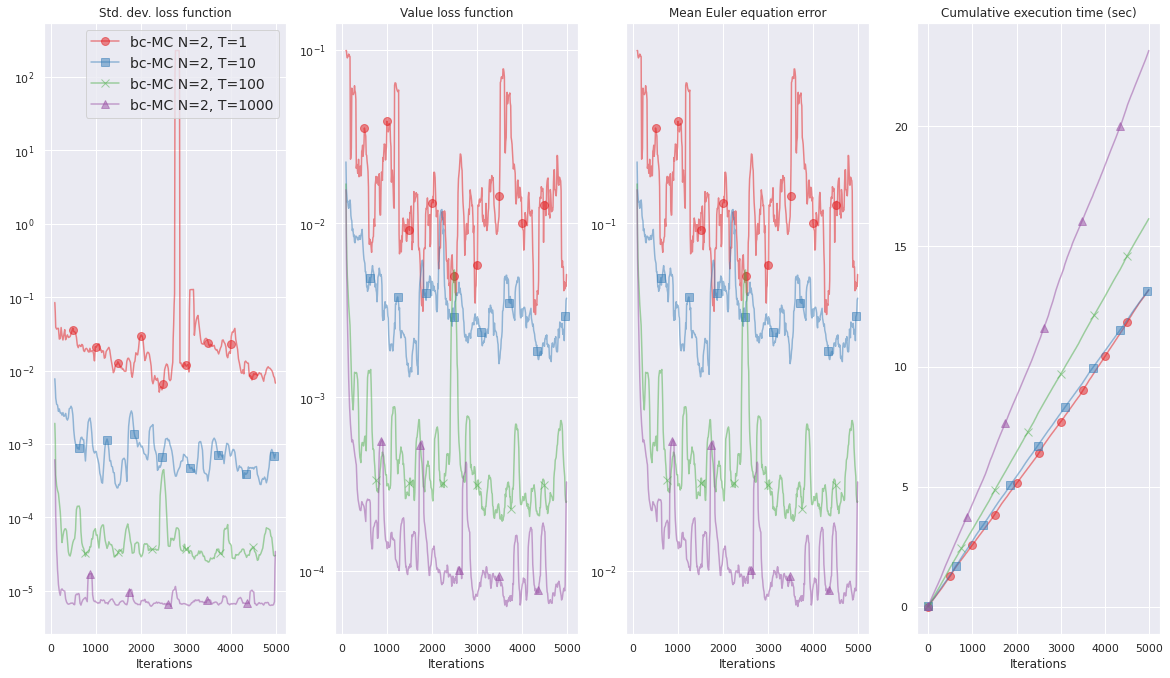

    bc optim    lr  N     M     T  N_star
4  0.0  Adam  0.01  2     1     1   False
5  0.0  Adam  0.01  2    10    10   False
6  0.0  Adam  0.01  2   100   100   False
7  0.0  Adam  0.01  2  1000  1000   False


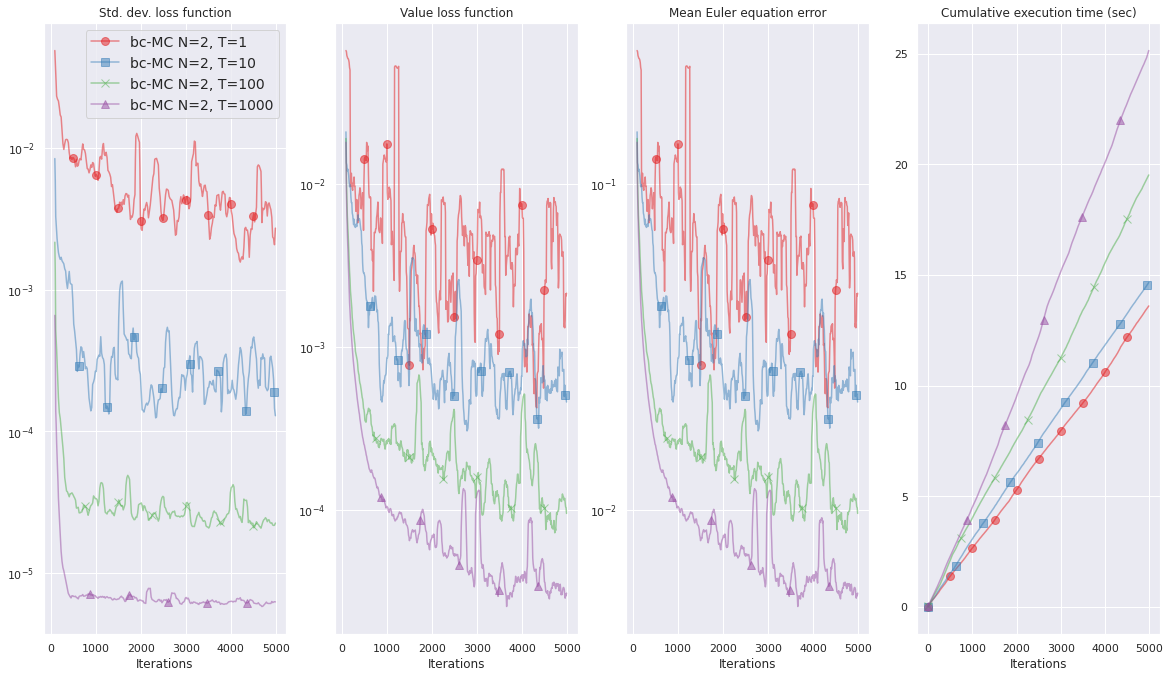

     bc optim     lr  N     M     T  N_star
8   0.0  Adam  0.001  2     1     1   False
9   0.0  Adam  0.001  2    10    10   False
10  0.0  Adam  0.001  2   100   100   False
11  0.0  Adam  0.001  2  1000  1000   False


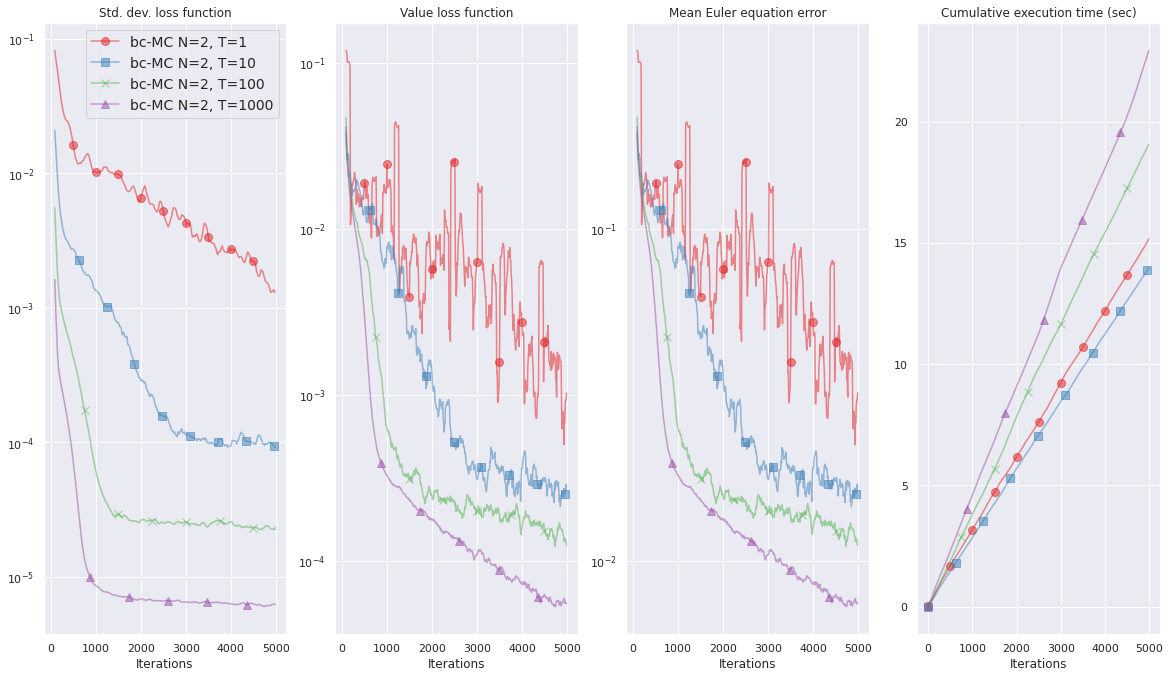

     bc optim      lr  N     M     T  N_star
12  0.0  Adam  0.0005  2     1     1   False
13  0.0  Adam  0.0005  2    10    10   False
14  0.0  Adam  0.0005  2   100   100   False
15  0.0  Adam  0.0005  2  1000  1000   False


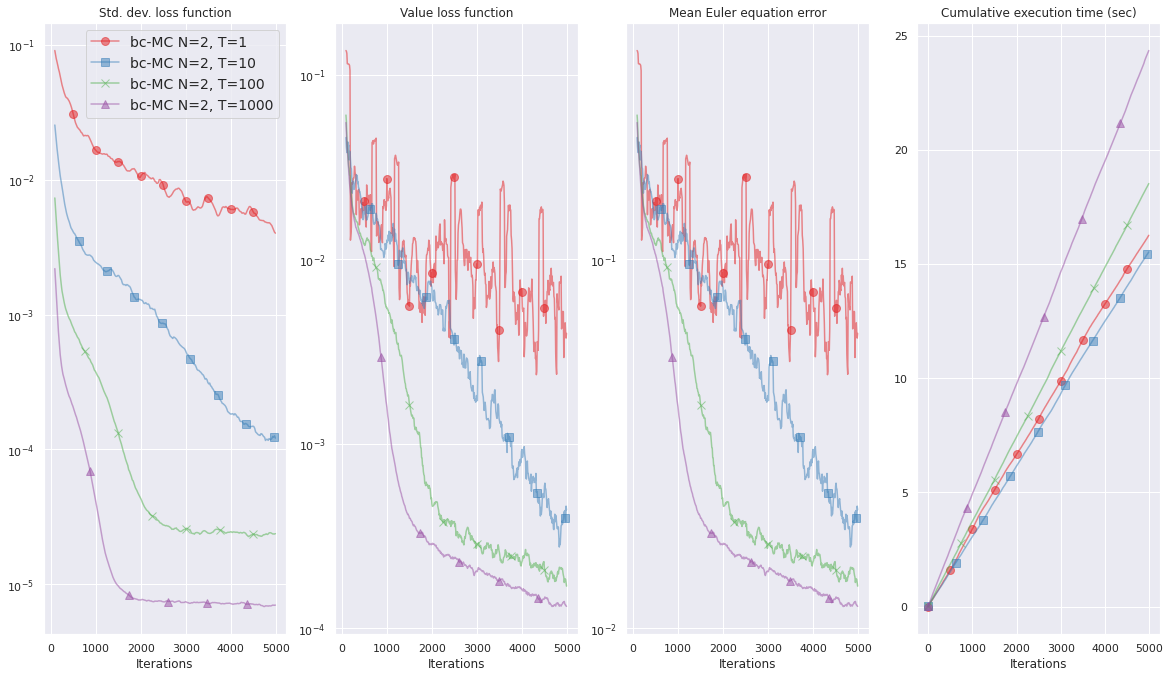

In [34]:
mult=0.5
alpha_bands=0.10
display_CI = False #False

rate = 10 #20
colors = sns.color_palette("Set1", 5)
markers = ["o", "s", "x", "^", "D"]
markersize= 8
ref_freq = 50
alpha_chosen=0.5
list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
prefix = "" #"" #"" #"P50_" # ""

list_combinations_used = []             
for index, row in df_hyperparams.iterrows():
    bc_chosen = row['bc']
    optimizer_chosen = row["optim"]
    lr_chosen = row["lr"]
    N_chosen = row["N"]
    M_chosen = row["M"]
    use_N_star = row["N_star"]
        
    combination = f'{optimizer_chosen}-{bc_chosen}-{lr_chosen}'
    if combination not in list_combinations_used:
        list_combinations_used.append(combination)
    else:
        continue #If combination already used, pass
    df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
    df_sel = df_sel[df_sel["bc"] == bc_chosen]
    df_sel = df_sel[df_sel["lr"] == lr_chosen]
    print(df_sel)
    

    list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
    list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
    list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
    list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
    list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

    list_labels = []
    for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
        if N_star == True:
            list_labels += [f"bc-MC N*, T={T}"]
        else:
            list_labels += [f"bc-MC N={N}, T={T}"]
    #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

    #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
    for (i, (min_index, max_index)) in enumerate(zip([0], [nb_epochs_chosen])):
        #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
        fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
    
        """
        var = "optimal_N"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
        #ax1.set_yscale('log')
        ax1.set_title('Value for N')
        ax1.set_xlabel("Iterations")
        """

        var = "var_loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax2.set_yscale('log')
        ax2.set_title('Std. dev. loss function')
        ax2.legend(loc="upper right")
        ax2.set_xlabel("Iterations")

        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax3.set_yscale('log')
        ax3.set_title('Value loss function')
        ax3.set_xlabel("Iterations")

        """
        #var = "mean_percentage_error"
        var = "mean_Euler_error"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        """
        # square root series for loss
        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = np.sqrt(pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean()) # Moving average series
            MA_std = np.sqrt(pd.Series(df[f"std_{var}"]).rolling(rate).mean()) # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)

        ax4.set_yscale('log')
        ax4.set_title('Mean Euler equation error')
        ax4.set_xlabel("Iterations")

        var = "time"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

        ax5.set_xlabel("Iterations")
        ax5.set_title("Cumulative execution time (sec)")

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
        plt.savefig(figname, bbox_inches="tight", dpi=300)

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
        plt.savefig(figname, bbox_inches="tight", dpi=300)
        plt.show()


##  Test hyperparameters with a single loop

### B. Optimal N*, keep T constant

Starting analysis 2. Choose N*.
T: [100, 100, 100, 100]
M: [100, 2, 10, 100]
N: [2, 100, 20, 2]
N_star: [True, False, False, False]
[100. 100. 100. 100.]
0.9664535356921388
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000719, mean euler error 0.026818, [ 1000/ 5000]
N: 2 loss: 0.000392, mean euler error 0.019806, [ 2000/ 5000]
N: 2 loss: 0.001015, mean euler error 0.031860, [ 3000/ 5000]
N: 2 loss: 0.000886, mean euler error 0.029765, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.05s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000188, mean euler error 0.013697, [ 1000/ 5000]
N: 2 loss: 0.000197, mean euler error 0.014047, [ 2000/ 5000]
N: 2 loss: 0.000189, mean euler error 0.013737, [ 3000/ 5000]
N: 2 loss: 0.000458, mean euler error 0.021410, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:32<00:00, 16.42s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.065064          0.255077          2  4.682264e-05   
1           0    10  0.036261          0.190422          2  4.682264e-05   
2           0    20  0.018598          0.136374          2  9.474188e-07   
3           0    30  0.010414          0.102050          2  9.474188e-07   
4           0    40  0.007153          0.084577          2  2.276535e-07   

       time  
0  0.013158  
1  0.056519  
2  0.087549  
3  0.122531  
4  0.151045  
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 100 loss: 0.031874, mean euler error 0.178533, [    0/ 5000]
N: 100 loss: 0.003449, mean euler error 0.058725, [ 1000/ 5000]
N: 100 loss: 0.002042, mean euler error 0.045186, [ 2000/ 5000]
N: 100 loss: 0.033554, mean euler error 0.183177, [ 3000/ 5000]
N: 100 loss: 0.008774, mean euler error 0.093668, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.01s/it]

N: 100 loss: 0.016275, mean euler error 0.127572, [    0/ 5000]
N: 100 loss: 0.002344, mean euler error 0.048411, [ 1000/ 5000]
N: 100 loss: 0.005460, mean euler error 0.073891, [ 2000/ 5000]
N: 100 loss: 0.009133, mean euler error 0.095564, [ 3000/ 5000]
N: 100 loss: 0.064451, mean euler error 0.253872, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.41s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.031874          0.178533        100  0.087905  0.013595
1           0    10  0.555372          0.745233        100  0.087905  0.051612
2           0    20  0.109473          0.330868        100  0.000585  0.081719
3           0    30  0.061075          0.247133        100  0.000585  0.118239
4           0    40  0.026663          0.163288        100  0.003904  0.149818
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 20 loss: 0.092309, mean euler error 0.303824, [    0/ 5000]
N: 20 loss: 0.007343, mean euler error 0.085694, [ 1000/ 5000]
N: 20 loss: 0.000561, mean euler error 0.023686, [ 2000/ 5000]
N: 20 loss: 0.001452, mean euler error 0.038100, [ 3000/ 5000]
N: 20 loss: 0.000956, mean euler error 0.030922, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.77s/it]

N: 20 loss: 0.089046, mean euler error 0.298405, [    0/ 5000]
N: 20 loss: 0.001307, mean euler error 0.036149, [ 1000/ 5000]
N: 20 loss: 0.015561, mean euler error 0.124744, [ 2000/ 5000]
N: 20 loss: 0.001048, mean euler error 0.032367, [ 3000/ 5000]
N: 20 loss: 0.002455, mean euler error 0.049552, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:35<00:00, 17.90s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092309          0.303824         20  0.000238  0.004165
1           0    10  0.067176          0.259183         20  0.000238  0.048761
2           0    20  0.016485          0.128395         20  0.000059  0.082972
3           0    30  0.028793          0.169685         20  0.000059  0.119280
4           0    40  0.016812          0.129662         20  0.000036  0.150183
learning rate: 0.05
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000212, mean euler error 0.014552, [ 1000/ 5000]
N: 2 loss: 0.000190, mean euler error 0.013777, [ 2000/ 5000]
N: 2 loss: 0.000206, mean euler error 0.014365, [ 3000/ 5000]
N: 2 loss: 0.000219, mean euler error 0.014814, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.57s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000188, mean euler error 0.013697, [ 1000/ 5000]
N: 2 loss: 0.000159, mean euler error 0.012595, [ 2000/ 5000]
N: 2 loss: 0.000365, mean euler error 0.019100, [ 3000/ 5000]
N: 2 loss: 0.000456, mean euler error 0.021362, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.44s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.065064          0.255077          2  4.682264e-05   
1           0    10  0.036261          0.190422          2  4.682264e-05   
2           0    20  0.018598          0.136374          2  9.474188e-07   
3           0    30  0.010414          0.102050          2  9.474188e-07   
4           0    40  0.007153          0.084577          2  2.276535e-07   

       time  
0  0.016194  
1  0.084265  
2  0.133401  
3  0.202841  
4  0.257314  
    bc optim    lr    N    M    T  N_star
0  0.0  Adam  0.05    2  100  100    True
1  0.0  Adam  0.05  100    2  100   False
2  0.0  Adam  0.05   20   10  100   False
3  0.0  Adam  0.05    2  100  100   False


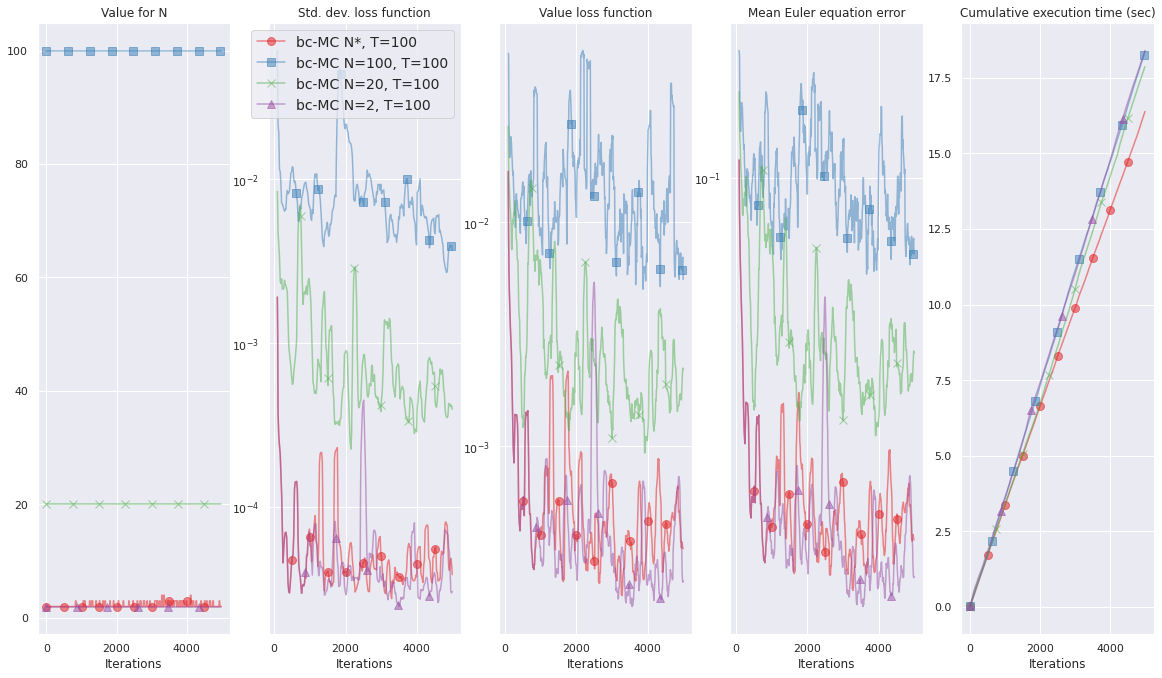

learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 4 loss: 0.000164, mean euler error 0.012804, [ 1000/ 5000]
N: 2 loss: 0.000347, mean euler error 0.018624, [ 2000/ 5000]
N: 4 loss: 0.000043, mean euler error 0.006562, [ 3000/ 5000]
N: 2 loss: 0.000302, mean euler error 0.017384, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.87s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000333, mean euler error 0.018254, [ 1000/ 5000]
N: 4 loss: 0.000217, mean euler error 0.014729, [ 2000/ 5000]
N: 2 loss: 0.000220, mean euler error 0.014840, [ 3000/ 5000]
N: 4 loss: 0.000085, mean euler error 0.009203, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:37<00:00, 18.81s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.065064          0.255077          2  4.302299e-05   
1           0    10  0.024260          0.155756          2  4.302299e-05   
2           0    20  0.018878          0.137398          2  1.009462e-06   
3           0    30  0.011454          0.107024          2  1.009462e-06   
4           0    40  0.008719          0.093373          2  3.742586e-07   

       time  
0  0.014381  
1  0.061095  
2  0.091120  
3  0.124667  
4  0.152801  
learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 100 loss: 0.031874, mean euler error 0.178533, [    0/ 5000]
N: 100 loss: 0.000017, mean euler error 0.004147, [ 1000/ 5000]
N: 100 loss: 0.000402, mean euler error 0.020049, [ 2000/ 5000]
N: 100 loss: 0.001645, mean euler error 0.040557, [ 3000/ 5000]
N: 100 loss: 0.004826, mean euler error 0.069472, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.21s/it]

N: 100 loss: 0.016275, mean euler error 0.127572, [    0/ 5000]
N: 100 loss: 0.000973, mean euler error 0.031186, [ 1000/ 5000]
N: 100 loss: 0.000382, mean euler error 0.019535, [ 2000/ 5000]
N: 100 loss: 0.001174, mean euler error 0.034258, [ 3000/ 5000]
N: 100 loss: 0.008897, mean euler error 0.094324, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.24s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.031874          0.178533        100  0.003721  0.004695
1           0    10  0.858022          0.926295        100  0.003721  0.056181
2           0    20  0.006580          0.081114        100  0.000646  0.098780
3           0    30  0.019599          0.139998        100  0.000646  0.144811
4           0    40  0.018292          0.135249        100  0.000104  0.181587
learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 20 loss: 0.092309, mean euler error 0.303824, [    0/ 5000]
N: 20 loss: 0.000178, mean euler error 0.013328, [ 1000/ 5000]
N: 20 loss: 0.000083, mean euler error 0.009109, [ 2000/ 5000]
N: 20 loss: 0.000206, mean euler error 0.014346, [ 3000/ 5000]
N: 20 loss: 0.000098, mean euler error 0.009893, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.80s/it]

N: 20 loss: 0.089046, mean euler error 0.298405, [    0/ 5000]
N: 20 loss: 0.000461, mean euler error 0.021469, [ 1000/ 5000]
N: 20 loss: 0.000629, mean euler error 0.025083, [ 2000/ 5000]
N: 20 loss: 0.000066, mean euler error 0.008138, [ 3000/ 5000]
N: 20 loss: 0.001821, mean euler error 0.042669, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:37<00:00, 18.89s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092309          0.303824         20  0.000542  0.013620
1           0    10  0.023504          0.153310         20  0.000542  0.051190
2           0    20  0.013516          0.116259         20  0.000020  0.082764
3           0    30  0.010005          0.100025         20  0.000020  0.117140
4           0    40  0.015866          0.125962         20  0.000011  0.145602
learning rate: 0.01
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000242, mean euler error 0.015559, [ 1000/ 5000]
N: 2 loss: 0.000181, mean euler error 0.013459, [ 2000/ 5000]
N: 2 loss: 0.000160, mean euler error 0.012634, [ 3000/ 5000]
N: 2 loss: 0.000707, mean euler error 0.026591, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.95s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000098, mean euler error 0.009915, [ 1000/ 5000]
N: 2 loss: 0.000162, mean euler error 0.012724, [ 2000/ 5000]
N: 2 loss: 0.000316, mean euler error 0.017780, [ 3000/ 5000]
N: 2 loss: 0.000341, mean euler error 0.018469, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:37<00:00, 18.68s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N      var_loss  \
0           0     0  0.065064          0.255077          2  4.302299e-05   
1           0    10  0.024260          0.155756          2  4.302299e-05   
2           0    20  0.018878          0.137398          2  1.009462e-06   
3           0    30  0.011454          0.107024          2  1.009462e-06   
4           0    40  0.008719          0.093373          2  3.742586e-07   

       time  
0  0.012105  
1  0.047338  
2  0.074568  
3  0.111362  
4  0.142522  
    bc optim    lr    N    M    T  N_star
4  0.0  Adam  0.01    2  100  100    True
5  0.0  Adam  0.01  100    2  100   False
6  0.0  Adam  0.01   20   10  100   False
7  0.0  Adam  0.01    2  100  100   False


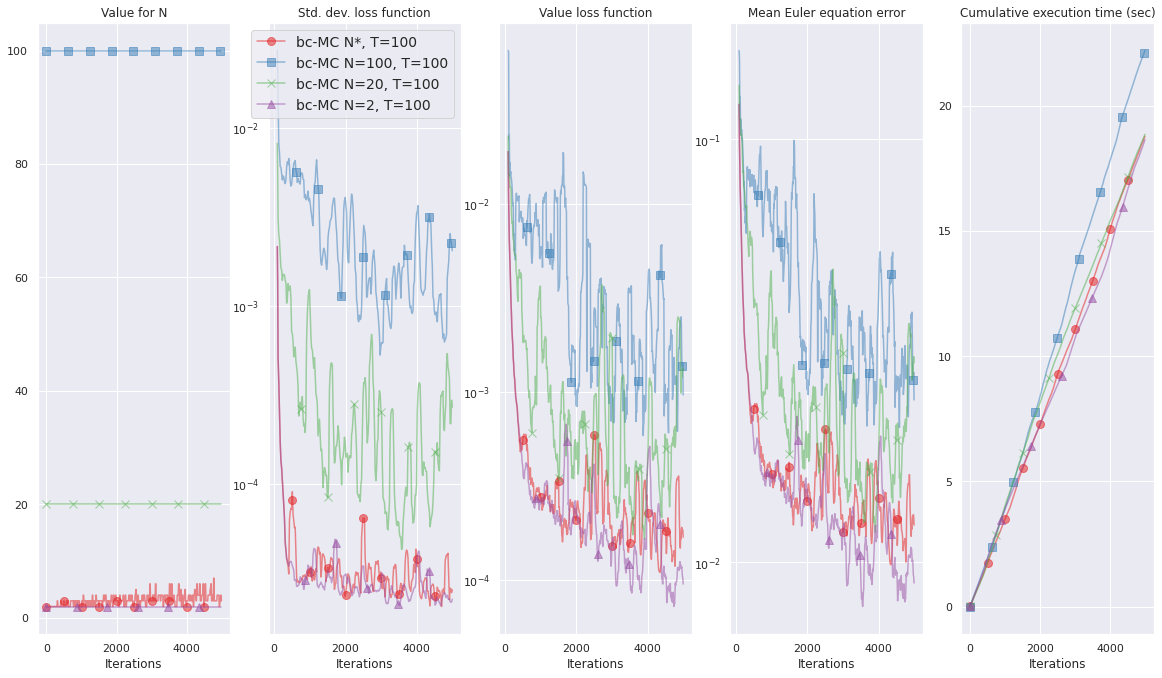

learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000598, mean euler error 0.024459, [ 1000/ 5000]
N: 4 loss: 0.000426, mean euler error 0.020630, [ 2000/ 5000]
N: 4 loss: 0.000385, mean euler error 0.019632, [ 3000/ 5000]
N: 4 loss: 0.000234, mean euler error 0.015295, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.55s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000480, mean euler error 0.021906, [ 1000/ 5000]
N: 2 loss: 0.000279, mean euler error 0.016693, [ 2000/ 5000]
N: 4 loss: 0.000164, mean euler error 0.012823, [ 3000/ 5000]
N: 4 loss: 0.000696, mean euler error 0.026388, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:37<00:00, 18.67s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.065064          0.255077          2  0.000069  0.003895
1           0    10  0.103023          0.320972          2  0.000069  0.047181
2           0    20  0.078150          0.279554          2  0.000026  0.077841
3           0    30  0.029615          0.172089          2  0.000026  0.115938
4           0    40  0.027195          0.164908          2  0.000013  0.145908
learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 100 loss: 0.031874, mean euler error 0.178533, [    0/ 5000]
N: 100 loss: 0.000977, mean euler error 0.031259, [ 1000/ 5000]
N: 100 loss: 0.000221, mean euler error 0.014850, [ 2000/ 5000]
N: 100 loss: 0.001199, mean euler error 0.034628, [ 3000/ 5000]
N: 100 loss: 0.002056, mean euler error 0.045341, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.32s/it]

N: 100 loss: 0.016275, mean euler error 0.127572, [    0/ 5000]
N: 100 loss: 0.002140, mean euler error 0.046258, [ 1000/ 5000]
N: 100 loss: 0.002076, mean euler error 0.045566, [ 2000/ 5000]
N: 100 loss: 0.004425, mean euler error 0.066524, [ 3000/ 5000]
N: 100 loss: 0.000710, mean euler error 0.026645, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.08s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.031874          0.178533        100  0.003675  0.004371
1           0    10  0.948884          0.974107        100  0.003675  0.045243
2           0    20  0.008739          0.093481        100  0.002633  0.077746
3           0    30  0.009263          0.096243        100  0.002633  0.115121
4           0    40  0.009565          0.097802        100  0.001758  0.147960
learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 20 loss: 0.092309, mean euler error 0.303824, [    0/ 5000]
N: 20 loss: 0.003091, mean euler error 0.055594, [ 1000/ 5000]
N: 20 loss: 0.000592, mean euler error 0.024323, [ 2000/ 5000]
N: 20 loss: 0.000359, mean euler error 0.018937, [ 3000/ 5000]
N: 20 loss: 0.000497, mean euler error 0.022301, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.61s/it]

N: 20 loss: 0.089046, mean euler error 0.298405, [    0/ 5000]
N: 20 loss: 0.000630, mean euler error 0.025107, [ 1000/ 5000]
N: 20 loss: 0.001082, mean euler error 0.032890, [ 2000/ 5000]
N: 20 loss: 0.000331, mean euler error 0.018183, [ 3000/ 5000]
N: 20 loss: 0.000504, mean euler error 0.022442, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.52s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092309          0.303824         20  0.000725  0.017367
1           0    10  0.024571          0.156752         20  0.000725  0.059014
2           0    20  0.012373          0.111235         20  0.000415  0.094176
3           0    30  0.011790          0.108581         20  0.000415  0.143525
4           0    40  0.008810          0.093860         20  0.000271  0.180682
learning rate: 0.001
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.000598, mean euler error 0.024459, [ 1000/ 5000]
N: 2 loss: 0.000239, mean euler error 0.015450, [ 2000/ 5000]
N: 2 loss: 0.000284, mean euler error 0.016852, [ 3000/ 5000]
N: 2 loss: 0.000305, mean euler error 0.017452, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:16<00:16, 16.57s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.000480, mean euler error 0.021906, [ 1000/ 5000]
N: 2 loss: 0.000244, mean euler error 0.015633, [ 2000/ 5000]
N: 2 loss: 0.000191, mean euler error 0.013811, [ 3000/ 5000]
N: 2 loss: 0.000187, mean euler error 0.013685, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:34<00:00, 17.02s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.065064          0.255077          2  0.000069  0.012743
1           0    10  0.103023          0.320972          2  0.000069  0.052814
2           0    20  0.078150          0.279554          2  0.000026  0.078519
3           0    30  0.029615          0.172089          2  0.000026  0.111759
4           0    40  0.027195          0.164908          2  0.000013  0.138712
     bc optim     lr    N    M    T  N_star
8   0.0  Adam  0.001    2  100  100    True
9   0.0  Adam  0.001  100    2  100   False
10  0.0  Adam  0.001   20   10  100   False
11  0.0  Adam  0.001    2  100  100   False


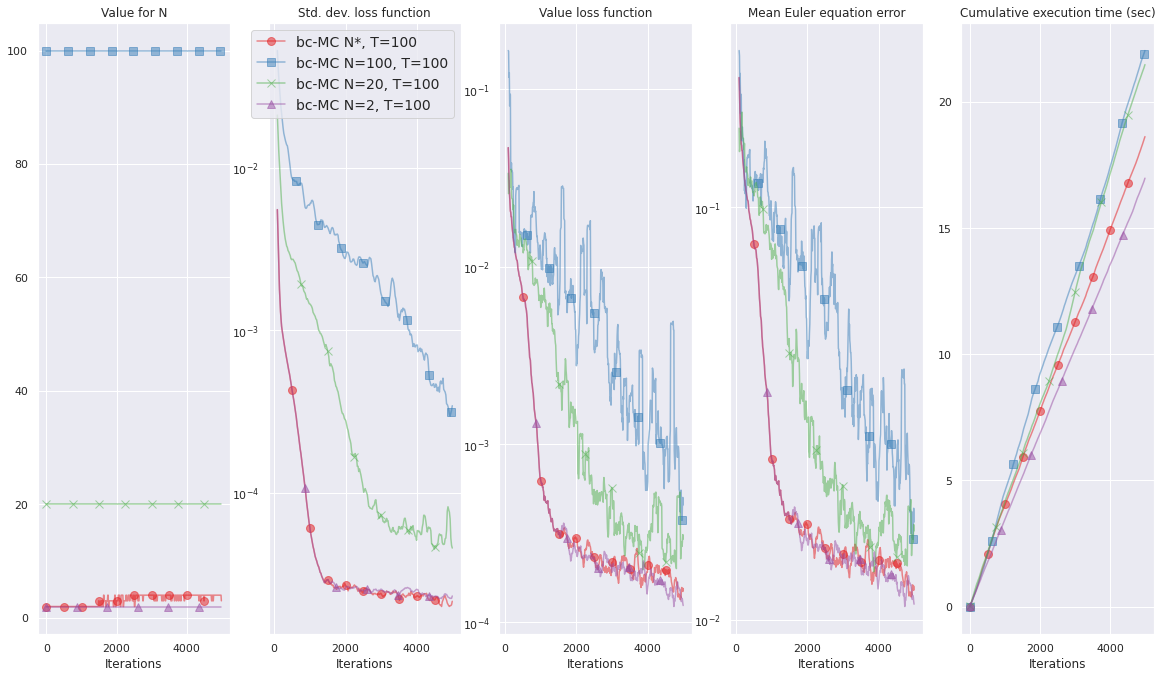

learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.005158, mean euler error 0.071817, [ 1000/ 5000]
N: 2 loss: 0.000366, mean euler error 0.019122, [ 2000/ 5000]
N: 4 loss: 0.000271, mean euler error 0.016462, [ 3000/ 5000]
N: 4 loss: 0.000261, mean euler error 0.016146, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.12s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.004243, mean euler error 0.065138, [ 1000/ 5000]
N: 2 loss: 0.000368, mean euler error 0.019176, [ 2000/ 5000]
N: 2 loss: 0.000514, mean euler error 0.022667, [ 3000/ 5000]
N: 4 loss: 0.000215, mean euler error 0.014666, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.76s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.065064          0.255077          2  0.000071  0.003893
1           0    10  0.113263          0.336546          2  0.000071  0.043097
2           0    20  0.096635          0.310862          2  0.000044  0.075524
3           0    30  0.039816          0.199540          2  0.000044  0.117467
4           0    40  0.039634          0.199084          2  0.000032  0.149279
learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([2, 200])
W_expanded.shape: torch.Size([200, 200])
M: 2
N: 100
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 100 loss: 0.031874, mean euler error 0.178533, [    0/ 5000]
N: 100 loss: 0.003312, mean euler error 0.057546, [ 1000/ 5000]
N: 100 loss: 0.001136, mean euler error 0.033709, [ 2000/ 5000]
N: 100 loss: 0.024956, mean euler error 0.157974, [ 3000/ 5000]
N: 100 loss: 0.015410, mean euler error 0.124139, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.62s/it]

N: 100 loss: 0.016275, mean euler error 0.127572, [    0/ 5000]
N: 100 loss: 0.003446, mean euler error 0.058707, [ 1000/ 5000]
N: 100 loss: 0.005879, mean euler error 0.076678, [ 2000/ 5000]
N: 100 loss: 0.011460, mean euler error 0.107053, [ 3000/ 5000]
N: 100 loss: 0.016300, mean euler error 0.127671, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.42s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.031874          0.178533        100  0.003712  0.013797
1           0    10  0.949221          0.974280        100  0.003712  0.052774
2           0    20  0.017407          0.131934        100  0.003131  0.085109
3           0    30  0.011312          0.106358        100  0.003131  0.127553
4           0    40  0.008507          0.092233        100  0.002397  0.159194
learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([10, 200])
W_expanded.shape: torch.Size([200, 200])
M: 10
N: 20
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 20 loss: 0.092309, mean euler error 0.303824, [    0/ 5000]
N: 20 loss: 0.005827, mean euler error 0.076334, [ 1000/ 5000]
N: 20 loss: 0.004114, mean euler error 0.064143, [ 2000/ 5000]
N: 20 loss: 0.002411, mean euler error 0.049103, [ 3000/ 5000]
N: 20 loss: 0.000688, mean euler error 0.026229, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.88s/it]

N: 20 loss: 0.089046, mean euler error 0.298405, [    0/ 5000]
N: 20 loss: 0.001876, mean euler error 0.043318, [ 1000/ 5000]
N: 20 loss: 0.006127, mean euler error 0.078276, [ 2000/ 5000]
N: 20 loss: 0.001670, mean euler error 0.040868, [ 3000/ 5000]
N: 20 loss: 0.001665, mean euler error 0.040805, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.68s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.092309          0.303824         20  0.000737  0.011626
1           0    10  0.026593          0.163072         20  0.000737  0.051711
2           0    20  0.017091          0.130731         20  0.000560  0.086622
3           0    30  0.016144          0.127060         20  0.000560  0.123480
4           0    40  0.010144          0.100715         20  0.000428  0.153043
learning rate: 0.0005
nb epochs: 5000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
T: False
Budget constraint: 0.0
σ_shocks: 0.01
use_Sobol: False
optimizer_chosen: Adam
use_scheduler: False
grid_depth_chosen: 3
grid_depth_chosen: 3
surplus_threshold_chosen: 0.0001
w1: 0.5
w2: 0.5
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

N: 2 loss: 0.065064, mean euler error 0.255077, [    0/ 5000]
N: 2 loss: 0.005158, mean euler error 0.071817, [ 1000/ 5000]
N: 2 loss: 0.000366, mean euler error 0.019122, [ 2000/ 5000]
N: 2 loss: 0.000337, mean euler error 0.018358, [ 3000/ 5000]
N: 2 loss: 0.000456, mean euler error 0.021344, [ 4000/ 5000]


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.17s/it]

N: 2 loss: 0.107545, mean euler error 0.327940, [    0/ 5000]
N: 2 loss: 0.004243, mean euler error 0.065138, [ 1000/ 5000]
N: 2 loss: 0.000368, mean euler error 0.019176, [ 2000/ 5000]
N: 2 loss: 0.000306, mean euler error 0.017503, [ 3000/ 5000]
N: 2 loss: 0.000206, mean euler error 0.014351, [ 4000/ 5000]


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.21s/it]


   repetition  iter      loss  mean_Euler_error  optimal_N  var_loss      time
0           0     0  0.065064          0.255077          2  0.000071  0.012407
1           0    10  0.113263          0.336546          2  0.000071  0.054690
2           0    20  0.096635          0.310862          2  0.000044  0.085422
3           0    30  0.039816          0.199540          2  0.000044  0.124011
4           0    40  0.039634          0.199084          2  0.000032  0.152981
     bc optim      lr    N    M    T  N_star
12  0.0  Adam  0.0005    2  100  100    True
13  0.0  Adam  0.0005  100    2  100   False
14  0.0  Adam  0.0005   20   10  100   False
15  0.0  Adam  0.0005    2  100  100   False


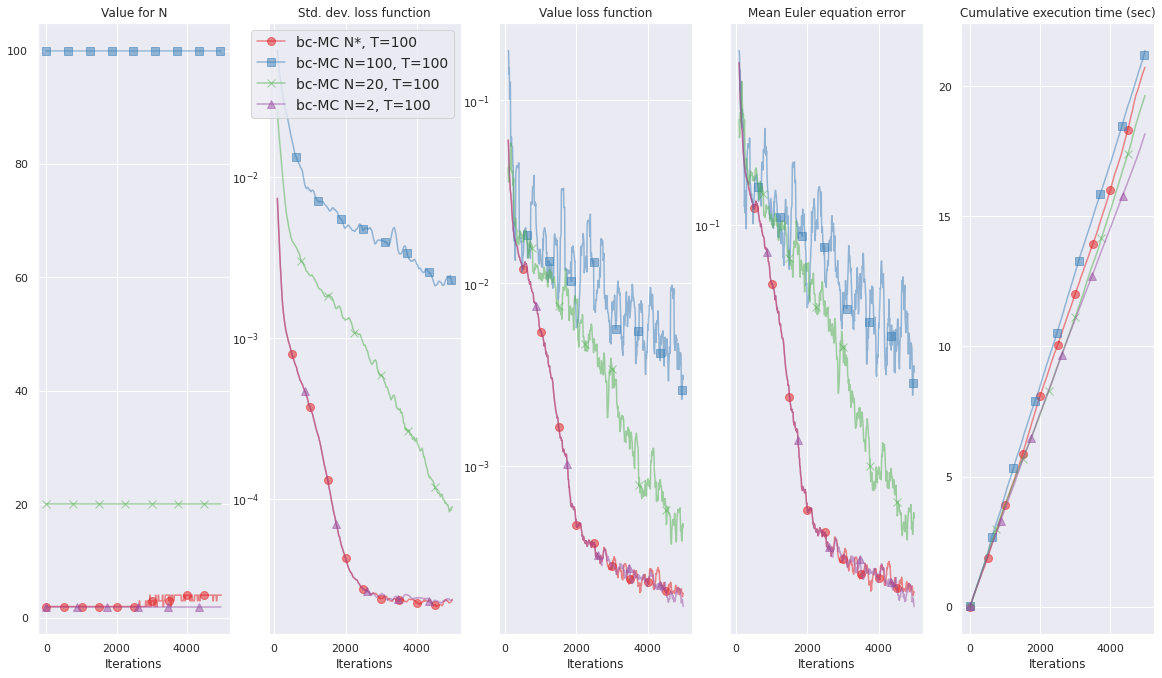

In [35]:
extension_csv_file = "opt_N"

if run_analysis_2 == True: #start the analysis (can be very long)
    print("Starting analysis 2. Choose N*.")

    # Plotting options
    #Plotting option
    tol_float = 10e-40 #sys.float_info.epsilon
    mult=0.5
    alpha_bands=0.05
    display_CI = False #False

    rate = 10
    colors = sns.color_palette("Set1", 5)
    markers = ["o", "s", "x", "^", "D"]
    markersize= 8
    ref_freq = 50
    alpha_chosen=0.5
    list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
    prefix = "" #"" #"P50_" # ""

    #lr_loop = [0.1, 0.01, 0.001] #learning rate
    lr_loop = [0.05, 0.01, 0.001, 0.0005] #[0.05, 0.01, 0.005] #learning rate
    optimizer_loop = ["Adam"] #["SGD", "Adam"]# ["SGD", "Adam"] #solvers

    #bc_loop = [0.0] #different types of borrowing constraints
    T_loop = [100, 100, 100, 100] #[100, 100, 100, 100, 500]
    divs = [1, 50, 10, 1] #[1, 50, 10, 1, 1] 
    N_star_loop = [True, False, False, False]

    M_loop = [int(T/(div)) for (div, T) in zip(divs, T_loop)]
    N_loop = [int(2*T/M) for (M,T) in zip(M_loop, T_loop)] #T=MN/2

    print(f"T: {T_loop}")
    print(f"M: {M_loop}")
    print(f"N: {N_loop}")
    print(f"N_star: {N_star_loop}")
    # Safety check
    print(np.array(M_loop)*np.array(N_loop)/2)
    
    random.seed(seed_number) # For replicability reasons
    print(random.random()) 
    torch.manual_seed(seed_number)

    model_bcMC = NeuralNetwork(params).to(device)
    model_bcMC_untrained = copy.deepcopy(model_bcMC)

    # store hyperparams used
    list_bc_used = []
    list_optimizer_used = []
    list_lr_used = []
    list_N_used = []
    list_M_used = []
    list_T_used = []
    list_N_star_used = []

    list_dfs_hyperparams = [] #to store results in a dataframe

    # Loop over sigma
    for (bc_chosen) in bc_loop:
        for optimizer_chosen in optimizer_loop: # Loop over solvers
            for lr_chosen in lr_loop:  # Loop over learning rate 
                for (N_chosen, M_chosen, use_N_star) in zip(N_loop, M_loop, N_star_loop):  #Loop over (M, N) for some choices of T

                    # create a reference params object
                    params = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen, 
                                      nb_epochs_chosen, bc_chosen, order_gauss,
                                      σ_shocks_chosen, use_Sobol_chosen, optimizer_chosen, 
                                      dim_p_chosen, grid_depth_chosen, 
                                      nb_refinements_chosen, surplus_threshold_chosen, 
                                      "params_TI", nb_points_w=3, nb_points_other=3,
                                      w1 = w1_chosen, w2 = w2_chosen)

                    show_params(params)

                    # append list
                    list_bc_used.append(params.bc)
                    list_optimizer_used.append(params.optimizer)
                    list_lr_used.append(params.lr)
                    list_N_used.append(params.N)
                    list_M_used.append(params.M)
                    list_T_used.append(params.T)
                    list_N_star_used.append(use_N_star)

                    # Create grids
                    grid_N = np.array([N for N in range(2, params.T+2, 2)])
                    grid_M = 2*params.T/grid_N

                    is_int = grid_M % 1 == 0
                    grid_N = grid_N[is_int]
                    grid_M = grid_M[is_int]

                    print(grid_N)
                    print(grid_M)
                    print(grid_N*grid_M)

                    # Pre-calculate params associated with grid choices
                    list_params = []
                    for (ind, (N_chosen, M_chosen)) in enumerate(zip(grid_N, grid_M)):
                        # Change M and N
                        params_local = MyParams(int(N_chosen), int(M_chosen), params.lr, params.pre_train_model,
                                  params.nb_epochs, params.bc, params.order_gauss,
                                  params.σ_shocks, params.use_Sobol, params.optimizer, 
                                  params.dim_p, params.grid_depth, 
                                  params.nb_refinements, params.surplus_threshold, 
                                  "params_TI", params.n_points_w, params.n_points_grid,
                                  params.w1, params.w2)
                        list_params.append(params_local)

                    list_list_Euler_mean = [] #Mean Euler error 
                    list_list_Euler_i = [] #store index i
                    list_list_Euler_loss = [] #store value function
                    list_list_optimal_N = [] #optimal N
                    list_list_var_loss = [] #store variance of loss
                    list_list_time = [] #store time
                    

                    for rep in tqdm(range(0, nb_reps)): # Loop over different iterations of solver
                        random.seed(int(rep)) #same series of shocks for same rep
                        torch.manual_seed(int(rep)) #same series of shocks for same rep
                        # Initialize a new NN
                        model_MC = NeuralNetwork(params).to(device)
                        #model_MC = copy.deepcopy(model_bcMC) #create a copy of NN
                        model_MC.train()
                        # Optimizer
                        optimizer = create_optimizer(model_MC, params.optimizer, params.lr, params.momentum)
                        # Scheduler
                        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
                        loss_epochs_MC = torch.zeros(params.nb_epochs)
                        list_Euler_mean = [] #mean
                        list_Euler_i = [] #store index i
                        list_Euler_loss = [] #store loss
                        list_time = [] #store elapsed time (sec)
                        calculate_variance_loss = True # Calculate variance of loss or not
                        list_var_loss = [] #store variance of the loss
                        list_optimal_N = [] #store the optimal N
                        list_optimal_N_current = [] #store the current optimal N used.
                        optimal_N = params.N #set initial choice for N
                        index_best_N = np.where(grid_N == optimal_N)[0][0]
                        freq_var =  20 #frequency with which the variance of the loss is calculated
                        freq_loss = 10 #frequency with which the loss is calculated
                        ratio_freq_loss_freq_var = int(freq_var/freq_loss)
                        use_exact_accuracy_metrics = False # If False, use square loss to get the EEE
                    
                        start = timer()
                        for i in range(0, params.nb_epochs):
                            # Clear gradient
                            optimizer.zero_grad()
                            # params associated with the current best N:
                            params_local = list_params[index_best_N]
                            # Calculate loss
                            loss = Ξ_torch_MC(model_MC, params_local)
                            loss_epochs_MC[[i]] = float(loss.item())

                            # Backpropagation
                            loss.backward()
                            # Avoid explosive gradients
                            clip_grad_norm_(model_MC.parameters(), max_norm=1.0, error_if_nonfinite=False)
                            # Gradient descent step
                            optimizer.step()

                            if i % freq_loss == 0: #Monitor accuracy
                                model_MC.eval()
                                list_optimal_N_current.append(optimal_N) #N used
                                # Evaluate Euler error
                                if use_exact_accuracy_metrics == True:
                                    with torch.no_grad():
                                        euler, euler_bis, c, c_RHS, w = evaluate_accuracy_pytorch_MC_frozen(model_MC, params_local)
                                    list_Euler_mean.append(np.mean(euler_bis))
                                # Square root of loss function
                                else:
                                    EEE = float(loss.item())**0.5
                                    list_Euler_mean.append(EEE)
                                list_Euler_i.append(i) #Index
                                list_Euler_loss.append(float(loss.item())) #loss
                                model_MC.train()
            
                                # Calculate time
                                now = timer()
                                elapsed_time = now - start
                                list_time.append(elapsed_time)
                            
                            # Calculation of variance of the loss and optimal choice for N
                            if (calculate_variance_loss == True) & (i % freq_var == 0): #calculate variance of loss
                                var_loss_formula, var_f, cov_f = calculate_variance_gaussian(params_local, model_MC, nb_draws, grid_M, grid_N)
                                if use_N_star == False:
                                    index_best_N_dummy = np.argmin(var_loss_formula)
                                    optimal_N_dummy = grid_N[index_best_N_dummy] #Do not modify optimal_N
                                    list_optimal_N.append(optimal_N_dummy)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                                # When N* algo is used, update the value of N during training
                                else:
                                    # Gaussian formula
                                    index_best_N = np.argmin(var_loss_formula)
                                    # Var/Cov
                                    #N_star_theory = 1 + np.abs(var_f/cov_f)
                                    #index_best_N = np.argmin(np.abs(N_star_theory - grid_N)) #project on grid
                                    optimal_N = grid_N[index_best_N]
                                    list_optimal_N.append(optimal_N)
                                    list_var_loss.append(var_loss_formula[index_best_N])
                            if i % 1000 == 0:
                                loss, current = float(loss.item()), i
                                print(f"N: {optimal_N} loss: {loss:>7f}, mean euler error {list_Euler_mean[-1]:>7f}, [{current:>5d}/{params_local.nb_epochs:>5d}]")
                            if (i % params_local.freq_scheduler == 0) & (i != 0) & (params_local.use_scheduler == True):
                                scheduler.step()
                                print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

                        if params_local.optimizer == "SWA":
                            optimizer.swap_swa_sgd()
                        
                        # Save model to disk
                        torch.save(model_MC.state_dict(), output_folder_models + f'model_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.pth')
        
                        #Store values
                        list_list_Euler_mean.append(list_Euler_mean) #Mean Euler error 
                        list_list_Euler_i.append(list_Euler_i) #store index i
                        list_list_Euler_loss.append(list_Euler_loss) #store value function
                        list_list_optimal_N.append(list_optimal_N_current) #optimal N
                        list_list_var_loss.append(list_var_loss)
                        list_list_time.append(list_time)
                        
                    # Flatten lists of lists
                    list_list_Euler_i = numpy_flat(list_list_Euler_i)
                    list_list_Euler_loss = numpy_flat(list_list_Euler_loss)
                    list_list_Euler_mean = np.real(numpy_flat(list_list_Euler_mean))
                    list_list_optimal_N = numpy_flat(list_list_optimal_N)
                    list_list_var_loss = numpy_flat(list_list_var_loss)
                    list_list_time = numpy_flat(list_list_time)
                    
                    # Create dataframe and summary stats
                    lst = list(range(0, nb_reps))
                    list_index_rep = list(np.repeat(lst, len(list_Euler_i))) #gradient descent steps

                    df_bcMC_loop = pd.DataFrame({
                                        'repetition': list_index_rep,
                                        'iter': list_list_Euler_i,
                                        'loss': np.abs(list_list_Euler_loss),
                                        'mean_Euler_error': list_list_Euler_mean,
                                        'optimal_N': list_list_optimal_N,
                                        'var_loss': np.repeat(list_list_var_loss, ratio_freq_loss_freq_var),
                                        'time': list_list_time,
                       })

                    print(df_bcMC_loop.head())

                    # Statistics on results
                    df_bcMC_loop_average = df_bcMC_loop.groupby('iter').mean().reset_index() #mean value by iteration
                    df_bcMC_loop_average.head()

                    list_cols = ["loss", "mean_Euler_error", "optimal_N", "var_loss", "time"]

                    for col in list_cols:
                        df_bcMC_loop_average["min_" + col] = df_bcMC_loop.groupby('iter')[col].min().reset_index()[col]                     
                        df_bcMC_loop_average["max_" + col] = df_bcMC_loop.groupby('iter')[col].max().reset_index()[col]
                        df_bcMC_loop_average["std_" + col] = df_bcMC_loop.groupby('iter')[col].std().reset_index()[col]
                        for qq in [5, 10, 25, 50, 75, 90, 95]:
                            df_bcMC_loop_average["P" + str(qq) + "_" + col] = df_bcMC_loop.groupby('iter')[col].quantile(qq/100).reset_index()[col]

                    # append list
                    list_dfs_hyperparams.append(df_bcMC_loop_average)
                #------------------------------------
                # End of different choices for (M,N):
                # Plot
                #------------------------------------
                df_hyperparams = pd.DataFrame({"bc":list_bc_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

                # select combination
                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["bc"] == bc_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)

                list_dfs_plot = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                for (i, min_index) in enumerate([0]):
                    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:], df[f"{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    ax1.set_xlabel("Iterations")

                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax3.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")


                    #var = "mean_percentage_error"
                    var = "mean_Euler_error"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean()
                        ax4.plot(df["iter"][min_index:], MA_series[min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax4.fill_between(df["iter"][min_index:], MA_series[min_index:] - mult*MA_std[min_index:], MA_series[min_index:] + mult*MA_std[min_index:], color=c, alpha=alpha_bands)

                    ax4.set_yscale('log')
                    ax4.set_title('Mean Euler equation error')
                    ax4.set_xlabel("Iterations")

                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs_plot, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:], df[f"{prefix}{var}"][min_index:] - mult*df[f"std_{var}"][min_index:], df[f"{prefix}{var}"][min_index:] + mult*df[f"std_{var}"][min_index:], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

                    figname = output_folder + f'time_varying_N_bc_{bc_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.png'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)

                    figname = output_folder + f'time_varying_N_bc_{bc_chosen}_lr_{lr_chosen}_optim_{optimizer_chosen}_loop_{i}.pdf'
                    plt.savefig(figname, bbox_inches="tight", dpi=300)
                    plt.show()


In [36]:
if save_to_csv == True:
    print(f"Writting CSV. Extension: {extension_csv_file}")

    df_hyperparams = pd.DataFrame({"bc":list_bc_used,
                        "optim": list_optimizer_used,
                        "lr": list_lr_used,
                        "N": list_N_used,
                        "M": list_M_used,
                        "T": list_T_used,
                        "N_star": list_N_star_used})

    df_hyperparams.to_csv(output_folder + f"hyperparams_{extension_csv_file}.csv", index=False)
    print(df_hyperparams)

    index_df = 0
    for index, row in df_hyperparams.iterrows():
        bc_chosen = row['bc']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
        list_dfs_hyperparams[index_df].to_csv(filen, index=False)
        index_df+=1
        

Writting CSV. Extension: opt_N
     bc optim      lr    N    M    T  N_star
0   0.0  Adam  0.0500    2  100  100    True
1   0.0  Adam  0.0500  100    2  100   False
2   0.0  Adam  0.0500   20   10  100   False
3   0.0  Adam  0.0500    2  100  100   False
4   0.0  Adam  0.0100    2  100  100    True
5   0.0  Adam  0.0100  100    2  100   False
6   0.0  Adam  0.0100   20   10  100   False
7   0.0  Adam  0.0100    2  100  100   False
8   0.0  Adam  0.0010    2  100  100    True
9   0.0  Adam  0.0010  100    2  100   False
10  0.0  Adam  0.0010   20   10  100   False
11  0.0  Adam  0.0010    2  100  100   False
12  0.0  Adam  0.0005    2  100  100    True
13  0.0  Adam  0.0005  100    2  100   False
14  0.0  Adam  0.0005   20   10  100   False
15  0.0  Adam  0.0005    2  100  100   False


In [37]:
# Load files
if read_from_csv == True:
    print("Reading CSV")

    df_hyperparams = pd.read_csv(output_folder + f'hyperparams_{extension_csv_file}.csv')
    print(df_hyperparams)

    list_dfs_hyperparams = []
    for index, row in df_hyperparams.iterrows():
        bc_chosen = row['bc']
        optimizer_chosen = row["optim"]
        lr_chosen = row["lr"]
        N_chosen = row["N"]
        M_chosen = row["M"]
        use_N_star = row["N_star"]
        # Save to disk
        filen = output_folder + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
        list_dfs_hyperparams.append(pd.read_csv(filen))


Reading CSV
     bc optim      lr    N    M    T  N_star
0   0.0  Adam  0.0500    2  100  100    True
1   0.0  Adam  0.0500  100    2  100   False
2   0.0  Adam  0.0500   20   10  100   False
3   0.0  Adam  0.0500    2  100  100   False
4   0.0  Adam  0.0100    2  100  100    True
5   0.0  Adam  0.0100  100    2  100   False
6   0.0  Adam  0.0100   20   10  100   False
7   0.0  Adam  0.0100    2  100  100   False
8   0.0  Adam  0.0010    2  100  100    True
9   0.0  Adam  0.0010  100    2  100   False
10  0.0  Adam  0.0010   20   10  100   False
11  0.0  Adam  0.0010    2  100  100   False
12  0.0  Adam  0.0005    2  100  100    True
13  0.0  Adam  0.0005  100    2  100   False
14  0.0  Adam  0.0005   20   10  100   False
15  0.0  Adam  0.0005    2  100  100   False


    bc optim    lr    N    M    T  N_star
0  0.0  Adam  0.05    2  100  100    True
1  0.0  Adam  0.05  100    2  100   False
2  0.0  Adam  0.05   20   10  100   False
3  0.0  Adam  0.05    2  100  100   False


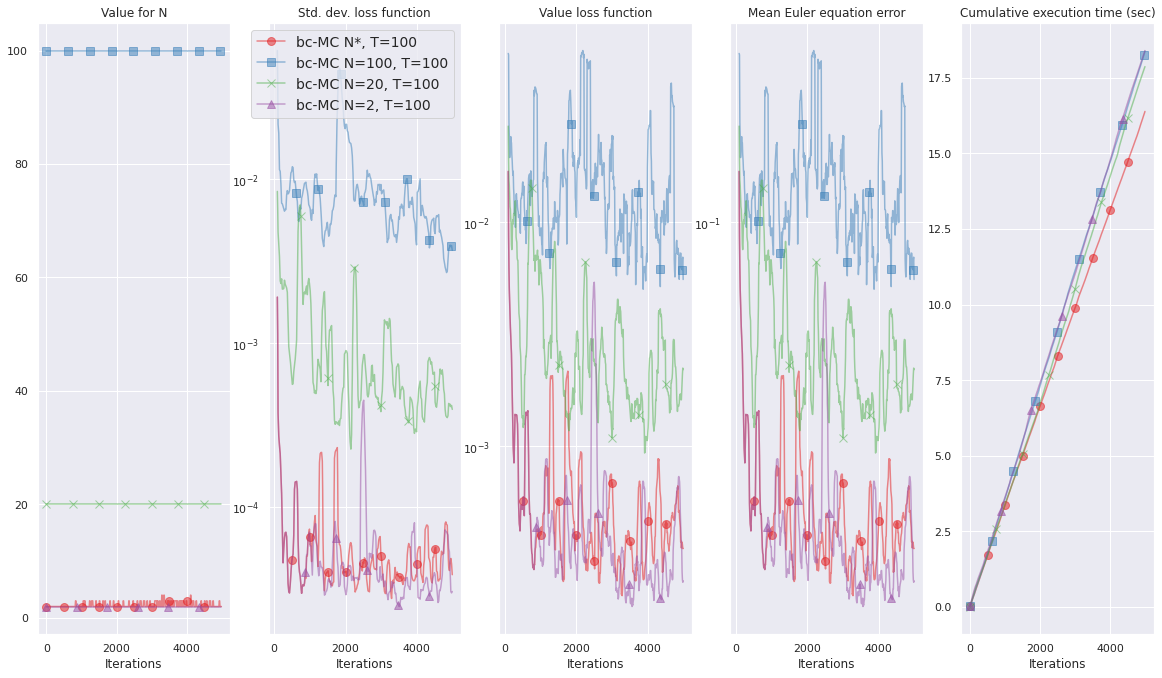

    bc optim    lr    N    M    T  N_star
4  0.0  Adam  0.01    2  100  100    True
5  0.0  Adam  0.01  100    2  100   False
6  0.0  Adam  0.01   20   10  100   False
7  0.0  Adam  0.01    2  100  100   False


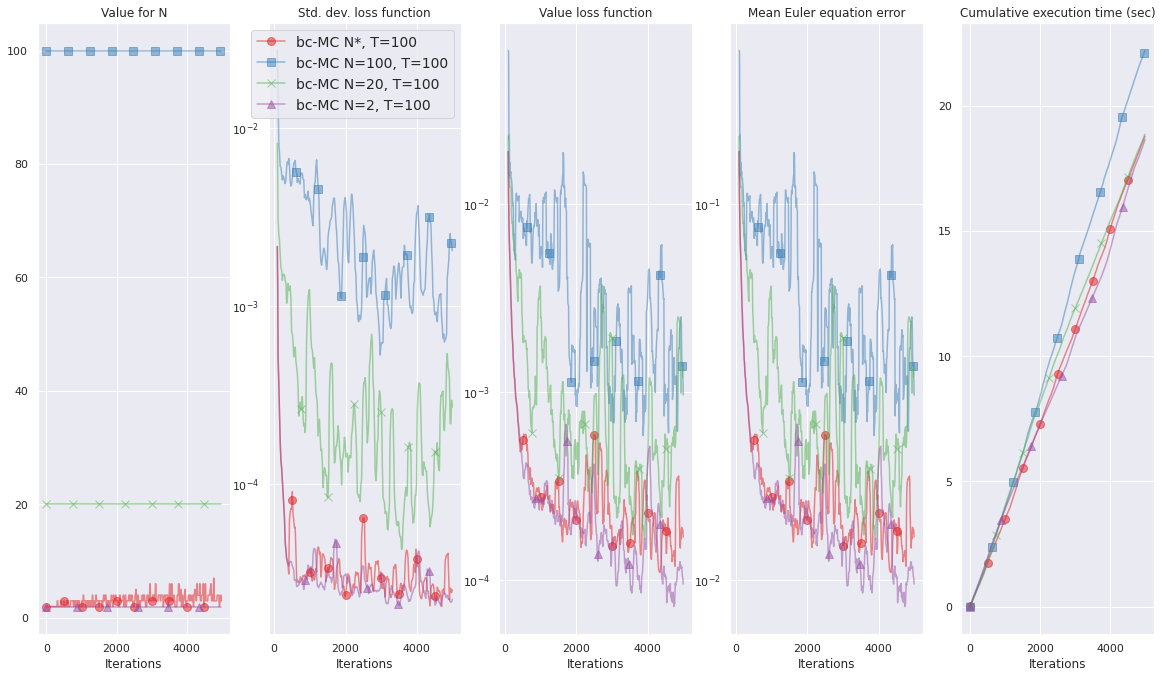

     bc optim     lr    N    M    T  N_star
8   0.0  Adam  0.001    2  100  100    True
9   0.0  Adam  0.001  100    2  100   False
10  0.0  Adam  0.001   20   10  100   False
11  0.0  Adam  0.001    2  100  100   False


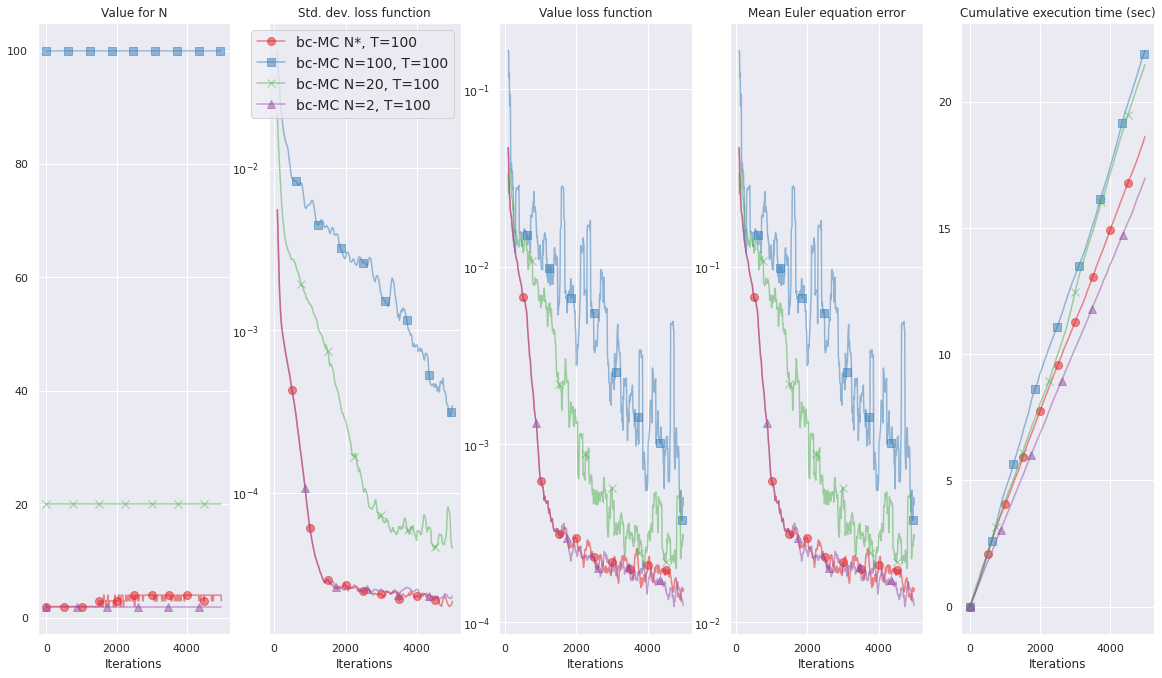

     bc optim      lr    N    M    T  N_star
12  0.0  Adam  0.0005    2  100  100    True
13  0.0  Adam  0.0005  100    2  100   False
14  0.0  Adam  0.0005   20   10  100   False
15  0.0  Adam  0.0005    2  100  100   False


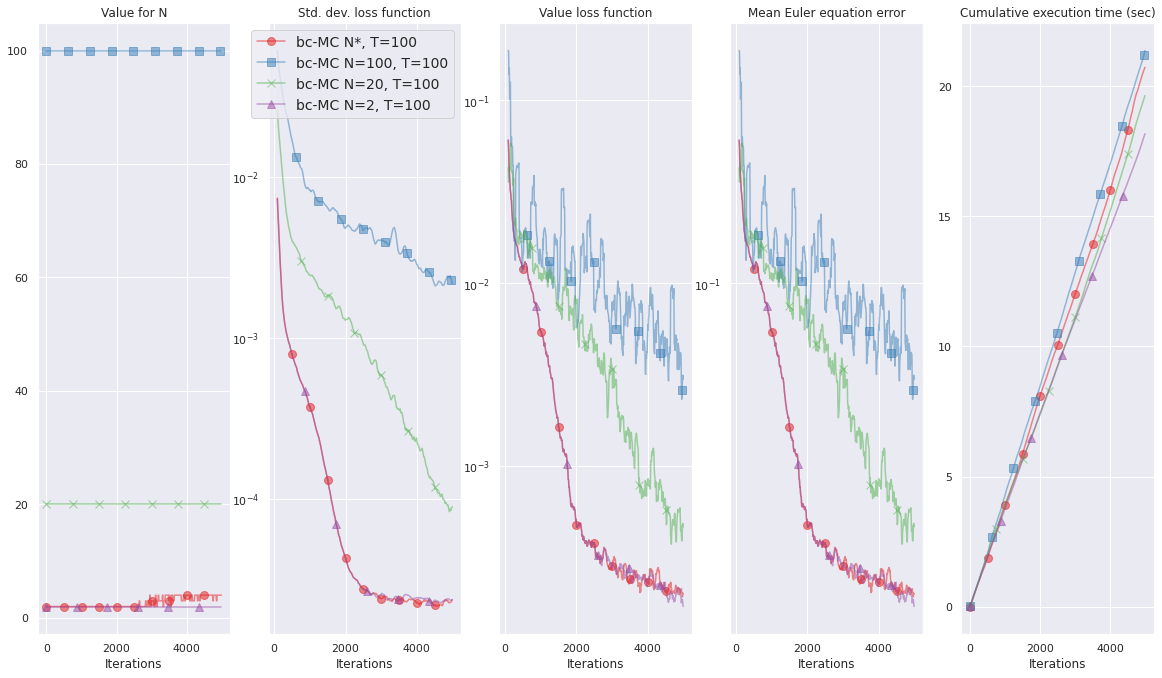

In [38]:
mult=0.5
alpha_bands=0.10
display_CI = False #False

rate = 10
colors = sns.color_palette("Set1", 5)
markers = ["o", "s", "x", "^", "D"]
markersize= 8
ref_freq = 50
alpha_chosen=0.5
list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
prefix = "" #"" #"" #"P50_" # ""

list_combinations_used = []             
for index, row in df_hyperparams.iterrows():
    bc_chosen = row['bc']
    optimizer_chosen = row["optim"]
    lr_chosen = row["lr"]
    N_chosen = row["N"]
    M_chosen = row["M"]
    use_N_star = row["N_star"]
        
    combination = f'{optimizer_chosen}-{bc_chosen}-{lr_chosen}'
    if combination not in list_combinations_used:
        list_combinations_used.append(combination)
    else:
        continue #If combination already used, pass
    df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
    df_sel = df_sel[df_sel["bc"] == bc_chosen]
    df_sel = df_sel[df_sel["lr"] == lr_chosen]
    print(df_sel)
    

    list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
    list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
    list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
    list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
    list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

    list_labels = []
    for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
        if N_star == True:
            list_labels += [f"bc-MC N*, T={T}"]
        else:
            list_labels += [f"bc-MC N={N}, T={T}"]
    #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

    #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
    for (i, (min_index, max_index)) in enumerate(zip([0], [2500])):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

        var = "optimal_N"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
        #ax1.set_yscale('log')
        ax1.set_title('Value for N')
        ax1.set_xlabel("Iterations")

        var = "var_loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax2.set_yscale('log')
        ax2.set_title('Std. dev. loss function')
        ax2.legend(loc="upper right")
        ax2.set_xlabel("Iterations")

        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        ax3.set_yscale('log')
        ax3.set_title('Value loss function')
        ax3.set_xlabel("Iterations")


        """
        #var = "mean_percentage_error"
        var = "mean_Euler_error"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
        """
        # square root series for loss
        var = "loss"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            MA_series = np.sqrt(pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean()) # Moving average series
            MA_std = np.sqrt(pd.Series(df[f"std_{var}"]).rolling(rate).mean()) # Moving average std dev. across series, for same hyperparams
            ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)

        ax4.set_yscale('log')
        ax4.set_title('Mean Euler equation error')
        ax4.set_xlabel("Iterations")

        var = "time"
        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
            ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
            if display_CI==True:
                ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

        ax5.set_xlabel("Iterations")
        ax5.set_title("Cumulative execution time (sec)")

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
        plt.savefig(figname, bbox_inches="tight", dpi=300)

        figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
        plt.savefig(figname, bbox_inches="tight", dpi=300)
        plt.show()


### Shutting down session

In [39]:
print(json.loads(getSystemInfo()))

{'platform': 'Linux', 'platform-release': '5.4.0-169-generic', 'platform-version': '#187-Ubuntu SMP Thu Nov 23 14:52:28 UTC 2023', 'architecture': 'x86_64', 'hostname': 'julien-mypc', 'ip-address': '127.0.1.1', 'mac-address': '9f:2b:54:00:5d:79', 'processor': 'x86_64', 'ram': '15 GB'}


In [40]:
# Copy to drive
if on_Colab==True:

    path = f"/gdrive/My Drive/{output_extension}"
    # Create folder if does not exist:
    if not os.path.exists(path):
      # If it doesn't exist, create it
      os.mkdir(path)
    
    ## A. Save to Grdive
    # Compress to zip
    !zip -r /content/file.zip /content/output

    shutil.copy("/content/file.zip", f"{path}/file.zip")

    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')


In [41]:
if on_Colab==True:

    # Wait 2 minutes
    time.sleep(120)
    
    ## Close session
    from google.colab import runtime
    runtime.unassign()
